In [30]:
### Make notebook wider:

from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))




In [31]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import statistics
import json
from PIL import Image, ImageDraw, ImageFont
import seaborn as sns;
import json
import ast
import warnings
warnings.filterwarnings("ignore")

def conactinate_nth_items(startlist):
    concatinated_column_vectors = []
    for c in range(len(max(startlist, key=len))):
        column = []
        for t in range(len(startlist)):
            if c <= len(startlist[t])-1:
                column = column + [startlist[t][c]]
        concatinated_column_vectors.append(column)
    return concatinated_column_vectors

def SaveFig(file_name,figure_dir):
    if not os.path.isdir(figure_dir):
        os.makedirs(figure_dir)
    plt.savefig(figure_dir + file_name, bbox_inches='tight')
    plt.show()
    plt.close()


def cluster_events(start_times, end_times, threshold):
    clusters = []
    for i in range(len(start_times)):
        event_added = False
        for cluster in clusters:
            for index in cluster:
                if (start_times[i] <= end_times[index] + threshold and end_times[i] >= start_times[index] - threshold):
                    cluster.append(i)
                    event_added = True
                    break
            if event_added:
                break
        if not event_added:
            clusters.append([i])
    return clusters

def relative_dict(input_dict):
    total_sum = sum(input_dict.values())
    relative_dict = {key: value / total_sum for key, value in input_dict.items()}
    return relative_dict

def logic_machine_for_pair_catagorisation(pair,dominant,other):
    # if first one in dominant check for ordering:
    if pair[0] in dominant and pair[-1] in dominant:
        if pair_in_sequence(pair,dominant):
            return('ordered')
        elif pair_in_sequence(pair,dominant[::-1]):
            return('reverse')
        elif pair[-1] == pair[0]:
            return('repeat')
        elif pair[-1] in dominant:
            return('misordered') 
    # if its not these  options then check if it could be in the extra task seqs
    elif pair[0] in  (dominant + other) and pair[-1] in  (dominant + other):
        for item in other:
            if pair[0] in  (dominant + [item]):
                if pair_in_sequence(pair,(dominant + [item])):
                    return('ordered')
                elif pair_in_sequence(pair,(dominant + [item])[::-1]):
                    return('reverse')
                elif pair[-1] == pair[0]:
                    return('repeat')
                elif pair[-1] in (dominant + [item]):
                    return('misordered')  
        # if not this then check if both are in the extra seqs (and are not a repeat):
        if pair[0] in other and pair[-1] in other:
            if not pair[-1] == pair[0]: 
                return('ordered')
    else:
        # if item 1 is in but item 2 isnt then task to other 
        if pair[0] in  (dominant + other):
            if not pair[-1] in  (dominant + other):
                return('task to other')
        # if item 2 is in but item 1 isnt then other to task 
        elif not pair[0] in  (dominant + other):
            if pair[-1] in  (dominant + other):
                return('other to task')
            else:
                return('other')
    return print('ERROR!')

def catagorize_seqs(real_order,num_dominant_seqs,order):
    
    #deal wih the fact that the way I order the sequence messes up the order a bit
    if not len(real_order) == num_dominant_seqs:
        dominant = real_order[0:num_dominant_seqs]
        other_ = real_order[num_dominant_seqs::]
    else:
        dominant = real_order
        other_ = []

    amounts = []
    relative_amounts = []
    pair_outcomes = []
    pairs = []
    for sequence in order:
        ordered = 0
        reverse = 0
        repeat = 0
        misordered = 0
        non_to_task = 0
        task_to_non = 0
        other = 0
        for index,element in enumerate(sequence[0:-1]):
            pair = [element,sequence[index+1]]
            outcome = (logic_machine_for_pair_catagorisation(pair,dominant,other_))
            if outcome == 'ordered':
                ordered +=1
            elif outcome == 'reverse':
                reverse +=1
            elif outcome == 'repeat':
                repeat +=1
            elif outcome == 'misordered':
                misordered +=1
            elif outcome == 'task to other':
                task_to_non +=1
            elif outcome == 'other to task':
                non_to_task +=1
            elif outcome == 'other':
                other +=1
            pairs += [pair]
            pair_outcomes += [[outcome]]
        pairs += [['None']]
        pair_outcomes += [['None']]

        relative_amounts += [list(np.array([ordered,reverse,repeat,misordered,non_to_task,task_to_non,other])/(len(sequence)-1))]
        amounts += [[ordered,reverse,repeat,misordered,non_to_task,task_to_non,other]]
        
    return relative_amounts, amounts,pair_outcomes,pairs

def pair_in_sequence(pair, sequence):
    for i in range(len(sequence) - 1):
        if sequence[i] == pair[0] and sequence[i + 1] == pair[1]:
            return True
        # because its ciruclar:
        elif sequence[-1] == pair[0] and sequence[0] == pair[1]:
            return True
    return False


red = '#BE575F'
blue = '#2093C0'

In [11]:
#TO DO

### decay as a function of time from first defined rem/nrem timepoint


# filter switches

In [32]:
# seq filter takes presedence, if its on: only sequential events, if it is off: all events 
sequential_filter = True
## master switch - turns all sleep filters on/off (if you want all evets turn this off)
sleep_filters_on = True
# these filters refer to seq one above, and both can be true at the same time. 
nrem_filter = True
rem_filter = True
# set this as true (along with the fleep filter one) to override the other two an djust take the background 
background_only = False


## sanity checker / set save path:
print('this filtering gives...')
if sequential_filter == True:
    print(' - only sequential events')
    save_var = 'sequential_no_sleep_selected'
    type_var = 'sequential'
else:
    print('- all events')
    save_var = 'all_events_no_sleep_selected'
    type_var = 'all_events'
if sleep_filters_on == True:
    if not background_only:
        print('but only those which are in')
        if nrem_filter == True:
            print(' - nrem')
            save_var = type_var+'_NREM_sleep'
        if rem_filter == True:
            print(' - rem')
            save_var = type_var+'_REM_sleep'
        if nrem_filter == True and rem_filter == True:
            save_var = type_var+'_NREM_and_REM_sleep'
        
    else:
        print('but only those which are not in rem/nrem')
        save_var = type_var + '_OTHER_nonsleep'
        



this filtering gives...
 - only sequential events
but only those which are in
 - nrem
 - rem


In [4]:
### change the code so it just plots the 3 groups seperatley. 

# define paramters and paths

In [33]:
# save path
out_path = r'Z:\projects\Emmett\Documents\replay_paper\new_replay_analysis\FINAL\\' + save_var + '\\' 
# dat path:
dat_path = r"Z:\projects\sequence_squad\organised_data\ppseq_data\output_data\striatum\New_Post_sleep\\"

# # set org dat path 
# DAT_PATH = r"Z:\projects\sequence_squad\organised_data\animals\\"

# load in sleep time points
sleep_time_point_df = pd.read_csv(dat_path + 'sleep_time_points.csv')
# decide when sleep started
sleep_start = {}
for index,value in enumerate(sleep_time_point_df.approx_sleep_start.values):
    mouse = sleep_time_point_df.mir.values[index]
    sleep_start[mouse] = value
# define mice/sessions in each group    
expert_mice = sleep_time_point_df[sleep_time_point_df.group == 'expert'].mir.values
hlesion_mice = sleep_time_point_df[sleep_time_point_df.group == 'h_lesion'].mir.values
learning_mice = sleep_time_point_df[sleep_time_point_df.group == 'learning'].mir.values

In [6]:
expert_mice

array(['148_2_2', '136_1_3', '136_1_4', '149_1_1', '149_1_2', '149_1_3',
       '162_1_3', '178_1_4', '178_1_5', '178_1_6', '178_1_7', '178_1_8',
       '178_1_9', '178_2_1', '178_2_2', '178_2_3', '178_2_4', '268_1_10',
       '269_1_4', '269_1_5', '269_1_6', '269_1_7', '270_1_5', '270_1_6',
       '270_1_7'], dtype=object)

# load in data, calcuate vars etc. 

In [34]:
# ignore_list = ['269_1_5','269_1_6','270_1_1','178_2_3']
ignore_list = ['269_1_5','269_1_6']


dat_path = r"Z:\projects\sequence_squad\organised_data\ppseq_data\finalised_output\striatum\paper_submission\post_sleep\\"

## set up empty vars 
mirs = []

expert = []
hlesion = []
learning = []


# 1
reactivations_per_min = []
# 2
event_rate_binned = []
er_bins_relative_to_so = []
# 3
event_lens = []
# 4
av_coactive_len_per_chunk = []

e_coactive_freqs_counts = {}
hl_coactive_freqs_counts = {}
l_coactive_freqs_counts = {}

all_total_events = []
rel_task_nontask = []
chunks_task_nontask = []

task_nontask_num_spikes = []
task_nontask_e_len = []

chunk_expert = []
chunk_mid_time_post_onset = []
#5 
mouse_summed_amounts = []
ordered_sum = []
ordered_misordered_total = []


# warps = []


# loop across all mouse files
for run_index,pp_file in enumerate(os.listdir(dat_path)):
    if not 'sleep_time_points' in pp_file:
        # current mouse
        mouse = '_'.join(pp_file.split('_')[0:3])
        
        if not mouse in ignore_list:

            # if session in one of the groups (and define which)   
            if mouse in list(expert_mice) + list(hlesion_mice) + list(learning_mice):
                if mouse in expert_mice:
                    expert += [1]
                    hlesion += [0]
                    learning += [0]               
                elif mouse in hlesion_mice:                
                    expert += [0]
                    hlesion += [1]
                    learning += [0]
                elif mouse in learning_mice:                
                    expert += [0]
                    hlesion += [0]
                    learning += [1]

                print(run_index)

                print(mouse)



                # load in sleep start time 
                current_sleep_start = sleep_start[mouse]
                params_file = dat_path + pp_file + r'\trainingData\\' + 'params_' + mouse + '.json'
                with open(params_file, 'r') as file:
                    params = json.load(file)
                time_spans = params['time_span']

                # set path to processed files 
                current_mouse_path = dat_path + pp_file + '\\analysis_output'
                mirs += [mouse]

                ## set chunk vars 
                #1
                chunk_rpm = []
    #             chunk_warps = []
                #2
                chunk_binned_rate = []
                chunk_bins_relative_so = []
                #3
                chunk_event_lens = []

                #4
                coactive_freqs_chunk  = {}
                chunk_total_nontask_task_related_events = []
                total_events = 0
                chunk_task_num_spikes = []
                chunk_nontask_num_spikes = []
                chunk_task_e_len = []
                chunk_nontask_e_len = []

                #5
                chunk_summed_amounts = []
                chunk_ordered_sum = 0
                chunk_coactive_total = 0
                
                
                task_related = 0
                non_task_related = 0

                ## lopp across all chunk files
                for file in os.listdir(current_mouse_path):
                    if 'chunk' in file:
                        print(file)
                        current_data_path = current_mouse_path + '\\' + file + '\\'
                        chunk_time = np.load(current_data_path + 'chunk_time_interval.npy')
                        data = pd.read_csv(current_data_path + 'filtered_replay_clusters_df.csv')

                        ## filter this data
                        if sequential_filter == True: 
                            sequential_condition = data.ordering_classification == 'sequential'
                        else:
                            sequential_condition = np.array([True]*len(data.ordering_classification))

                        if sleep_filters_on == True:
                            if nrem_filter == True: 
                                nrem_condition = nrem__condition = data.nrem_events == 1
                            else:
                                nrem_condition = np.array([False]*len(data.nrem_events))

                            if rem_filter == True: 
                                rem_condition = rem__condition = data.rem_events == 1
                            else:
                                rem_condition = np.array([False]*len(data.rem_events))

                            if background_only == True:
                                rem_condition = rem__condition = data.rem_events == 0
                                nrem_condition = nrem__condition = data.nrem_events == 1

                        else:
                            nrem_condition = np.array([True]*len(data))
                            rem_condition = np.array([True]*len(data))




                        # filter is set up so that any true will carry forward 
                        filter_mask = sequential_condition * (nrem_condition + rem_condition)

                        filtered_chunk_data = data[filter_mask].reset_index()


                        # save out data
                        reactivations_found = len(filtered_chunk_data)



                        # this one depends on rem/nrem filter... 

    #                         # if sleep_filters_on is false, use all chunk time
                        if sleep_filters_on == False:
                            mins = np.diff(chunk_time)[0]
                        else:
                            # load in state times
                            rem_state_times = np.load(current_data_path + 'rem_state_times.npy')
                            nrem_state_times = np.load(current_data_path + 'nrem_state_times.npy')
                            if len(rem_state_times) > 0:
                                tot_rem = sum(np.diff(rem_state_times))[0]
                            else:
                                tot_rem = 0
                            if len(nrem_state_times) > 0:
                                tot_nrem = sum(np.diff(nrem_state_times))[0]
                            else:
                                tot_nrem = 0

                            # if background then use all non rem an dnon nrem times
                            if background_only:
                                mins = np.diff(chunk_time)[0] - (tot_rem+tot_nrem)
                            else:
                                # if both, use both 
                                if nrem_filter == True and rem_filter == True:
                                    mins = tot_rem+tot_nrem
                                elif nrem_filter == True and rem_filter == False:
                                    mins = tot_nrem
                                elif nrem_filter == False and rem_filter == True:
                                    mins = tot_rem
                        # convert to mins            
                        mins = mins/60

                        if mins > 0:
                            chunk_rpm += [reactivations_found/mins]

                        #2################################

#                             current_sleep_start = sleep_start[mouse] - 400
                            chunk_number = int(file.split('_')[0][-1])
                            start_offset = ([0]+list(np.cumsum(np.diff(time_spans))))[chunk_number-1]


                            # take away cumulative chunk offset - this gives time in terms of chunk
                            f_spike_times = filtered_chunk_data.first_spike_time.values - start_offset
                            # add on ephys time that chunk started - so its in ephys timestamps 
                            f_spike_times = f_spike_times + chunk_time[0]

                            # now make relative to sleep start time
                            f_spike_times_relative_to_so = f_spike_times - current_sleep_start 
                            # do the same but for rem and nrem start

                            # filter out anything that happened before sleep onset
                            f_spike_times_relative_to_so = f_spike_times_relative_to_so[f_spike_times_relative_to_so > 0]

                            ## calculate rate over time:
                            time_data = pd.Series(f_spike_times_relative_to_so)
                            if len(time_data) > 0:
#                                 # Calculate the number of bins required # 5 minute bins
#                                 num_bins = int((time_data.max() - time_data.min()) // 40 + 1)
#                                 # Create bins and count the occurrences in each bin
#                                 chunk_event_rate, chunk_relative_time_bins = np.histogram(time_data, bins=num_bins)
#                                 #remove extra final bin and convert to mins
#                                 chunk_relative_time_bins = chunk_relative_time_bins[0:-1]/60

                                # Calculate the number of bins required # 20s bins
                            #     num_bins = int((time_data.max() - time_data.min()) // 40 + 1)
                                if time_data.max() - time_data.min() > 19:
                                    num_bins = int((time_data.max() - time_data.min())//20)
                                    # Create bins and count the occurrences in each bin
                                    chunk_event_rate, chunk_relative_time_bins = np.histogram(time_data, bins=num_bins)
                                    #remove extra final bin and convert to mins
                                    chunk_relative_time_bins = chunk_relative_time_bins[0:-1]/60


                                    chunk_binned_rate += [list((chunk_event_rate*3).astype(float))] # *3 because its per 20s so we want it per minute )
                                    chunk_bins_relative_so += [list(chunk_relative_time_bins.astype(float))]

                        
                        #3########################################################

                        chunk_event_lens += list(filtered_chunk_data.event_length.values)

                        #4 ################################################# coactive stuff -300ms = coactive
                        event_proximity_filter =  0.3 #s (how close events have to be to each other to be clustered together as coacitve 

                        task_seqs = np.load(current_data_path + 'task_order_seqs.npy')+1
            
                        for motif_type in filtered_chunk_data.cluster_seq_type:
                            if motif_type in task_seqs:
                                task_related += 1
                            else:
                                non_task_related += 1
        
                        total_events += len(filtered_chunk_data.cluster_seq_type)

                        # normalise by number of each type: 
#                         if (6-len(task_seqs)) == 0:
#                             chunk_total_nontask_task_related_events += [[non_task_related,(task_related/len(task_seqs))]]
#                         else:
#                             chunk_total_nontask_task_related_events += [[non_task_related/(6-len(task_seqs)),(task_related/len(task_seqs))]]

                        chunk_mid_time_post_onset += [((sum(chunk_time)/2)-current_sleep_start)]

                        ### ignore the origonal clusterg rosp and remake them: 
                        start_times = filtered_chunk_data.first_spike_time.values
                        end_times = filtered_chunk_data.last_spike_time.values

                        clustered_events = cluster_events(start_times, end_times,event_proximity_filter)

                        cluster_group = np.zeros(len(filtered_chunk_data))
                        for index,cluster in enumerate(clustered_events):
                            for item in cluster:
                                cluster_group[item] = int(index)
                        filtered_chunk_data['coactive_cluster_group'] = cluster_group

                        # work out how mnay coacitve in chunk: 
                        current_coactive_freqs_chunk = {}
                        for cluster in filtered_chunk_data.coactive_cluster_group.unique():
                            num = list(filtered_chunk_data.coactive_cluster_group.values).count(cluster)
                            if num in current_coactive_freqs_chunk:
                                current_coactive_freqs_chunk[num] += 1
                            else:
                                current_coactive_freqs_chunk[num] = 1

                        avs =[]
                        for item in current_coactive_freqs_chunk:
                            avs += current_coactive_freqs_chunk[item] * [item]
                        av_coactive_len_per_chunk += [np.mean(avs)]
                        if mouse in expert_mice:
                            chunk_expert += [1]
                        elif mouse in hlesion_mice:
                            chunk_expert += [2]
                        elif mouse in learning_mice:
                            chunk_expert += [3]


                        # make it relative:
                        current_coactive_freqs_chunk = relative_dict(current_coactive_freqs_chunk)

                        coactive_freqs_keys = list(current_coactive_freqs_chunk.keys())
                        rel_coactive_freqs = list(current_coactive_freqs_chunk.values())
                        for index,item in enumerate(rel_coactive_freqs):
                            num = int(coactive_freqs_keys[index])
                            if num in coactive_freqs_chunk:
                                coactive_freqs_chunk[num] += [item]
                            else:
                                coactive_freqs_chunk[num] = [item]


                        task_events = filtered_chunk_data[filtered_chunk_data.cluster_seq_type.isin(task_seqs)]
                        non_task_events = filtered_chunk_data[~filtered_chunk_data.cluster_seq_type.isin(task_seqs)]

                        chunk_task_num_spikes+=list(task_events.num_spikes)
                        chunk_nontask_num_spikes+=list(non_task_events.num_spikes)
                        chunk_task_e_len+=list(task_events.event_length)
                        chunk_nontask_e_len+=list(non_task_events.event_length)


                        # 5 ##############################################################################

                        ############################################## split into multi clusters and process

                        multi_cluster_df = pd.DataFrame({'cluster_seq_type':[],
                         'num_spikes':[],
                         'num_neurons':[],
                         'first_spike_time':[],
                         'event_length':[],
                         'last_spike_time':[],
                         'cluster_spike_times':[],
                         'cluster_neurons':[],
                         'spike_plotting_order':[],
                         'coactive_cluster_group':[],
                         'new_cluster_group':[],
                         'cluster_order_first_spike_defined':[],
                         'cluster_order_mean_weighted_spikes_defined':[],
                         'pairs_mean_ordering':[],
                         'catagories_mean_ordering':[],
                         'pairs_fs_ordering':[],
                         'catagories_fs_ordering':[],
                         'real_sequence_order':[]})
                        meaned_order = []
                        fs_order = []
                        event_times = []
                        multi_cluster_df
                        count = 0
                        for i,group in enumerate(filtered_chunk_data.coactive_cluster_group.unique()):
                            group_mask = filtered_chunk_data.coactive_cluster_group == group
                            current_cluster = filtered_chunk_data[group_mask]
                            if len(current_cluster) > 1:
                                means = []
                                event_types = []
                                fs_orders = []
                                for index,events in enumerate(current_cluster.cluster_spike_times):
                                    event_types += [current_cluster.cluster_seq_type.values[index]]
                                    # calculate event order based on spike time weighted mean
                                    means += [np.mean(ast.literal_eval(events))]
                                    # calculate order based on first spike time:
                                    fs_orders += [current_cluster.first_spike_time.values[index]]

                                # order by mean time:    
                                meaned_order += [list(np.array(event_types)[np.argsort(means)])]
                                # order by first spike:
                                fs_order += [list(np.array(event_types)[np.argsort(fs_orders)])]

                                event_times += [fs_orders]

                                current_cluster['new_cluster_group'] =  [count]*len(current_cluster)
                                current_cluster['cluster_order_first_spike_defined'] =  list(np.argsort(np.argsort(fs_orders)))
                                current_cluster['cluster_order_mean_weighted_spikes_defined'] =  list(np.argsort(np.argsort(means)))

                                if count == 0:
                                    multi_cluster_df = current_cluster.copy()
                                else:
                                    # Concatenate the DataFrames vertically (row-wise)
                                    multi_cluster_df = pd.concat([multi_cluster_df, current_cluster], axis=0)
                                    # Reset the index if needed
                                    multi_cluster_df = multi_cluster_df.reset_index(drop=True)

                                count += 1

                        ############################################## Load in seq order data 

                        awake_PP_path = r"Z:\projects\sequence_squad\organised_data\ppseq_data\finalised_output\striatum\awake\\"

                        for index_,M_I_R in enumerate(os.listdir(awake_PP_path)):
                            if not M_I_R == 'not_suitable':
                                mir = '_'.join(M_I_R.split('_')[0:3])
                                if mir == mouse:
                                    c_path = awake_PP_path + M_I_R + r"\analysis_output\reordered_recolored\\" 

                        sequence_order_df = pd.read_csv(awake_PP_path+"sequence_order.csv")

                        import ast
                        seq_order= ast.literal_eval(sequence_order_df[sequence_order_df.mir == mouse].seq_order.values[0])
                        num_dominant_seqs = int(sequence_order_df[sequence_order_df.mir == mouse].dominant_task_seqs)

                        ############################################## calculate catagory breakdown

                        if len(multi_cluster_df.coactive_cluster_group.unique()) > 1:

                            real_order = list(np.array(seq_order)+1)

                            # # mean ordering first : 
                            if len(real_order) > 3: # 3 will always be ordered so exclude
                                relative_amounts,amounts,pair_outcomes,pairs = catagorize_seqs(real_order,num_dominant_seqs,meaned_order)
                                summed_amounts = [sum(items) for items in conactinate_nth_items(amounts)]
                            #     labels = ['ordered','reverse','repeat','misordered','other_to_task','task_to_other','other']
                            #     fig, ax = plt.subplots()
                            #     ax.bar(labels,summed_amounts)
                            #     ax.set_title('catagory occurances (seqs ordered by mean spike time)')

                            #     SaveFig('catagory occurances_1___chunk'+ str(index_+1) + '.png',chunk_path)

                                all_pair_outcomes_todf = []
                                all_pairs_todf = []
                                for group in multi_cluster_df.new_cluster_group.unique():
                                    group_pairs = np.array(pairs)[multi_cluster_df[multi_cluster_df.new_cluster_group == group].index.values]
                                    group_pair_outcomes = np.array(pair_outcomes)[multi_cluster_df[multi_cluster_df.new_cluster_group == group].index.values]
                                    all_pairs = []
                                    all_pair_outcomes = []
                                    for index,pair_ in enumerate(group_pairs[0:-1]):
                                        all_pairs += [pair_]
                                        all_pair_outcomes += [group_pair_outcomes[index]]

                                    all_pair_outcomes_todf  += [all_pair_outcomes] * len(multi_cluster_df[multi_cluster_df.new_cluster_group == group])
                                    all_pairs_todf += [all_pairs] * len(multi_cluster_df[multi_cluster_df.new_cluster_group == group])

                                multi_cluster_df['pairs_mean_ordering'] = all_pairs_todf
                                multi_cluster_df['catagories_mean_ordering'] = all_pair_outcomes_todf

                                multi_cluster_df['real_sequence_order'] = [real_order]*len(multi_cluster_df)

                                chunk_summed_amounts += [list(np.array(summed_amounts)/sum(summed_amounts))]

                                chunk_ordered_sum += sum(summed_amounts[0:3])
                                chunk_coactive_total += sum(summed_amounts[0:4])
                            else:
                                print('only 3 seqs')

                            
                            
#                             print(chunk_summed_amounts)
                            
        
                # outside of chunk loop ################################################
                
                # changed how i do this, now task freq is worke dout by adding up instances across all chunks and lookig at the proportion rather than averageing across chunks 
                if (6-len(task_seqs)) == 0:
                    chunk_total_nontask_task_related_events += [[non_task_related,(task_related/len(task_seqs))]]
                else:
                    chunk_total_nontask_task_related_events += [[non_task_related/(6-len(task_seqs)),(task_related/len(task_seqs))]]      

                ### add to animal vars
                #1
                reactivations_per_min += [np.mean(chunk_rpm)]
                if np.mean(chunk_rpm) < 3:
                    print('!!!!!')
                #2
                event_rate_binned +=[chunk_binned_rate]
                er_bins_relative_to_so +=[chunk_bins_relative_so]
                #3
                event_lens += [chunk_event_lens]


                #4 #########    
                relative = []
                totals = [sum(item) for item in chunk_total_nontask_task_related_events]
                for i,item in enumerate(chunk_total_nontask_task_related_events):
                    relative += [list(np.array(item)/totals[i])]

                all_total_events += [total_events]

                num_task_order_seqs = len(np.load(current_data_path+ 'task_order_seqs.npy')+1)

                rel_task_nontask += [[np.mean(conactinate_nth_items(relative)[1]),np.mean(conactinate_nth_items(relative)[0])]]

                chunks_task_nontask += conactinate_nth_items(relative)[1]

                for item in coactive_freqs_chunk:
                    if mouse in expert_mice:
                        if item in e_coactive_freqs_counts:
                            e_coactive_freqs_counts[item] += [np.mean(coactive_freqs_chunk[item])]
                        else:
                            e_coactive_freqs_counts[item] = [np.mean(coactive_freqs_chunk[item])]
                    elif mouse in hlesion_mice:
                        if item in hl_coactive_freqs_counts:
                            hl_coactive_freqs_counts[item] += [np.mean(coactive_freqs_chunk[item])]
                        else:
                            hl_coactive_freqs_counts[item] = [np.mean(coactive_freqs_chunk[item])]
                    elif mouse in learning_mice:
                        if item in l_coactive_freqs_counts:
                            l_coactive_freqs_counts[item] += [np.mean(coactive_freqs_chunk[item])]
                        else:
                            l_coactive_freqs_counts[item] = [np.mean(coactive_freqs_chunk[item])]



                task_nontask_num_spikes+= [[np.mean(chunk_task_num_spikes),np.mean(chunk_nontask_num_spikes)]]
                task_nontask_e_len+= [[np.mean(chunk_task_e_len),np.mean(chunk_nontask_e_len)]]

                #5 #############

                if len(chunk_summed_amounts) > 0:
                    c_summed_amounts = []
                    for item in conactinate_nth_items(chunk_summed_amounts):
                        c_summed_amounts +=[np.mean(item)]
                    mouse_summed_amounts += [c_summed_amounts]
                else:
                    mouse_summed_amounts += [[]]
                    
                    
                ordered_sum += [chunk_ordered_sum]
                ordered_misordered_total += [chunk_coactive_total]

                            
                            

0
136_1_3
chunk1_8700to9300
chunk2_10000to11600
chunk3_11900to12500
1
136_1_4
chunk1_7600to8200
chunk2_8800to9400
chunk3_9950to10550
2
148_2_2
chunk1_3000to4000
chunk2_4000to5000
chunk3_5000to6000
3
149_1_1
chunk1_8300to9300
chunk2_9600to10600
chunk3_12600to13600
4
178_1_4
chunk1_7500to8100
chunk2_8500to9100
chunk3_9500to10100
5
178_1_5
chunk1_8000to8600
chunk2_9000to9600
chunk3_12200to12800
6
178_1_6
chunk1_8600to9300
chunk2_10000to10600
chunk3_12000to12600
7
178_1_7
chunk1_8300to10000
chunk2_10500to11200
chunk3_13300to14300
8
178_1_8
chunk1_11300to12000
chunk2_13200to13800
chunk3_16400to17000
9
178_1_9
chunk1_9000to9900
chunk2_10100to10700
chunk3_11300to11900
10
178_2_1
chunk1_8500to9200
only 3 seqs
chunk2_9900to10500
only 3 seqs
chunk3_14000to14600
only 3 seqs
11
178_2_2
chunk1_12300to12900
chunk2_13600to14200
chunk3_15400to16000
12
178_2_3
chunk1_9500to10500
chunk2_11800to12800
chunk3_13000to14000
!!!!!
13
178_2_4
chunk1_9700to10500
chunk2_11500to12100
chunk3_14000to14400
chunk4_15

In [35]:
import os
import json

# Define the dictionary with the actual variable values
data = {
#     "mirs": np.array(mirs),
    "expert": expert,
    "hlesion": hlesion,
    "learning": learning,
    "reactivations_per_min": reactivations_per_min,
    "event_rate_binned": list(event_rate_binned),
    "er_bins_relative_to_so": er_bins_relative_to_so,
    "event_lens":event_lens,
#     "av_coactive_len_per_chunk": np.array(av_coactive_len_per_chunk),
    "e_coactive_freqs_counts": e_coactive_freqs_counts,
    "hl_coactive_freqs_counts": hl_coactive_freqs_counts,
    "l_coactive_freqs_counts": l_coactive_freqs_counts,
#     "all_total_events": np.array(all_total_events),
    "rel_task_nontask": rel_task_nontask,
#     "chunks_task_nontask": np.array(chunks_task_nontask),
#     "task_nontask_num_spikes": np.array(task_nontask_num_spikes),
    "task_nontask_e_len": task_nontask_e_len,
#     "chunk_expert": np.array(chunk_expert),
#     "chunk_mid_time_post_onset": np.array(chunk_mid_time_post_onset),
    "mouse_summed_amounts": mouse_summed_amounts,
#     "ordered_sum": np.array(ordered_sum),
#     "ordered_misordered_total": np.array(ordered_misordered_total)
}

# Define the fake directory path
fake_directory = r"C:\Users\Emmett\Documents\REPLAY_PAPER\data\f4"

# Create the directory if it doesn't exist
os.makedirs(fake_directory, exist_ok=True)

# Define the file path
file_path = os.path.join(fake_directory, "all_recordings_replay_feature_data.json")

# Save the dictionary to a JSON file
with open(file_path, 'w') as file:
    json.dump(data, file, indent=4)



# reactivations per minute:

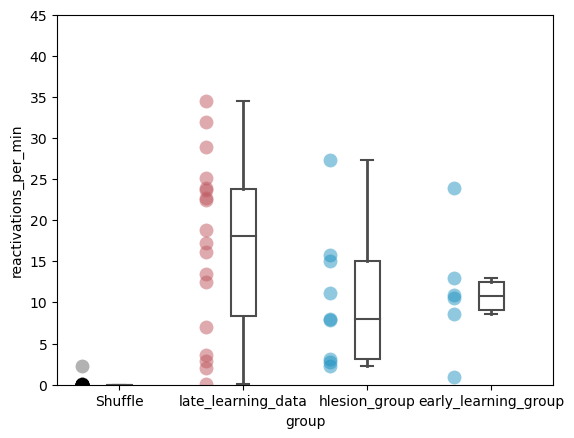

In [36]:
# load shuffle data:
shuffle_path = r"Z:\projects\sequence_squad\organised_data\ppseq_data\output_data\striatum\New_post_sleep_shuffle\\"
shuffle_reactivations_per_min = []
for run_index,pp_file in enumerate(os.listdir(shuffle_path)):
    if '_'.join(pp_file.split('_')[0:3]) in mirs:
        current_mouse_path = shuffle_path + pp_file + '\\analysis_output'
        for file in os.listdir(current_mouse_path):
            if 'chunk' in file:
                current_data_path = current_mouse_path + '\\' + file + '\\'
                chunk_time = np.load(current_data_path + 'chunk_time_interval.npy')
                data = pd.read_csv(current_data_path + 'filtered_replay_clusters_df.csv')
                reactivations_found = len(data)
                mins = np.diff(chunk_time)[0]/60
                shuffle_reactivations_per_min += [reactivations_found/mins]
                     
# split by group
e_reactivations_per_min = np.array(reactivations_per_min)[np.array(expert) == 1]
hl_reactivations_per_min = np.array(reactivations_per_min)[np.array(hlesion) == 1]
l_reactivations_per_min = np.array(reactivations_per_min)[np.array(learning) == 1]

# Create figure and axes
fig, ax = plt.subplots()


# Plot non shuffle data scatter plot
ax.plot(np.ones(len(e_reactivations_per_min))*0.7, e_reactivations_per_min, 'o',color=red, alpha=0.5, label='Data', markeredgewidth = 0, markersize = 10)

ax.plot(np.ones(len(hl_reactivations_per_min))*1.7, hl_reactivations_per_min, 'o',color=blue, alpha=0.5, label='Data', markeredgewidth = 0, markersize = 10)

ax.plot(np.ones(len(l_reactivations_per_min))*2.7, l_reactivations_per_min, 'o',color=blue, alpha=0.5, label='Data', markeredgewidth = 0, markersize = 10)

# Plot shuffle data plot
ax.plot(np.ones(len(shuffle_reactivations_per_min))*-0.3, shuffle_reactivations_per_min, 'o',color='k', alpha=0.3, label='Data', markeredgewidth = 0, markersize = 10)


groups =  ['Shuffle'] * len(shuffle_reactivations_per_min) + ['late_learning_data'] * len(e_reactivations_per_min) + ['hlesion_group'] * len(hl_reactivations_per_min) + ['early_learning_group'] * len(l_reactivations_per_min)
dat =  shuffle_reactivations_per_min+list(e_reactivations_per_min) + list(hl_reactivations_per_min) + list(l_reactivations_per_min)

plt_df = pd.DataFrame({'group':groups,'reactivations_per_min': dat })
ax=sns.boxplot( y = 'reactivations_per_min', x = 'group', data = plt_df, color = 'blue', width = .2, zorder = 10,\
            showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
            showfliers=False, whiskerprops = {'linewidth':2, "zorder":10},\
               saturation = 1, orient = 'v',ax = ax)

ax.set_ylim(0,45)

SaveFig('reactivation_per_min.pdf',out_path)

In [19]:
## STATS

scipy.stats.shapiro(hl_reactivations_per_min)
print(scipy.stats.ttest_ind(e_reactivations_per_min,hl_reactivations_per_min))

NameError: name 'scipy' is not defined

# pos/negative prediction error 

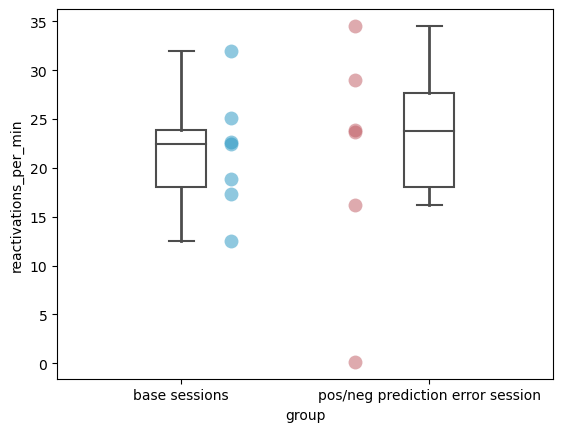

In [37]:
### quick analysis to test whether the pos/neg prediction error manipulations had an effect
ppe = ['136_1_4','149_1_2','178_1_2','178_1_7','178_2_2']
npe = ['136_1_3','149_1_3','178_1_3','178_1_8','178_2_3']
base = ['136_1_2','149_1_1','149_1_4','178_1_1','178_1_4','178_1_5','178_1_6','178_1_9','178_2_1','178_2_4']
def find_indices(array, items):
    return [index for index, item in enumerate(array) if item in items]
PPEs = []
NPEs = []
BASE = []
ppe_inds = find_indices(np.array(mirs)[np.array(expert) == 1],ppe)
npe_inds = find_indices(np.array(mirs)[np.array(expert) == 1],npe)
base_inds = find_indices(np.array(mirs)[np.array(expert) == 1],base)

PPEs += list((np.array(reactivations_per_min)[np.array(expert) == 1])[ppe_inds])
NPEs += list((np.array(reactivations_per_min)[np.array(expert) == 1])[npe_inds])
BASE += list((np.array(reactivations_per_min)[np.array(expert) == 1])[base_inds])

ppe_inds = find_indices(np.array(mirs)[np.array(hlesion) == 1],ppe)
npe_inds = find_indices(np.array(mirs)[np.array(hlesion) == 1],npe)
base_inds = find_indices(np.array(mirs)[np.array(hlesion) == 1],base)

PPEs += list((np.array(reactivations_per_min)[np.array(hlesion) == 1])[ppe_inds])
NPEs += list((np.array(reactivations_per_min)[np.array(hlesion) == 1])[npe_inds])
BASE += list((np.array(reactivations_per_min)[np.array(hlesion) == 1])[base_inds])

ppe_inds = find_indices(np.array(mirs)[np.array(learning) == 1],ppe)
npe_inds = find_indices(np.array(mirs)[np.array(learning) == 1],npe)
base_inds = find_indices(np.array(mirs)[np.array(learning) == 1],base)

PPEs += list((np.array(reactivations_per_min)[np.array(learning) == 1])[ppe_inds])
NPEs += list((np.array(reactivations_per_min)[np.array(learning) == 1])[npe_inds])
BASE += list((np.array(reactivations_per_min)[np.array(learning) == 1])[base_inds])

fig, ax = plt.subplots()
ax.plot(np.ones(len(BASE))*0.2, BASE, 'o',color=blue, alpha=0.5, label='Data', markeredgewidth = 0, markersize = 10)
ax.plot(np.ones(len(PPEs+NPEs))*0.7, PPEs+NPEs, 'o',color=red, alpha=0.5, label='Data', markeredgewidth = 0, markersize = 10)
groups = ['base sessions'] * len(BASE) + ['pos/neg prediction error session'] * len(PPEs+NPEs) 

dat =   BASE+PPEs+NPEs
plt_df = pd.DataFrame({'group':groups,'reactivations_per_min': dat })
ax=sns.boxplot( y = 'reactivations_per_min', x = 'group', data = plt_df, color = 'grey', width = .2, zorder = 10,\
            showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
            showfliers=False, whiskerprops = {'linewidth':2, "zorder":10},\
               saturation = 1, orient = 'v',ax = ax)

SaveFig('prediction_error_replay.pdf',out_path)

# Decay from sleep onset

In [83]:
### firing rate over time:
# loop across all mouse files

e_all_av_spike_rate_hz = []
e_all_bin_mins = []
hl_all_av_spike_rate_hz = []
hl_all_bin_mins = []
l_all_av_spike_rate_hz = []
l_all_bin_mins = []

dat_pth = r"Z:\projects\sequence_squad\organised_data\animals\\"

for run_index,pp_file in enumerate(os.listdir(dat_path)):
    if not 'sleep_time_points' in pp_file:
        # current mouse
        mouse = '_'.join(pp_file.split('_')[0:3])
        
        print(mouse)
        
        if not mouse in ignore_list:

            # load in sleep start time 
            current_sleep_start = sleep_start[mouse]
            params_file = dat_path + pp_file + r'\trainingData\\' + 'params_' + mouse + '.json'
            with open(params_file, 'r') as file:
                params = json.load(file)
            time_spans = params['time_span']
            
            mir = 'EJT' + mouse.split('_')[0] + '_implant' + mouse.split('_')[1]
            for item in os.listdir(dat_pth+mir):
                if 'cording' + mouse.split('_')[-1] in item:
                    current_path = os.path.join(dat_pth + mir,item) + r'/ephys/non_curated_spikes/multiunits_df.csv'

            spikes_df = pd.read_csv(current_path)

            all_spikes = spikes_df[spikes_df.Region == 'striatum'].Spike_times.values

            import ast
            all_spikes_merged = []
            for neuron in all_spikes:
                all_spikes_merged += ast.literal_eval(neuron)


            spikes_that_matter = np.array(all_spikes_merged)[(all_spikes_merged >= current_sleep_start)*(all_spikes_merged <= (current_sleep_start+(160*60)))]

            spikes_that_matter

            ### pull out average spikes per bin time 

            # Duration of observation period (in seconds)
            observation_period_sec = max(spikes_that_matter) - min(spikes_that_matter)

            # Convert observation period to minutes
            observation_period_min = observation_period_sec / 60.0

            # Calculate number of bins (one for each minute)
            num_bins = int(np.ceil(observation_period_min))

            # Count spikes for each neuron in each minute bin
            bin_edges = np.linspace(min(spikes_that_matter), max(spikes_that_matter), num_bins + 1)
            spike_counts, _ = np.histogram(spikes_that_matter, bins=bin_edges)

            # Calculate average spike rate in Hz
            av_spike_rate_hz = (spike_counts/len(spikes_df[spikes_df.Region == 'striatum']))/60

            bin_mins = np.linspace(0,observation_period_sec/60, num_bins).tolist()

            if mouse in expert_mice:
                e_all_av_spike_rate_hz += [av_spike_rate_hz]
                e_all_bin_mins += [bin_mins]
            elif mouse in hlesion_mice:
                hl_all_av_spike_rate_hz += [av_spike_rate_hz]
                hl_all_bin_mins += [bin_mins]
            elif mouse in learning_mice:
                l_all_av_spike_rate_hz += [av_spike_rate_hz]
                l_all_bin_mins += [bin_mins]
                

# np.save(r"C:\Users\Emmett\Documents\REPLAY_PAPER\data\f4\av-firing_rates.npy",np.array(y))
# np.save(r"C:\Users\Emmett\Documents\REPLAY_PAPER\data\f4\all-bin-mins.npy",np.array(x))

136_1_3
136_1_4
148_2_2
149_1_1
178_1_4
178_1_5
178_1_6
178_1_7
178_1_8
178_1_9
178_2_1
178_2_2
178_2_3
178_2_4
238_1_4
238_1_5
238_1_6
255_1_1
255_1_2
255_1_4
256_1_1
262_1_1
262_1_2
262_1_4
262_1_5
262_1_6
268_1_2
269_1_1
269_1_2
269_1_3
269_1_4
269_1_5
269_1_6
269_1_7
270_1_1
270_1_3
270_1_5
270_1_6


In [39]:
import scipy 
def bin_data(x, y, n_bins):
   # Create bins for y values
    bin_edges = np.linspace(min(x), max(x), n_bins)
    
    # Calculate bin centers
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Assign each data point to the closest bin
    bin_indices = np.argmin(np.abs(np.subtract.outer(x, bin_centers)), axis=1)
    
    # Initialize arrays to store binned data
    binned_y = [[] for _ in range(n_bins)]
    
    # Populate binned arrays
    for i in range(len(x)):
        bin_idx = bin_indices[i]
        binned_y[bin_idx].append(y[i])
    
    # Calculate mean and SEM for each bin
    bin_means = np.array([np.mean(b) for b in binned_y])
    bin_sems = np.array([scipy.stats.sem(b) for b in binned_y])
    
    return bin_means, bin_sems,bin_edges,binned_y

PLOT 2:
Group 1 (red):
model p value (f statistic) = 
1.7832437467441124e-07
r2 = 
0.6025041609972822
Group 2 (blue):
model p value (f statistic) = 
1.6973307778914742e-07
r2 = 
0.8467034651496145
Group 3 (blue):
model p value (f statistic) = 
0.003318459135489695
r2 = 
0.6350247337407418


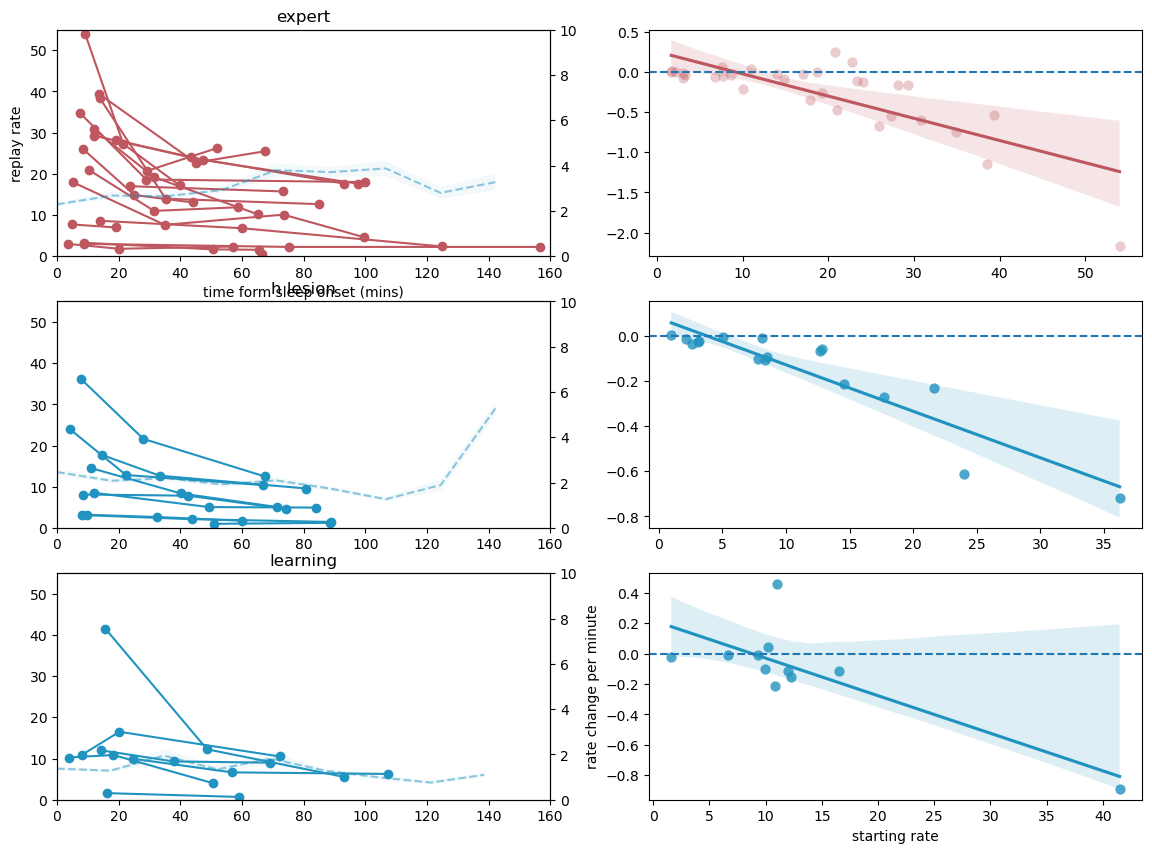

<Figure size 640x480 with 0 Axes>

In [62]:
times = []
rates = []
hl_times = []
hl_rates = []
l_times = []
l_rates = []


fig, ((ax, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2,figsize=(14, 10))
ax.set_ylabel('replay rate')
ax.set_xlabel('time form sleep onset (mins)')

ax.set_title('expert')
ax3.set_title('h lesion')
ax5.set_title('learning')



x = [item for sublist in e_all_bin_mins for item in sublist]
y = [item for sublist in e_all_av_spike_rate_hz for item in sublist]
num_bins = 10
means,sems,bins,binned_x = bin_data(x,y,num_bins)
# Create a second y-axis for the second subplot
ax_2 = ax.twinx()    
ax_2.plot(bins,means,'--', c = blue,alpha = 0.5)
upper = np.array(means) + np.array(sems)
lower = np.array(means) - np.array(sems)
ax_2.fill_between(sorted(bins),(lower),(upper),
    alpha=0.05, edgecolor='None', facecolor=blue,
    linewidth=1, linestyle='dashdot', antialiased=True)
ax_2.set_ylim(0,10)

x = [item for sublist in hl_all_bin_mins for item in sublist]
y = [item for sublist in hl_all_av_spike_rate_hz for item in sublist]
num_bins = 10
means,sems,bins,binned_x = bin_data(x,y,num_bins)
# Create a second y-axis for the second subplot
ax3_2 = ax3.twinx()    
ax3_2.plot(bins,means,'--', c = blue,alpha = 0.5)
upper = np.array(means) + np.array(sems)
lower = np.array(means) - np.array(sems)
ax3_2.fill_between(sorted(bins),(lower),(upper),
    alpha=0.05, edgecolor='None', facecolor=blue,
    linewidth=1, linestyle='dashdot', antialiased=True)
ax3_2.set_ylim(0,10)

x = [item for sublist in l_all_bin_mins for item in sublist]
y = [item for sublist in l_all_av_spike_rate_hz for item in sublist]
num_bins = 10
means,sems,bins,binned_x = bin_data(x,y,num_bins)
# Create a second y-axis for the second subplot
ax5_2 = ax5.twinx()    
ax5_2.plot(bins,means,'--', c = blue,alpha = 0.5)
upper = np.array(means) + np.array(sems)
lower = np.array(means) - np.array(sems)
ax5_2.fill_between(sorted(bins),(lower),(upper),
    alpha=0.05, edgecolor='None', facecolor=blue,
    linewidth=1, linestyle='dashdot', antialiased=True)
ax5_2.set_ylim(0,10)


AA_rate = []
AA_post_so_time = []
for i,item in enumerate(event_rate_binned):
    across_chunks_x = []
    across_chunks_y = []
    for e,chunk_item in enumerate(item):
        x = er_bins_relative_to_so[i][e]
        y = chunk_item
        
#         if expert[i] == 1:
#             ax.plot(x,y, c = red, alpha = 0.1)
#         elif hlesion[i] == 1:
#             ax3.plot(x,y, c = blue, alpha = 0.1)  
#         elif learning[i] == 1:
#             ax5.plot(x,y, c = blue, alpha = 0.1)
            
        #mean for each time series across chunks
        across_chunks_x += [np.mean(er_bins_relative_to_so[i][e])]
        across_chunks_y += [np.mean(chunk_item)]
        
    AA_rate+=[across_chunks_y]
    AA_post_so_time+=[across_chunks_x]
        
    if expert[i] == 1:
        ax.plot(across_chunks_x,across_chunks_y, '-o',c = red, alpha = 1)
    elif hlesion[i] == 1:
        ax3.plot(across_chunks_x,across_chunks_y, '-o',c = blue, alpha = 1) 
    elif learning[i] == 1:
        ax5.plot(across_chunks_x,across_chunks_y, '-o',c = blue, alpha = 1)


    
    # save out stuff for plot 2
    rate_change_per_min = np.diff(across_chunks_y)/np.diff(across_chunks_x)
    if expert[i] == 1:
        times += across_chunks_y[0:-1]
        rates += list(rate_change_per_min)
    elif hlesion[i] == 1:
        hl_times += across_chunks_y[0:-1]
        hl_rates += list(rate_change_per_min)
    elif learning[i] == 1:
        l_times += across_chunks_y[0:-1]
        l_rates += list(rate_change_per_min)
    
               
sns.regplot(x=times, y=rates, ax = ax2, color = red,scatter_kws={'s': 55, 'alpha': 0.3,'linewidths': 0})
sns.regplot(x=hl_times, y=hl_rates, ax = ax4, color = blue,scatter_kws={'s': 55, 'alpha': 0.8,'linewidths': 0})
sns.regplot(x=l_times, y=l_rates, ax = ax6, color = blue,scatter_kws={'s': 55, 'alpha': 0.8,'linewidths': 0})
ax6.set_xlabel('starting rate')
ax6.set_ylabel('rate change per minute')
ax2.axhline(0,0,ls ='--')
ax4.axhline(0,0,ls ='--')
ax6.axhline(0,0,ls ='--')


######################
## stats        
        
import statsmodels.regression.linear_model as sm
group1_data = {'x': times, 'y': rates}
group2_data = {'x': hl_times, 'y': hl_rates}
group3_data = {'x': l_times, 'y': l_rates}

df1 = pd.DataFrame(group1_data)
df2 = pd.DataFrame(group2_data)
df3 = pd.DataFrame(group3_data)

# Fit linear regression for Group 1
model_group1 = sm.OLS.from_formula('y ~ x', data=df1).fit()

# Fit linear regression for Group 2
model_group2 = sm.OLS.from_formula('y ~ x', data=df2).fit()

# Fit linear regression for Group 3
model_group3 = sm.OLS.from_formula('y ~ x', data=df3).fit()


print('PLOT 2:')
# Print the summary of each model
print("Group 1 (red):")
# print(model_group1.summary())
print('model p value (f statistic) = ')
print(model_group1.f_pvalue)
print('r2 = ')
print(model_group1.rsquared)

print("Group 2 (blue):")
# print(model_group1.summary())
print('model p value (f statistic) = ')
print(model_group2.f_pvalue)
print('r2 = ')
print(model_group2.rsquared)

print("Group 3 (blue):")
# print(model_group1.summary())
print('model p value (f statistic) = ')
print(model_group3.f_pvalue)
print('r2 = ')
print(model_group3.rsquared)

ax.set_ylim(0,55)
ax3.set_ylim(0,55)
ax5.set_ylim(0,55)

ax.set_xlim(0,160)
ax3.set_xlim(0,160)
ax5.set_xlim(0,160)

# ax2.set_ylim(-1,30)
# ax4.set_ylim(-1,0.2)
# ax6.set_ylim(-1,0.2)

# ax2.set_xlim(0,30)
# ax4.set_xlim(0,30)
# ax6.set_xlim(0,30)


SaveFig('decay_rate.pdf','D:\\')



plt.tight_layout()


In [82]:
# for revisions:

In [81]:
early_rates = []
for i,item in enumerate(AA_post_so_time):
    chunk_rates =[]
    for ind,time_ in enumerate(item):
        if time_ < 20:
            chunk_rates += [AA_rate[i][ind]]
            
    early_rates +=[np.mean(chunk_rates)] 
            

outframe = pd.DataFrame({'mirs':mirs,'reactivations_per_min':early_rates,'expert': expert, 'hlesion': hlesion, 'learning':learning})

outframe.to_csv(r"Z:\projects\sequence_squad\revision_data\emmett_revisions\replay_rate_old_data\\replay_rates.csv")


# save out firing rates for revision plots

In [115]:
dat_pth = r"Z:\projects\sequence_squad\organised_data\animals\\"

mirs_ = []
AA_average_firing_rates  = []
for run_index,pp_file in enumerate(os.listdir(dat_path)):
    if not 'sleep_time_points' in pp_file:
        # current mouse
        mouse = '_'.join(pp_file.split('_')[0:3])
        print(mouse)
        
        if not mouse in ignore_list:

            # load in sleep start time 
            if mouse in sleep_start:
                current_sleep_start = sleep_start[mouse]
            else:
                current_sleep_start = 0
            params_file = dat_path + pp_file + r'\trainingData\\' + 'params_' + mouse + '.json'
            with open(params_file, 'r') as file:
                params = json.load(file)
            time_spans = params['time_span']
            
            mir = 'EJT' + mouse.split('_')[0] + '_implant' + mouse.split('_')[1]
            for item in os.listdir(dat_pth+mir):
                if 'cording' + mouse.split('_')[-1] in item:
                    current_path = os.path.join(dat_pth + mir,item) + r'/ephys/non_curated_spikes/multiunits_df.csv'

            spikes_df = pd.read_csv(current_path)

            all_spikes = spikes_df[spikes_df.Region == 'striatum'].Spike_times.values

            import ast
            all_spikes_merged = []
            for neuron in all_spikes:
                all_spikes_merged += ast.literal_eval(neuron)


            spikes_that_matter = np.array(all_spikes_merged)[(all_spikes_merged >= current_sleep_start)*(all_spikes_merged <= (current_sleep_start+(160*60)))]

            neurons = len(all_spikes)
            duration = np.round(max(spikes_that_matter)) - current_sleep_start
            average_firing_rate = (len(spikes_that_matter)/neurons)/duration
            AA_average_firing_rates += [average_firing_rate]
            mirs_ += [mouse]
            
outframe = pd.DataFrame({'mirs':mirs_,'average_firing_rates':AA_average_firing_rates})
outframe.to_csv(r"Z:\projects\sequence_squad\revision_data\emmett_revisions\replay_rate_old_data\\average_firing_rates.csv")


136_1_3
136_1_4
148_2_2
149_1_1
178_1_4
178_1_5
178_1_6
178_1_7
178_1_8
178_1_9
178_2_1
178_2_2
178_2_3
178_2_4
238_1_4
238_1_5
238_1_6
255_1_1
255_1_2
255_1_4
256_1_1
262_1_1
262_1_2
262_1_4
262_1_5
262_1_6
268_1_2
269_1_1
269_1_2
269_1_3
269_1_4
269_1_5
269_1_6
269_1_7
270_1_1
270_1_3
270_1_5
270_1_6


In [ ]:
presleep_trig_times = pd.read_csv(r"Z:\projects\sequence_squad\organised_data\animals\EJT178_implant2\recording1_04-04-2022\behav_sync\1_pre_sleep\Presleep_Ephys_Camera_sync.csv")


Z:\projects\sequence_squad\organised_data\animals\\EJT270_implant1\recording6_19-05-2023


In [161]:
start

23.66847327797387

'270_implant1'

'270'

In [177]:
dat_pth = r"Z:\projects\sequence_squad\organised_data\animals\\"

mirs_ = []
AA_average_firing_rates  = []
for run_index,pp_file in enumerate(os.listdir(dat_path)):
    if not 'sleep_time_points' in pp_file:
        # current mouse
        mouse = '_'.join(pp_file.split('_')[0:3])
        print(mouse)
        
        if not mouse in ignore_list:
            
            start = None
            end = None
            continue_ = False
            for dirs in os.listdir(dat_pth):
                if mouse.split('_')[0] + '_implant' + mouse.split('_')[1] in dirs:
                    current_path = os.path.join(dat_pth,dirs)
                    for recording in os.listdir(current_path):
                        if 'recording' + mouse.split('_')[-1] in recording:
                            current_path = os.path.join(current_path,recording)
                            print(current_path)
                            if os.path.isfile(current_path + '//behav_sync/1_pre_sleep/Presleep_Ephys_Camera_sync.csv'):
                                
                                presleep_trig_times = pd.read_csv(current_path + '//behav_sync/1_pre_sleep/Presleep_Ephys_Camera_sync.csv' )

                                start = presleep_trig_times.Camera_time_Ephys_Aligned.values[0]
                                end = presleep_trig_times.Camera_time_Ephys_Aligned.values[-1]
                                continue_ = True

            if continue_ == True:
                mir = 'EJT' + mouse.split('_')[0] + '_implant' + mouse.split('_')[1]
                for item in os.listdir(dat_pth+mir):
                    if 'cording' + mouse.split('_')[-1] in item:
                        current_path = os.path.join(dat_pth + mir,item) + r'/ephys/non_curated_spikes/multiunits_df.csv'

                spikes_df = pd.read_csv(current_path)

                all_spikes = spikes_df[spikes_df.Region == 'striatum'].Spike_times.values

                import ast
                all_spikes_merged = []
                for neuron in all_spikes:
                    all_spikes_merged += ast.literal_eval(neuron)

                spikes_that_matter = np.array(all_spikes_merged)[(all_spikes_merged >= start)*(all_spikes_merged <= end)]

                neurons = len(all_spikes)
                duration = end - start
                average_firing_rate = (len(spikes_that_matter)/neurons)/duration
                AA_average_firing_rates += [average_firing_rate]
                mirs_ += [mouse]

            
outframe = pd.DataFrame({'mirs':mirs_,'average_firing_rates':AA_average_firing_rates})
outframe.to_csv(r"Z:\projects\sequence_squad\revision_data\emmett_revisions\pre_sleep_processed_data\\presleep_average_firing_rates.csv")


136_1_3
Z:\projects\sequence_squad\organised_data\animals\\EJT136_implant1\recording3_11-11-2021
136_1_4
Z:\projects\sequence_squad\organised_data\animals\\EJT136_implant1\recording4_12-11-2021
148_2_2
Z:\projects\sequence_squad\organised_data\animals\\EJT148_implant2\recording2_19-10-2020
149_1_1
Z:\projects\sequence_squad\organised_data\animals\\EJT149_implant1\recording1_16-11-2021
178_1_4
Z:\projects\sequence_squad\organised_data\animals\\EJT178_implant1\recording4_18-03-2022
178_1_5
Z:\projects\sequence_squad\organised_data\animals\\EJT178_implant1\recording5_21-03-2022
178_1_6
Z:\projects\sequence_squad\organised_data\animals\\EJT178_implant1\recording6_29-03-2022
178_1_7
Z:\projects\sequence_squad\organised_data\animals\\EJT178_implant1\recording7_30-03-2022
178_1_8
Z:\projects\sequence_squad\organised_data\animals\\EJT178_implant1\recording8_31-03-2022
178_1_9
Z:\projects\sequence_squad\organised_data\animals\\EJT178_implant1\recording9_01-04-2022
178_2_1
Z:\projects\sequence_s

In [174]:
outframe

,mirs,average_firing_rates


In [176]:
os.path.isfile(current_path + '//behav_sync/1_pre_sleep/Presleep_Ephys_Camera_sync.csv')
                                

True

PLOT 2:
Group 1 (red):
model p value (f statistic) = 
1.7832437467441124e-07
r2 = 
0.6025041609972822
Group 2 (blue):
model p value (f statistic) = 
1.6973307778914742e-07
r2 = 
0.8467034651496145
Group 3 (blue):
model p value (f statistic) = 
0.003318459135489695
r2 = 
0.6350247337407418


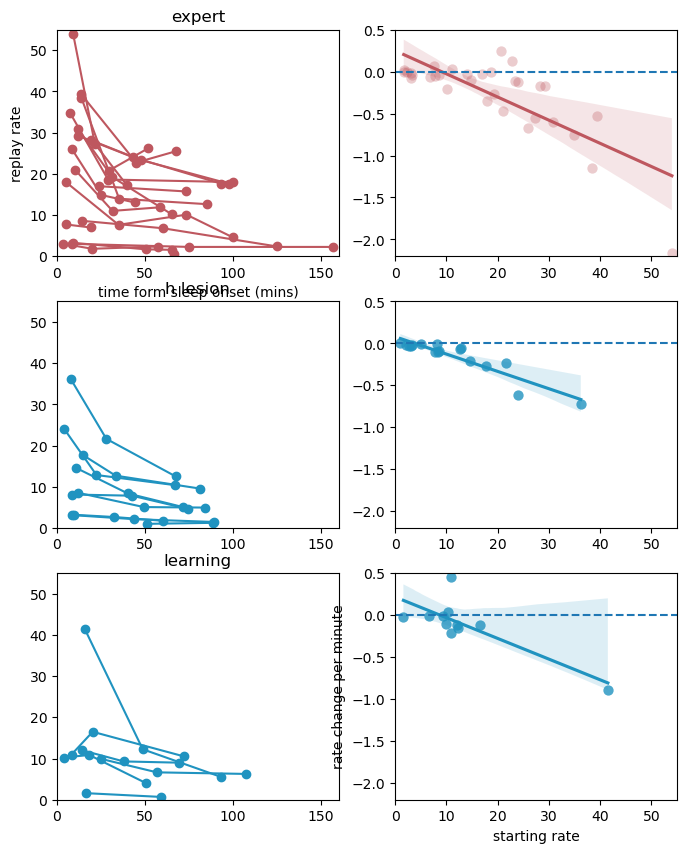

<Figure size 640x480 with 0 Axes>

In [41]:
times = []
rates = []
hl_times = []
hl_rates = []
l_times = []
l_rates = []

x_ = []
y_ = []


fig, ((ax, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2,figsize=(8, 10))
ax.set_ylabel('replay rate')
ax.set_xlabel('time form sleep onset (mins)')

ax.set_title('expert')
ax3.set_title('h lesion')
ax5.set_title('learning')

for i,item in enumerate(event_rate_binned):
    across_chunks_x = []
    across_chunks_y = []
    for e,chunk_item in enumerate(item):
        x = er_bins_relative_to_so[i][e]
        y = chunk_item
        
#         if expert[i] == 1:
#             ax.plot(x,y, c = red, alpha = 0.1)
#         elif hlesion[i] == 1:
#             ax3.plot(x,y, c = blue, alpha = 0.1)  
#         elif learning[i] == 1:
#             ax5.plot(x,y, c = blue, alpha = 0.1)
            
        #mean for each time series across chunks
        across_chunks_x += [np.mean(er_bins_relative_to_so[i][e])]
        across_chunks_y += [np.mean(chunk_item)]
        
    if expert[i] == 1:
        ax.plot(across_chunks_x,across_chunks_y, '-o',c = red, alpha = 1)
        x_+=across_chunks_x
        y_+=across_chunks_y
    elif hlesion[i] == 1:
        ax3.plot(across_chunks_x,across_chunks_y, '-o',c = blue, alpha = 1) 
    elif learning[i] == 1:
        ax5.plot(across_chunks_x,across_chunks_y, '-o',c = blue, alpha = 1)


    
    # save out stuff for plot 2
    rate_change_per_min = np.diff(across_chunks_y)/np.diff(across_chunks_x)
    if expert[i] == 1:
        times += across_chunks_y[0:-1]
        rates += list(rate_change_per_min)
    elif hlesion[i] == 1:
        hl_times += across_chunks_y[0:-1]
        hl_rates += list(rate_change_per_min)
    elif learning[i] == 1:
        l_times += across_chunks_y[0:-1]
        l_rates += list(rate_change_per_min)
    
               
sns.regplot(x=times, y=rates, ax = ax2, color = red,scatter_kws={'s': 55, 'alpha': 0.3,'linewidths': 0})
sns.regplot(x=hl_times, y=hl_rates, ax = ax4, color = blue,scatter_kws={'s': 55, 'alpha': 0.8,'linewidths': 0})
sns.regplot(x=l_times, y=l_rates, ax = ax6, color = blue,scatter_kws={'s': 55, 'alpha': 0.8,'linewidths': 0})
ax6.set_xlabel('starting rate')
ax6.set_ylabel('rate change per minute')
ax2.axhline(0,0,ls ='--')
ax4.axhline(0,0,ls ='--')
ax6.axhline(0,0,ls ='--')


######################
## stats        
        
import statsmodels.regression.linear_model as sm
group1_data = {'x': times, 'y': rates}
group2_data = {'x': hl_times, 'y': hl_rates}
group3_data = {'x': l_times, 'y': l_rates}

df1 = pd.DataFrame(group1_data)
df2 = pd.DataFrame(group2_data)
df3 = pd.DataFrame(group3_data)

# Fit linear regression for Group 1
model_group1 = sm.OLS.from_formula('y ~ x', data=df1).fit()

# Fit linear regression for Group 2
model_group2 = sm.OLS.from_formula('y ~ x', data=df2).fit()

# Fit linear regression for Group 3
model_group3 = sm.OLS.from_formula('y ~ x', data=df3).fit()


print('PLOT 2:')
# Print the summary of each model
print("Group 1 (red):")
# print(model_group1.summary())
print('model p value (f statistic) = ')
print(model_group1.f_pvalue)
print('r2 = ')
print(model_group1.rsquared)

print("Group 2 (blue):")
# print(model_group1.summary())
print('model p value (f statistic) = ')
print(model_group2.f_pvalue)
print('r2 = ')
print(model_group2.rsquared)

print("Group 3 (blue):")
# print(model_group1.summary())
print('model p value (f statistic) = ')
print(model_group3.f_pvalue)
print('r2 = ')
print(model_group3.rsquared)

ax.set_ylim(0,55)
ax3.set_ylim(0,55)
ax5.set_ylim(0,55)

ax.set_xlim(0,160)
ax3.set_xlim(0,160)
ax5.set_xlim(0,160)


ax2.set_ylim(-2.2,0.5)
ax4.set_ylim(-2.2,0.5)
ax6.set_ylim(-2.2,0.5)

ax2.set_xlim(0,55)
ax4.set_xlim(0,55)
ax6.set_xlim(0,55)


SaveFig('decay_rate_shape2.pdf',out_path)



plt.tight_layout()


In [12]:
### effect of decay - significance

import statsmodels.api as sm

# Convert the data to a pandas DataFrame
data = pd.DataFrame({'x': x_, 'y': y_})

# Add a constant term to the independent variable
data = sm.add_constant(data)

# Fit the regression model
model = sm.OLS(data['y'], data[['const', 'x']]).fit()

# Print the summary statistics
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.127
Method:                 Least Squares   F-statistic:                     8.108
Date:                Wed, 15 May 2024   Prob (F-statistic):            0.00647
Time:                        12:01:57   Log-Likelihood:                -189.83
No. Observations:                  50   AIC:                             383.7
Df Residuals:                      48   BIC:                             387.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         21.5607      2.527      8.532      0.0

In [28]:
import statsmodels.api as sm
from statsmodels.multivariate.manova import MANOVA


# Combine the data into one DataFrame
data = pd.concat([df1, df3], axis=0)

# Create a grouping variable
groups = np.array(['expert'] * len(df1) + ['lesion'] * len(df3))

# Perform MANOVA
manova = MANOVA.from_formula('x + y ~ groups', data=data)

# Print the MANOVA results
print(manova.mv_test())

                 Multivariate linear model
                                                            
------------------------------------------------------------
       Intercept        Value  Num DF  Den DF F Value Pr > F
------------------------------------------------------------
          Wilks' lambda 0.2950 2.0000 40.0000 47.7969 0.0000
         Pillai's trace 0.7050 2.0000 40.0000 47.7969 0.0000
 Hotelling-Lawley trace 2.3898 2.0000 40.0000 47.7969 0.0000
    Roy's greatest root 2.3898 2.0000 40.0000 47.7969 0.0000
------------------------------------------------------------
                                                            
------------------------------------------------------------
         groups         Value  Num DF  Den DF F Value Pr > F
------------------------------------------------------------
          Wilks' lambda 0.9613 2.0000 40.0000  0.8058 0.4539
         Pillai's trace 0.0387 2.0000 40.0000  0.8058 0.4539
 Hotelling-Lawley trace 0.0403 2.0000 40.0

32

# replay event length

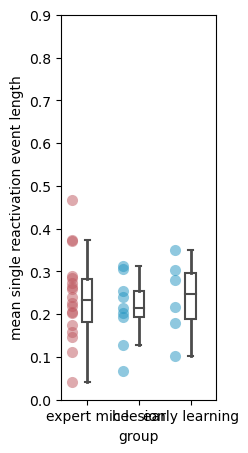

In [24]:
### this isnt great, clealry I am filtering my replay wrong, need to change this in my origional preprocessing script! 


e_mean_lens = []
hl_mean_lens = [] 
l_mean_lens = [] 
for index,events in enumerate(event_lens):
    if expert[index] == 1:
        e_mean_lens += [np.mean(events)]
    elif hlesion[index] == 1:
        hl_mean_lens += [np.mean(events)]
    elif learning[index] == 1:
        l_mean_lens += [np.mean(events)]
        
    

# Create figure and axes
fig, ax= plt.subplots(1, 1,figsize=(2, 5))

# Plot non shuffle data scatter plot
ax.plot(np.ones(len(e_mean_lens))*-0.3, e_mean_lens, 'o',color=red, alpha=0.5, label='Data', markeredgewidth = 0, markersize = 8)
ax.plot(np.ones(len(hl_mean_lens))*0.7, hl_mean_lens, 'o',color=blue, alpha=0.5, label='Data',markeredgewidth = 0, markersize = 8)
ax.plot(np.ones(len(l_mean_lens))*1.7, l_mean_lens, 'o',color=blue, alpha=0.5, label='Data',markeredgewidth = 0, markersize = 8)


plt_df = pd.DataFrame({'group':['expert mice']*len(e_mean_lens) + ['h lesion']*len(hl_mean_lens)+['early learning']*len(l_mean_lens),'mean single reactivation event length': e_mean_lens+hl_mean_lens+l_mean_lens })
ax=sns.boxplot( y = 'mean single reactivation event length', x = 'group', data = plt_df, color = 'blue', width = .2, zorder = 10,\
            showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
            showfliers=False, whiskerprops = {'linewidth':2, "zorder":10},\
               saturation = 1, orient = 'v',ax = ax)

ax.set_ylim(0,0.9)


SaveFig('event_length.pdf',out_path)

In [25]:
import numpy as np
from scipy.stats import shapiro, mannwhitneyu

# Generate sample data (replace this with your actual data)
group1 = e_mean_lens
group2 = l_mean_lens

# Shapiro-Wilk Test for Normality
stat1, p1 = shapiro(group1)
stat2, p2 = shapiro(group2)

print("Shapiro-Wilk Test for Normality:")
print("Group 1 - Statistic:", stat1, " p-value:", p1)
print("Group 2 - Statistic:", stat2, " p-value:", p2)

# Mann-Whitney U Test
stat, p = mannwhitneyu(group1, group2)
print("\nMann-Whitney U Test for Group Comparison:")
print("Statistic:", stat, " p-value:", p)

# Interpretation
alpha = 0.05
if p1 > alpha and p2 > alpha:
    print("\nBoth groups are normally distributed.")
    print("Performing parametric tests...")
    # Here you would proceed with parametric tests like t-test or ANOVA
else:
    print("\nAt least one group is not normally distributed.")
    print("Performing non-parametric tests...")
    # Here you would proceed with non-parametric tests like Mann-Whitney U test or Kruskal-Wallis test
    
    
scipy.stats.ttest_ind(group1,group2)


Shapiro-Wilk Test for Normality:
Group 1 - Statistic: 0.9777160286903381  p-value: 0.923430323600769
Group 2 - Statistic: 0.975964367389679  p-value: 0.9298299551010132

Mann-Whitney U Test for Group Comparison:
Statistic: 52.0  p-value: 0.9225385598383311

Both groups are normally distributed.
Performing parametric tests...


Ttest_indResult(statistic=0.005618411273337653, pvalue=0.9955678165240344)

# task related frequency vs others 

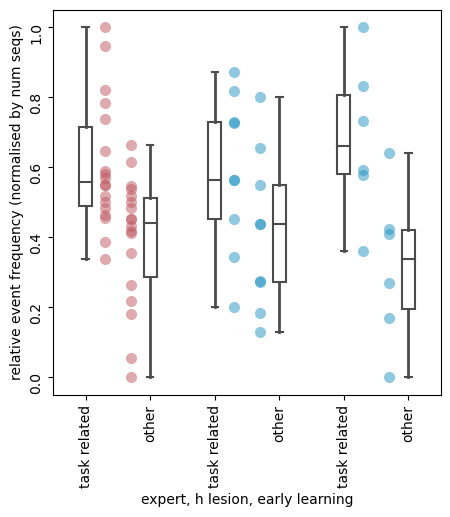

In [208]:
# seq proportions (task seqs vs others) - mean across all chunks
    
fig, ax= plt.subplots(1, 1,figsize=(5, 5))
e_rel_task_nontask = []
hl_rel_task_nontask = []
l_rel_task_nontask = []
for index,item in enumerate(rel_task_nontask):
    if expert[index] == 1:
        e_rel_task_nontask += [item]
    elif hlesion[index] == 1:
        hl_rel_task_nontask += [item]
    elif learning[index] == 1:
        l_rel_task_nontask += [item]
    
for index,item in enumerate(e_rel_task_nontask):    
    ax.plot([0.3,0.7],item, 'o', color = red, alpha = 0.5, label='Data', markeredgewidth = 0, markersize = 8)
for index,item in enumerate(hl_rel_task_nontask):    
    ax.plot([2.3,2.7],item, 'o', color = blue, alpha = 0.5 , label='Data', markeredgewidth = 0, markersize = 8)
for index,item in enumerate(l_rel_task_nontask):    
    ax.plot([4.3,4.7],item, 'o', color = blue, alpha = 0.5 , label='Data', markeredgewidth = 0, markersize = 8)
    
data = conactinate_nth_items(e_rel_task_nontask)[0] + conactinate_nth_items(e_rel_task_nontask)[1] + conactinate_nth_items(hl_rel_task_nontask)[0] + conactinate_nth_items(hl_rel_task_nontask)[1] + conactinate_nth_items(l_rel_task_nontask)[0] + conactinate_nth_items(l_rel_task_nontask)[1]
groups = (['task related'] * len(conactinate_nth_items(e_rel_task_nontask)[0])) + (['other'] * len(conactinate_nth_items(e_rel_task_nontask)[1])) +  (['task related2'] * len(conactinate_nth_items(hl_rel_task_nontask)[0])) + (['other2'] * len(conactinate_nth_items(hl_rel_task_nontask)[1])) + (['task related3'] * len(conactinate_nth_items(l_rel_task_nontask)[0])) + (['other3'] * len(conactinate_nth_items(l_rel_task_nontask)[1]))
plt_df = pd.DataFrame({'expert, h lesion, early learning':groups,'relative event frequency (normalised by num seqs)': data })
ax=sns.boxplot( y = 'relative event frequency (normalised by num seqs)', x = 'expert, h lesion, early learning', data = plt_df, color = 'blue', width = .2, zorder = 10,\
            showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
            showfliers=False, whiskerprops = {'linewidth':2, "zorder":10},\
               saturation = 1, orient = 'v',ax = ax)


labels = ['task related', 'other','task related', 'other','task related', 'other']
    
ax.set_xticks(range(0,len(labels)))
ax.set_xticklabels(labels)
ax.tick_params(axis='both', which='major', labelsize=10, rotation =90)

SaveFig('norm_R_event_type_frequency.pdf',out_path)

Statistics=0.955, p=0.742
Data looks Gaussian (fail to reject H0)
Test statistic: 1.1363684475847329
P-value: 0.2886946873932902
Statistics=0.955, p=0.742
Data looks Gaussian (fail to reject H0)
Test statistic: 1.1363684475847329
P-value: 0.2886946873932902


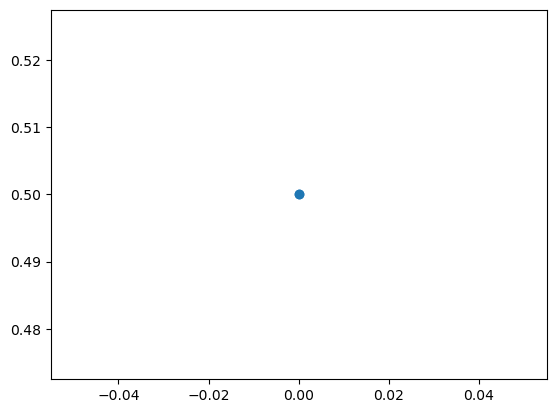

In [13]:
# test each one for significance from expected
from scipy.stats import wilcoxon

task_rel = [item[0] for item in hl_rel_task_nontask]
n_task_rel = [item[0] for item in hl_rel_task_nontask]

from scipy.stats import shapiro
from scipy.stats import ttest_1samp

expect_ps= [0.5,0.5]
for i,data in enumerate([task_rel,n_task_rel]):
    
    stat, p = shapiro(data)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    alpha = 0.05
    if p > alpha:
        print('Data looks Gaussian (fail to reject H0)')
    else:
        print('Data does not look Gaussian (reject H0)')
        
    ### all normal so use t test 
    
    # Hypothesized value (e.g., population mean or constant)
    hypothesized_value = expect_ps[i]

    # Perform one-sample t-test
    statistic, p_value = ttest_1samp(np.array(data), hypothesized_value)
    
#     statistic, p_value = wilcoxon(np.array(data) - hypothesized_value)

    # Print the test statistic and p-value
    print("Test statistic:", statistic)
    print("P-value:", p_value)

    
plt.plot(np.zeros(len(expect_ps)),expect_ps,'o')
# SaveFig('expect_perc.pdf','D:\\')

In [177]:
list1= [item[0] for item in l_rel_task_nontask]
list2= [item[1] for item in l_rel_task_nontask]


# Define your test statistic function
def test_statistic(list1, list2):
    return np.mean(list1) - np.mean(list2)

# Compute the observed test statistic
observed_statistic = test_statistic(list1, list2)

# Combine the two lists
combined_data = list1 + list2

# Number of permutations
num_permutations = 100000

# Initialize an array to store the permuted test statistics
permuted_statistics = np.zeros(num_permutations)

# Permutation test
for i in range(num_permutations):
    # Shuffle the combined data
    np.random.shuffle(combined_data)
    
    # Split the shuffled data back into two lists
    permuted_list1 = combined_data[:len(list1)]
    permuted_list2 = combined_data[len(list1):]
    
    # Compute the test statistic for the permuted data
    permuted_statistics[i] = test_statistic(permuted_list1, permuted_list2)

# Calculate the p-value
p_value = np.mean(permuted_statistics >= observed_statistic)

print("Observed Test Statistic:", observed_statistic)
print("p-value:", p_value)


Observed Test Statistic: 0.36350889265253844
p-value: 0.01134


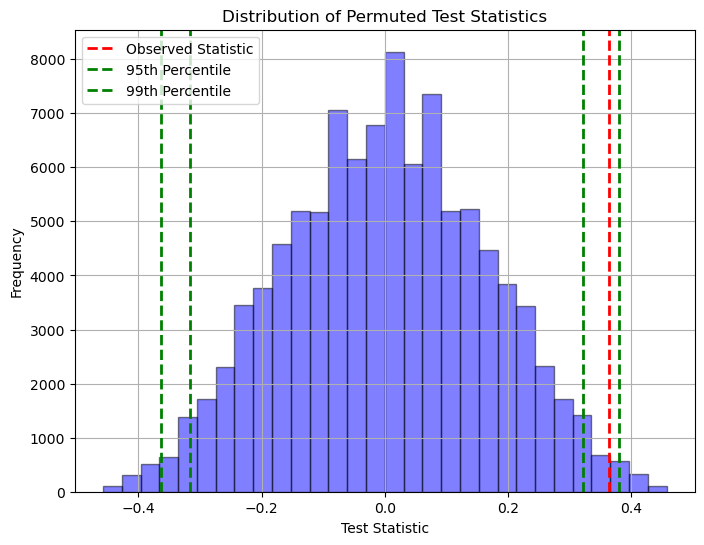

In [178]:
plt.figure(figsize=(8, 6))
plt.hist(permuted_statistics, bins=30, alpha=0.5, color='blue', edgecolor='black')
plt.axvline(observed_statistic, color='red', linestyle='dashed', linewidth=2, label='Observed Statistic')
plt.xlabel('Test Statistic')
plt.ylabel('Frequency')
plt.title('Distribution of Permuted Test Statistics')
plt.axvline(np.percentile(permuted_statistics, 97.5), color='green', linestyle='dashed', linewidth=2, label='95th Percentile')
plt.axvline(np.percentile(permuted_statistics, 2.5), color='green', linestyle='dashed', linewidth=2)
plt.axvline(np.percentile(permuted_statistics, 99), color='green', linestyle='dashed', linewidth=2, label='99th Percentile')
plt.axvline(np.percentile(permuted_statistics, 1), color='green', linestyle='dashed', linewidth=2)
plt.xlabel('Test Statistic')
plt.legend()
plt.grid(True)
plt.show()

In [180]:
np.percentile(permuted_statistics, 95)

0.2719768931082351

In [165]:
def split_lists(list_of_lists):
    first_elements = []
    second_elements = []
    
    for sublist in list_of_lists:
        first_elements.append(sublist[0])
        second_elements.append(sublist[1])
    
    return first_elements, second_elements

# Example usage:
list_of_lists = [[1, 'a'], [2, 'b'], [3, 'c']]
data1, second_elements = split_lists(e_rel_task_nontask)
data2, second_elements = split_lists(hl_rel_task_nontask)

from scipy import stats
_, p_value1 = stats.normaltest(data1)
_, p_value2 = stats.normaltest(data2)

# Step 4: Choose appropriate statistical comparison test
if p_value1 > 0.05 and p_value2 > 0.05:
    # If both datasets are normally distributed, use a parametric test like t-test
    _, p_value = stats.ttest_ind(data1, data2)
    print('parametric')
    print(p_value)
else:
    # If any dataset is not normally distributed, use a non-parametric test like Mann-Whitney U test
    _, p_value = stats.mannwhitneyu(data1, data2)
    print('non param')
    print(p_value)

parametric
0.7952314484411588


In [177]:
conactinate_nth_items(e_rel_task_nontask)[1]

[0.6630785791173305,
 0.48342541436464087,
 0.45098039215686275,
 0.5161290322580645,
 0.4317548746518106,
 0.35398230088495575,
 0.5457463884430177,
 0.18105849582172703,
 0.26329113924050634,
 0.0,
 0.4516806722689075,
 0.4188034188034188,
 0.5,
 0.5360824742268041,
 0.05319148936170213,
 0.6146788990825688,
 0.4117647058823529,
 0.21621621621621623]

In [210]:
stats.shapiro(conactinate_nth_items(e_rel_task_nontask)[1])
stats.shapiro(conactinate_nth_items(l_rel_task_nontask)[0])

# all are normal, use manova 

from statsmodels.multivariate.manova import MANOVA
data = {
    'group': ['control']*len(conactinate_nth_items(e_rel_task_nontask)[0])+['lesion']*len(conactinate_nth_items(l_rel_task_nontask)[0]),
    'TASK': conactinate_nth_items(e_rel_task_nontask)[0]+conactinate_nth_items(l_rel_task_nontask)[0],
    'NONTASK': conactinate_nth_items(e_rel_task_nontask)[1]+conactinate_nth_items(l_rel_task_nontask)[1],
}
df = pd.DataFrame(data)

# Perform MANOVA
manova = MANOVA.from_formula('TASK + NONTASK ~ group', data=df)
print(manova.mv_test())


                                Multivariate linear model
                                                                                          
------------------------------------------------------------------------------------------
       Intercept                Value         Num DF  Den DF        F Value         Pr > F
------------------------------------------------------------------------------------------
          Wilks' lambda               -0.0000 2.0000 21.0000 -7881299347898378.0000 1.0000
         Pillai's trace                1.0000 2.0000 21.0000 -7881299347898379.0000 1.0000
 Hotelling-Lawley trace -750599937895083.6250 2.0000 21.0000 -7881299347898379.0000 1.0000
    Roy's greatest root -750599937895083.6250 2.0000 21.0000 -7881299347898378.0000 1.0000
------------------------------------------------------------------------------------------
                                                                                          
--------------------------------

In [220]:
stats.shapiro(conactinate_nth_items(l_rel_task_nontask)[1])

ShapiroResult(statistic=0.9862352609634399, pvalue=0.9780290722846985)

In [217]:
conactinate_nth_items(l_rel_task_nontask)[1]

[0.408,
 0.4233576642335766,
 0.1687116564417178,
 0.6405867970660146,
 0.0,
 0.26881720430107525]

In [215]:
l_rel_task_nontask

[[0.592, 0.408],
 [0.5766423357664233, 0.4233576642335766],
 [0.8312883435582822, 0.1687116564417178],
 [0.3594132029339853, 0.6405867970660146],
 [1.0, 0.0],
 [0.7311827956989246, 0.26881720430107525]]

In [182]:
# ## stats for comparison
# data1 = [item[0] for item in e_rel_task_nontask]
# data2 = [item[0] for item in hl_rel_task_nontask]

# from scipy import stats
# _, p_value1 = stats.normaltest(data1)
# # _, p_value2 = stats.normaltest(data2)
# p_value2 = 0

# # Step 4: Choose appropriate statistical comparison test
# if p_value1 > 0.05 and p_value2 > 0.05:
#     # If both datasets are normally distributed, use a parametric test like t-test
#     _, p_value = stats.ttest_ind(data1, data2)
#     print('param')
#     print(p_value)
# else:
#     # If any dataset is not normally distributed, use a non-parametric test like Mann-Whitney U test
#     _, p_value = stats.mannwhitneyu(data1, data2)
#     print('non param')
#     print(p_value)

non param
0.8976851458261728


# coactive frequency 

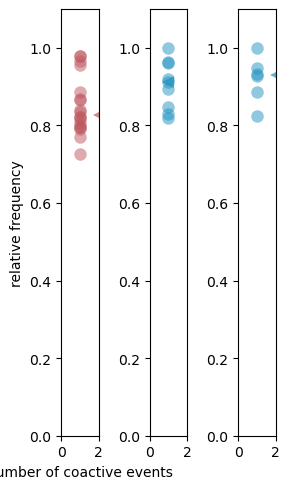

In [14]:
# plot frequency of coactive events (1,2,3,4,etc.)

fig, [ax,ax1,ax2]= plt.subplots(1, 3,figsize=(3, 5))

means = []
stds = []
x_ = []
for item in e_coactive_freqs_counts:
    ax.plot(np.ones(len(e_coactive_freqs_counts[1]))*(1),e_coactive_freqs_counts[1],'o', c = red, alpha = 0.5, markeredgewidth = 0, markersize = 9)
    x_ += [item]
    means += [np.median(e_coactive_freqs_counts[1])]
    stds += [np.std(e_coactive_freqs_counts[1])]
    break
    
means = np.array(means)[np.argsort(x_)]
stds = np.array(stds)[np.argsort(x_)]
x_ = np.array(x_)[np.argsort(x_)]

ax.plot(x_[0],means[0],'<', color = red,alpha = 0.7, markeredgewidth = 0, markersize = 9)
ax.set_xlim(0,2)
#### 2
means = []
stds = []
x_ = []
for item in hl_coactive_freqs_counts:
    ax1.plot(np.ones(len(hl_coactive_freqs_counts[1]))*(1),hl_coactive_freqs_counts[1],'o', c = blue, alpha = 0.5, markeredgewidth = 0, markersize = 9)
    x_ += [item]
    means += [np.median(hl_coactive_freqs_counts[1])]
    stds += [np.std(hl_coactive_freqs_counts[1])]
    break
    
means = np.array(means)[np.argsort(x_)]
stds = np.array(stds)[np.argsort(x_)]
x_ = np.array(x_)[np.argsort(x_)]

ax1.plot(x_[0],means[0],'<', color = blue,alpha = 0.7, markeredgewidth = 0, markersize = 9)
ax1.set_xlim(0,2)

ax1.set_ylim(0,1.1)

#### 3
means = []
stds = []
x_ = []
for item in l_coactive_freqs_counts:
    ax2.plot(np.ones(len(l_coactive_freqs_counts[1]))*(1),l_coactive_freqs_counts[1],'o', c = blue, alpha = 0.5, markeredgewidth = 0, markersize = 9)
    x_ += [item]
    means += [np.median(l_coactive_freqs_counts[1])]
    stds += [np.std(l_coactive_freqs_counts[1])]
    break
    
means = np.array(means)[np.argsort(x_)]
stds = np.array(stds)[np.argsort(x_)]
x_ = np.array(x_)[np.argsort(x_)]

ax2.plot(x_[0],means[0],'<', color = blue,alpha = 0.7, markeredgewidth = 0, markersize = 9)
ax2.set_xlim(0,2)

ax2.set_ylim(0,1.1)
    
upper = means + stds
lower = means - stds
ax.fill_between(x_,(lower),(upper),
    alpha=0.2, edgecolor='None', facecolor='red',
    linewidth=1, linestyle='dashdot', antialiased=True)

ax.set_xlabel('number of coactive events')
ax.set_ylabel('relative frequency')

ax.set_ylim(0,1.1)

plt.tight_layout()

SaveFig('single_event_freq.pdf',out_path)

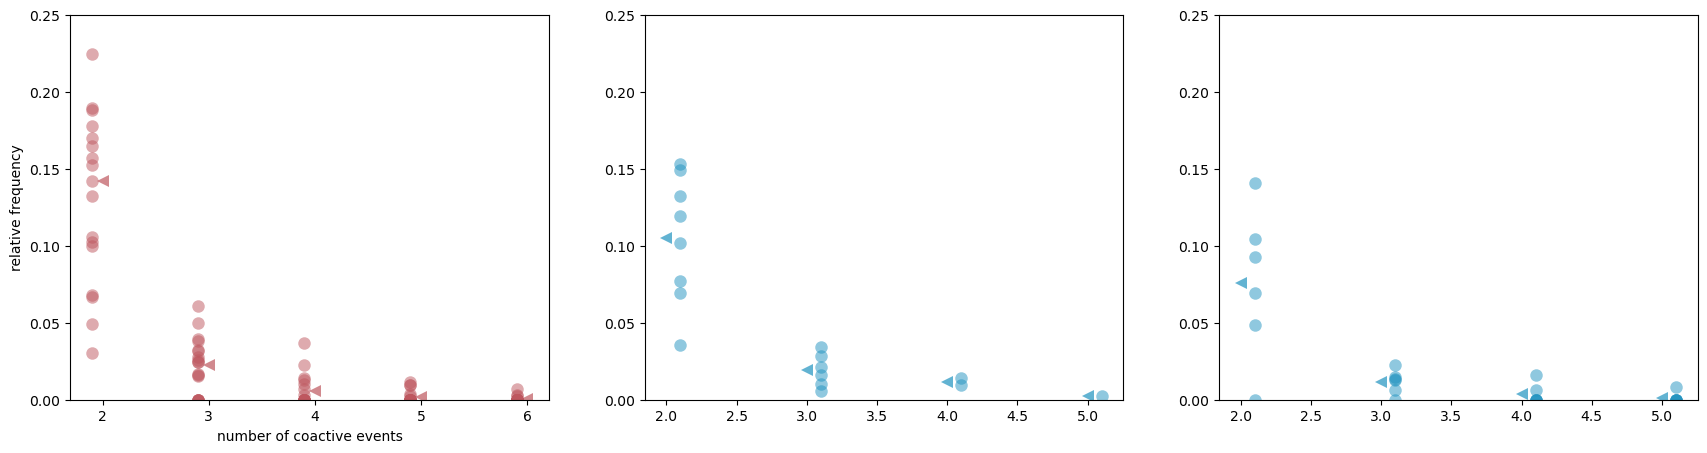

In [193]:

fig, [ax,ax2,ax3]= plt.subplots(1, 3,figsize=(21, 5))

means = []
stds = []
x_ = []
for item in e_coactive_freqs_counts:
    if not item == 1:
        ax.plot(np.ones(len(e_coactive_freqs_counts[item]))*(item-0.1),e_coactive_freqs_counts[item],'o', c = red, alpha = 0.5, markeredgewidth = 0, markersize = 9)
        x_ += [item]
        means += [np.mean(e_coactive_freqs_counts[item])]
        stds += [np.std(e_coactive_freqs_counts[item])]
    
means = np.array(means)[np.argsort(x_)]
stds = np.array(stds)[np.argsort(x_)]
x_ = np.array(x_)[np.argsort(x_)]

ax.plot(x_,means,'<', color = red,alpha = 0.7, markeredgewidth = 0, markersize = 8)

#2 ####
means = []
stds = []
x_ = []
for item in hl_coactive_freqs_counts:
    if not item == 1:
        ax2.plot(np.ones(len(hl_coactive_freqs_counts[item]))*(item+0.1),hl_coactive_freqs_counts[item],'o', c = blue, alpha = 0.5, markeredgewidth = 0, markersize = 9)
        x_ += [item]
        means += [np.mean(hl_coactive_freqs_counts[item])]
        stds += [np.std(hl_coactive_freqs_counts[item])]
    
means = np.array(means)[np.argsort(x_)]
stds = np.array(stds)[np.argsort(x_)]
x_ = np.array(x_)[np.argsort(x_)]

ax2.plot(x_,means,'<', color = blue,alpha = 0.7, markeredgewidth = 0, markersize = 8)

#3 ####
means = []
stds = []
x_ = []
for item in l_coactive_freqs_counts:
    if not item == 1:
        ax3.plot(np.ones(len(l_coactive_freqs_counts[item]))*(item+0.1),l_coactive_freqs_counts[item],'o', c = blue, alpha = 0.5, markeredgewidth = 0, markersize = 9)
        x_ += [item]
        means += [np.mean(l_coactive_freqs_counts[item])]
        stds += [np.std(l_coactive_freqs_counts[item])]
    
means = np.array(means)[np.argsort(x_)]
stds = np.array(stds)[np.argsort(x_)]
x_ = np.array(x_)[np.argsort(x_)]

ax3.plot(x_,means,'<', color = blue,alpha = 0.7, markeredgewidth = 0, markersize = 8)

ax.set_ylim(0,0.25)
ax2.set_ylim(0,0.25)
ax3.set_ylim(0,0.25)
    
upper = means + stds
lower = means - stds
# ax.fill_between(x_,(lower),(upper),
#     alpha=0.2, edgecolor='None', facecolor='red',
#     linewidth=1, linestyle='dashdot', antialiased=True)

ax.set_xlabel('number of coactive events')
ax.set_ylabel('relative frequency')

SaveFig('coactive_event_freq.pdf',out_path)

In [16]:
import math

def poisson_probability(rate, k):
    """Calculate Poisson probability of k events occurring given the rate."""
    return math.exp(-rate) * (rate ** k) / math.factorial(k)

def calculate_probabilities(rate_per_second, event_length_s):
    # Convert event length from milliseconds to seconds
    
    # Calculate the rate per 0.3 seconds considering event length
    rate_per_0p3_seconds = rate_per_second *(0.3 + event_length_s)
    
    results = {}
    total_probability = 0  # Variable to store the total probability
    
    for k in range(1, 7):  # Include probabilities for 1 to 6 events
        probability = poisson_probability(rate_per_0p3_seconds, k)
        results[k] = probability
        total_probability += probability  # Add probability to the total
    
    # Calculate percentages
    percentages = {k: (probability / total_probability) * 100 for k, probability in results.items()}
    
    return rate_per_0p3_seconds, results, percentages

# Input parameters
rate_per_second = np.mean(reactivations_per_min)/60
event_length_s = np.nanmean([item for sublist in task_nontask_e_len for item in sublist])

# Calculate probabilities and percentages
rate_per_0p3_seconds, results, percentages = calculate_probabilities(rate_per_second, event_length_s)

# Display results
print(f"Using a rate of {rate_per_0p3_seconds:.6f} events per 0.3 seconds.")
print("Probability of events co-occurring within 0.3 + mean event length:")
for k, probability in results.items():
    print(f"{k} events co-occurring: Probability {probability:.6f}, Percentage {percentages[k]:.2f}%")

Using a rate of 0.128075 events per 0.3 seconds.
Probability of events co-occurring within 0.3 + mean event length:
1 events co-occurring: Probability 0.112679, Percentage 93.73%
2 events co-occurring: Probability 0.007216, Percentage 6.00%
3 events co-occurring: Probability 0.000308, Percentage 0.26%
4 events co-occurring: Probability 0.000010, Percentage 0.01%
5 events co-occurring: Probability 0.000000, Percentage 0.00%
6 events co-occurring: Probability 0.000000, Percentage 0.00%


In [17]:
# test each one for significance from expected

from scipy.stats import shapiro
from scipy.stats import ttest_1samp

expect_percentages= [6,0.93,0.26,0.01,0,0]
for i,key in enumerate(e_coactive_freqs_counts):
    data = np.array(e_coactive_freqs_counts[key])
    
    print('-------')
    print(key)
    
#     stat, p = shapiro(data)
#     print('Statistics=%.3f, p=%.3f' % (stat, p))
#     alpha = 0.05
#     if p > alpha:
#         print('Data looks Gaussian (fail to reject H0)')
#     else:
#         print('Data does not look Gaussian (reject H0)')
        
    ### all normal so use t test 
    
    # Hypothesized value (e.g., population mean or constant)
    hypothesized_value = expect_percentages[i]

    # Perform one-sample t-test
    statistic, p_value = ttest_1samp(data, hypothesized_value)

    # Print the test statistic and p-value
    print("Test statistic:", statistic)
    print("P-value:", p_value)

    
# plt.plot(np.zeros(len(expect_percentages)),expect_percentages,'o')
# SaveFig('expect_perc.pdf','D:\\')

-------
2
Test statistic: -346.3827019760155
P-value: 3.6829651475589186e-34
-------
1
Test statistic: -4.488109138942195
P-value: 0.0003238847478115092
-------
3
Test statistic: -61.617335206035285
P-value: 2.2096774578879482e-16
-------
6
Test statistic: -4.169559543048749
P-value: 0.05298962471869765
-------
4
Test statistic: 3.5759627626015815
P-value: 0.011699832082098901
-------
5
Test statistic: 4.017840009916196
P-value: 0.015892861525981617


In [18]:
# this should be an anova! 

In [37]:
import scipy
import scikit_posthocs as sp

sorted_dict = dict(sorted(e_coactive_freqs_counts.items()))
control_values = [sorted_dict[key] for key in sorted_dict]
sorted_dict = dict(sorted(hl_coactive_freqs_counts.items()))
lesion_values = [sorted_dict[key] for key in sorted_dict]

s,p__ = scipy.stats.kruskal(*(control_values + lesion_values))
print(p__)

groups = []
labels = ['control', 'lesion']
for i,data in enumerate([control_values,lesion_values]):
    print(len(data))
    for index,item in enumerate(data):
        groups+=[labels[i]+str(index)]*len(item)
data_df = pd.DataFrame({'values': [item for sublist in (control_values+lesion_values) for item in sublist], 'groups': groups})
dunn_results = sp.posthoc_dunn(data_df, val_col='values', group_col='groups')

# dunn_results < 0.05
dunn_results

2.3651817019373116e-13
6
5


,control0,control1,control2,control3,control4,control5,lesion0,lesion1,lesion2,lesion3,lesion4
control0,1.000000e+00,0.006573,0.000002,6.422396e-07,5.161121e-07,0.000016,5.737255e-01,0.010932,0.000012,0.001890,0.007307
control1,6.572612e-03,1.000000,0.021437,3.237076e-03,1.245769e-03,0.004177,5.408959e-03,0.679691,0.013775,0.058544,0.071739
control2,1.674962e-06,0.021437,1.000000,3.117023e-01,1.309944e-01,0.138396,5.376920e-06,0.140831,0.511661,0.450851,0.329036
control3,6.422396e-07,0.003237,0.311702,1.000000e+00,5.841988e-01,0.491391,1.199237e-06,0.028160,0.786932,0.902294,0.614372
control4,5.161121e-07,0.001246,0.130994,5.841988e-01,1.000000e+00,0.832571,6.986949e-07,0.010623,0.436841,0.790734,0.842125
control5,1.580316e-05,0.004177,0.138396,4.913910e-01,8.325706e-01,1.000000,1.171307e-05,0.017340,0.376598,0.680098,0.955939
lesion0,5.737255e-01,0.005409,0.000005,1.199237e-06,6.986949e-07,0.000012,1.000000e+00,0.006974,0.000013,0.001129,0.004619
lesion1,1.093190e-02,0.679691,0.140831,2.816030e-02,1.062339e-02,0.017340,6.974095e-03,1.000000,0.067986,0.118406,0.114359
lesion2,1.160791e-05,0.013775,0.511661,7.869324e-01,4.368414e-01,0.376598,1.314519e-05,0.067986,1.000000,0.760574,0.523540
lesion3,1.889844e-03,0.058544,0.450851,9.022943e-01,7.907341e-01,0.680098,1.129060e-03,0.118406,0.760574,1.000000,0.719280


Non parametric manova 

In [201]:
## create df for manova

df = pd.DataFrame()
df['groups'] = ['control']*len(e_coactive_freqs_counts[1])  + ['lesion']*len(l_coactive_freqs_counts[1])

for key in e_coactive_freqs_counts:
    current_var = e_coactive_freqs_counts[key]
    while len(current_var)<len(e_coactive_freqs_counts[1]):
        current_var +=[0]
    
    try:
        l_coactive_freqs_counts[key]
        current_var_l = l_coactive_freqs_counts[key]
        while len(current_var_l)<len(l_coactive_freqs_counts[1]):
            current_var_l +=[0]
    except:
        current_var_l = [0]*len(l_coactive_freqs_counts[1])
        
        
    df[str(key)] = current_var + current_var_l
    
from skbio.stats.distance import permanova, DistanceMatrix
from skbio import DistanceMatrix
from scipy.spatial.distance import pdist, squareform
from skbio.stats.distance import DistanceMatrix
from skbio.stats.distance import permanova


# Calculate the Euclidean distance matrix
values = df[['1', '2', '3', '4', '5', '6']].values
grouping = df['groups'].values

pairwise_distances = pdist(values, metric='euclidean')
distance_matrix = squareform(pairwise_distances)
dm = DistanceMatrix(distance_matrix)

# Perform PERMANOVA
results = permanova(dm, grouping, permutations=10000)
print(results)



    


    
    
    

method name               PERMANOVA
test statistic name        pseudo-F
sample size                      24
number of groups                  2
test statistic             4.117154
p-value                    0.046195
number of permutations        10000
Name: PERMANOVA results, dtype: object


# coactive ordered vs disordered 

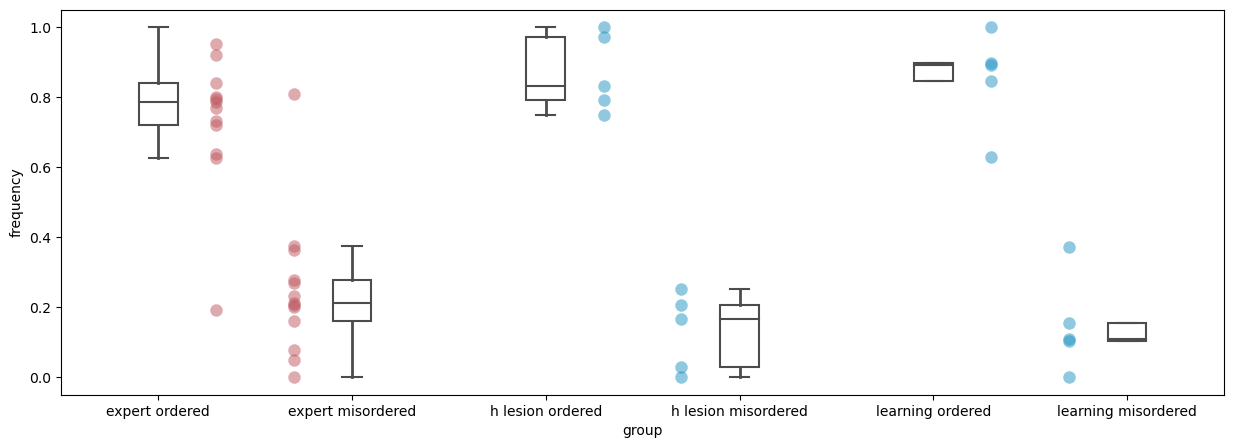

In [100]:
ordered_misordered_bdown =[]
for item in mouse_summed_amounts:
    ordered_misordered_bdown += [list(np.array(item[0:4])/sum(item[0:4]))]
    
e_ordered = []
e_misordered = []
hl_ordered = []
hl_misordered = []
l_ordered = []
l_misordered = []
for index,item in enumerate(ordered_misordered_bdown):
    if len(item) > 0:
        if expert[index] == 1:
            if index < 28:
                e_ordered += [sum(item[0:3])]
                e_misordered += [item[-1]]
        elif hlesion[index] == 1:
            hl_ordered += [sum(item[0:3])]
            hl_misordered += [item[-1]]
        elif learning[index] == 1:
            l_ordered += [sum(item[0:3])]
            l_misordered += [item[-1]]




fig, ax= plt.subplots(1, 1,figsize=(15, 5))

 
ax.plot(0.3*np.ones(len(e_ordered[0:-1])),e_ordered[0:-1], 'o', color = red, alpha = 0.5, markeredgewidth = 0, markersize = 9)
ax.plot(0.7*np.ones(len(e_misordered)),e_misordered, 'o', color = red, alpha = 0.5, markeredgewidth = 0, markersize = 9)
ax.plot(2.3*np.ones(len(hl_ordered)),hl_ordered, 'o', color = blue, alpha = 0.5, markeredgewidth = 0, markersize = 9)
ax.plot(2.7*np.ones(len(hl_misordered)),hl_misordered, 'o', color = blue, alpha = 0.5, markeredgewidth = 0, markersize = 9)
ax.plot(4.3*np.ones(len(l_ordered)),l_ordered, 'o', color = blue, alpha = 0.5, markeredgewidth = 0, markersize = 9)
ax.plot(4.7*np.ones(len(l_misordered)),l_misordered, 'o', color = blue, alpha = 0.5, markeredgewidth = 0, markersize = 9)


    
data = e_ordered+ e_misordered+hl_ordered+hl_misordered+l_ordered+l_misordered
groups = ['expert ordered'] * len(e_ordered) + ['expert misordered'] * len(e_misordered) + ['h lesion ordered'] * len(hl_ordered) + ['h lesion misordered'] * len(hl_misordered) + ['learning ordered'] * len(l_ordered) + ['learning misordered'] * len(l_misordered) 
plt_df = pd.DataFrame({'group':groups,'frequency': data })
ax=sns.boxplot( y = 'frequency', x = 'group', data = plt_df, color = 'blue', width = .2, zorder = 10,\
            showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
            showfliers=False, whiskerprops = {'linewidth':2, "zorder":10},\
               saturation = 1, orient = 'v',ax = ax)


SaveFig('ordered_vs_misordered.pdf','D:\\')

In [11]:
expert

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1]

In [143]:
sequence_order_df = pd.read_csv(awake_PP_path+"sequence_order.csv")

ordered_tot = 0
misordered_tot = 0

for i,seq in enumerate(sequence_order_df.seq_order):
    seq_ = ast.literal_eval(seq)
    if not seq_ == 0:
        if sequence_order_df['group '][i] == 'expert ':
            
            seq_len = len(seq_)
            
            if seq_len == 4:
                ordered_tot += 12
                misordered_tot += 4
            
            if seq_len == 5:
                ordered_tot += 15
                misordered_tot += 14
            
            if seq_len == 6:
                ordered_tot += 18
                misordered_tot += 20
            
            #4 seqs:
            # ordered = 12
            # misordered = 4

            #5 seqs:
            # ordered = 15
            # misordered = 14

            #6 seqs:
            # ordered = 18
            # misordered = 20
            
print(misordered_tot / (ordered_tot + misordered_tot))
print(ordered_tot / (ordered_tot + misordered_tot))

0.38961038961038963
0.6103896103896104


In [108]:
stat, p = shapiro(e_misordered)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')

Statistics=0.838, p=0.020
Data does not look Gaussian (reject H0)


Statistics=0.892, p=0.370
Data looks Gaussian (fail to reject H0)
Test statistic: 0.0
P-value: 0.0625
Statistics=0.892, p=0.370
Data looks Gaussian (fail to reject H0)
Test statistic: 0.0
P-value: 0.0625


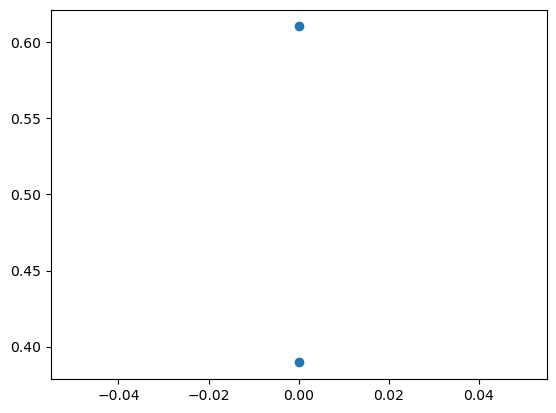

In [168]:
# test each one for significance from expected

from scipy.stats import shapiro
from scipy.stats import wilcoxon

expect_ps= [0.38961038961038963,0.6103896103896104]
for i,data in enumerate([l_misordered,l_ordered]):
    
    stat, p = shapiro(data)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    alpha = 0.05
    if p > alpha:
        print('Data looks Gaussian (fail to reject H0)')
    else:
        print('Data does not look Gaussian (reject H0)')
        
    ### all normal so use t test 
    
    # Hypothesized value (e.g., population mean or constant)
    hypothesized_value = expect_ps[i]

    # Perform one-sample t-test
    statistic, p_value = wilcoxon(np.array(data) - hypothesized_value)

    # Print the test statistic and p-value
    print("Test statistic:", statistic)
    print("P-value:", p_value)

    
plt.plot(np.zeros(len(expect_ps)),expect_ps,'o')
SaveFig('expect_perc.pdf','D:\\')

In [166]:
### stats for expert
import scipy

xpert_ordered_sum = np.array(ordered_sum)[np.array(expert) == 1]
xpert_ordered_misordered_total = np.array(ordered_misordered_total)[np.array(expert) == 1]

observed_ordered = sum(xpert_ordered_sum)
total_coactive_pairs = sum(xpert_ordered_misordered_total) 
null_probability= 0.5
# stats
scipy.stats.binom_test(observed_ordered, n=total_coactive_pairs, p=null_probability)



6.909141982505615e-30

Observed Test Statistic: 0.5030318571514463
p-value: 2e-05


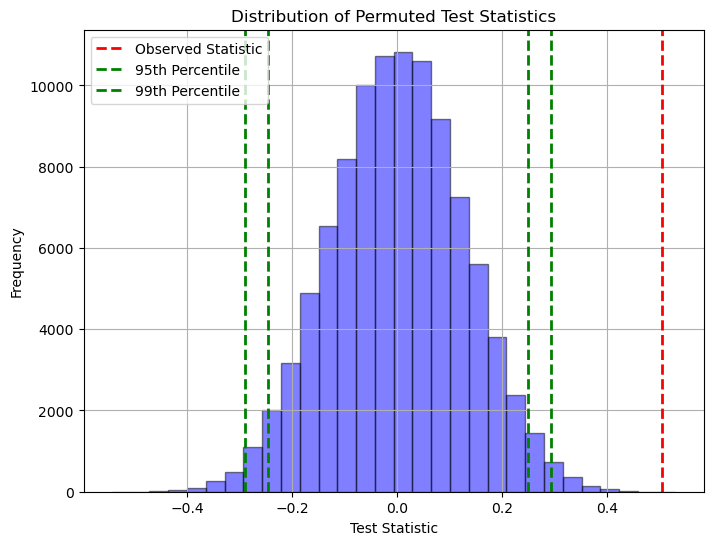

In [172]:
import numpy as np

list1 = e_ordered
list2 = e_misordered


# Define your test statistic function
def test_statistic(list1, list2):
    return np.mean(list1) - np.mean(list2)

# Compute the observed test statistic
observed_statistic = test_statistic(list1, list2)

# Combine the two lists
combined_data = list1 + list2

# Number of permutations
num_permutations = 100000

# Initialize an array to store the permuted test statistics
permuted_statistics = np.zeros(num_permutations)

# Permutation test
for i in range(num_permutations):
    # Shuffle the combined data
    np.random.shuffle(combined_data)
    
    # Split the shuffled data back into two lists
    permuted_list1 = combined_data[:len(list1)]
    permuted_list2 = combined_data[len(list1):]
    
    # Compute the test statistic for the permuted data
    permuted_statistics[i] = test_statistic(permuted_list1, permuted_list2)

# Calculate the p-value
p_value = np.mean(permuted_statistics >= observed_statistic)

print("Observed Test Statistic:", observed_statistic)
print("p-value:", p_value)

plt.figure(figsize=(8, 6))
plt.hist(permuted_statistics, bins=30, alpha=0.5, color='blue', edgecolor='black')
plt.axvline(observed_statistic, color='red', linestyle='dashed', linewidth=2, label='Observed Statistic')
plt.xlabel('Test Statistic')
plt.ylabel('Frequency')
plt.title('Distribution of Permuted Test Statistics')
plt.axvline(np.percentile(permuted_statistics, 97.5), color='green', linestyle='dashed', linewidth=2, label='95th Percentile')
plt.axvline(np.percentile(permuted_statistics, 2.5), color='green', linestyle='dashed', linewidth=2)
plt.axvline(np.percentile(permuted_statistics, 99), color='green', linestyle='dashed', linewidth=2, label='99th Percentile')
plt.axvline(np.percentile(permuted_statistics, 1), color='green', linestyle='dashed', linewidth=2)
plt.xlabel('Test Statistic')
plt.legend()
plt.grid(True)
plt.show()

In [173]:
np.percentile(permuted_statistics, 99)

0.2916305596885628

In [205]:
## stats for comparison
data1 = e_ordered
data2 = l_ordered

from scipy import stats
_, p_value1 = stats.normaltest(data1)
# _, p_value2 = stats.normaltest(data2)

# Step 4: Choose appropriate statistical comparison test
if p_value1 > 0.05 and p_value2 > 0.05:
    # If both datasets are normally distributed, use a parametric test like t-test
    _, p_value = stats.ttest_ind(data1, data2)
else:
    # If any dataset is not normally distributed, use a non-parametric test like Mann-Whitney U test
    _, p_value = stats.mannwhitneyu(data1, data2)
    print('non param')
    print(p_value)

non param
0.2567221075741677


In [207]:
from skbio.stats.distance import permanova, DistanceMatrix
from skbio import DistanceMatrix
from scipy.spatial.distance import pdist, squareform
from skbio.stats.distance import DistanceMatrix
from skbio.stats.distance import permanova

group1 = e_ordered + l_ordered
group2 = e_misordered + l_misordered
grouping = ['control'] * len(e_ordered) + ['lesion'] * len(hl_ordered)

stacked_list = [list(pair) for pair in zip(group1, group2)]

# data is stacked so that each row is a sample (animal) and each colum is a variable/test



pairwise_distances = pdist(stacked_list, metric='euclidean')
distance_matrix = squareform(pairwise_distances)
dm = DistanceMatrix(distance_matrix)

# Perform PERMANOVA
results = permanova(dm, grouping, permutations=999)
print(results)

method name               PERMANOVA
test statistic name        pseudo-F
sample size                      18
number of groups                  2
test statistic              1.05097
p-value                       0.322
number of permutations          999
Name: PERMANOVA results, dtype: object


# breakdown

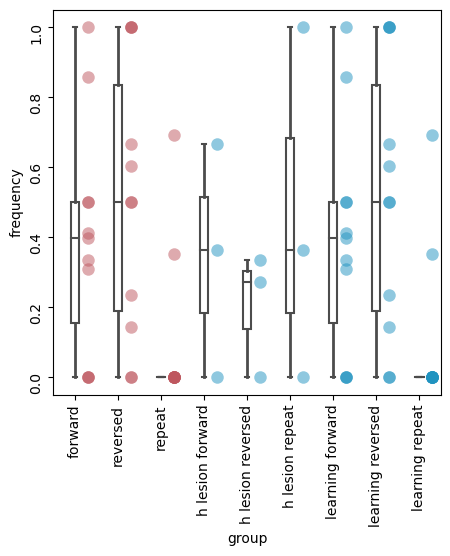

In [231]:
ordered_misordered_bdown =[]
for item in mouse_summed_amounts:
    ordered_misordered_bdown += [list(np.array(item[0:3])/sum(item[0:3]))]

fig, ax= plt.subplots(1, 1,figsize=(5, 5))

e_breakdowns = []
hl_breakdowns = []
l_breakdowns = []
for index,item in enumerate(ordered_misordered_bdown):
    if expert[index] == 1:
        e_breakdowns += [item]
    elif hlesion[index] == 1:
        hl_breakdowns += [item]
    elif learning[index] == 1:
        l_breakdowns += [item]

# l_breakdowns = e_breakdowns
        
for breakdown in e_breakdowns:
    ax.plot([0.3,1.3,2.3],breakdown, 'o', color = red,alpha = 0.5, markeredgewidth = 0, markersize = 9)
for breakdown in hl_breakdowns:
    ax.plot([3.3,4.3,5.3],breakdown, 'o', color = blue,alpha = 0.5, markeredgewidth = 0, markersize = 9)
for breakdown in l_breakdowns:
    ax.plot([6.3,7.3,8.3],breakdown, 'o', color = blue,alpha = 0.5, markeredgewidth = 0, markersize = 9)
    

data = [item for sublist in conactinate_nth_items(e_breakdowns) + conactinate_nth_items(hl_breakdowns) +  conactinate_nth_items(l_breakdowns) for item in sublist]
groups = ['expert forward']*len(conactinate_nth_items(e_breakdowns)[0])+ ['expert reversed']*len(conactinate_nth_items(e_breakdowns)[1])+['expert repeat']*len(conactinate_nth_items(e_breakdowns)[2])+['h lesion forward']*len(conactinate_nth_items(hl_breakdowns)[0])+ ['h lesion reversed']*len(conactinate_nth_items(hl_breakdowns)[1])+['h lesion repeat']*len(conactinate_nth_items(hl_breakdowns)[2])+['learning forward']*len(conactinate_nth_items(l_breakdowns)[0])+ ['learning reversed']*len(conactinate_nth_items(l_breakdowns)[1])+['learning repeat']*len(conactinate_nth_items(l_breakdowns)[2])
plt_df = pd.DataFrame({'group':groups,'frequency': data })
ax=sns.boxplot( y = 'frequency', x = 'group', data = plt_df, color = 'blue', width = .2, zorder = 10,\
            showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
            showfliers=False, whiskerprops = {'linewidth':2, "zorder":10},\
               saturation = 1, orient = 'v',ax = ax)
    
    
labels = ['forward', 'reversed','repeat','h lesion forward', 'h lesion reversed','h lesion repeat','learning forward', 'learning reversed','learning repeat']
    
ax.set_xticks(range(0,len(labels)))
ax.set_xticklabels(labels)
ax.tick_params(axis='both', which='major', labelsize=10, rotation =90)

SaveFig('ordered_breakdown.pdf',out_path)

In [ ]:
## warps 

In [ ]:
## intra seq position 

In [534]:
## neuron involvement 

In [104]:
chunk_expert

[1, 1, 1]

In [ ]:
import statsmodels.regression.linear_model as sm
group1_data = {'x': times, 'y': rates}
group2_data = {'x': c_times_, 'y': c_lens_}

df1 = pd.DataFrame(group1_data)
df2 = pd.DataFrame(group2_data)


# Fit linear regression for Group 1
model_group1 = sm.OLS.from_formula('x ~ y', data=df1).fit()

# Fit linear regression for Group 2
model_group2 = sm.OLS.from_formula('y ~ x', data=df2).fit()

# Print the summary of each model
print("Group 1:")
print(model_group1.summary())
print("\nGroup 2:")
# print(model_group2.summary())

In [ ]:
## split this per group

e_starting_rate = []
e_change_per_min = []
c_starting_rate = []
c_change_per_min = []
for index,rates in enumerate(chunk_rates):
    if len(rates)>1:
        if expert[index] == 1:
            e_change_per_min += list(np.diff(rates) / np.diff(np.array(chunk_mid_times_post_onset[index])/60))
            e_starting_rate += rates[0:-1]
        else:
            c_change_per_min += list(np.diff(rates) / np.diff(np.array(chunk_mid_times_post_onset[index])/60))
            c_starting_rate += rates[0:-1]
    
fig, ax= plt.subplots(1, 1,figsize=(5, 5))
sns.regplot(y=e_change_per_min, x=e_starting_rate, ax = ax, color = red,scatter_kws={'s': 55, 'alpha': 0.3,'linewidths': 0})
sns.regplot(y=c_change_per_min, x=c_starting_rate, ax = ax, color = blue,scatter_kws={'s': 55, 'alpha': 0.8,'linewidths': 0})
ax.set_xlabel('starting rate')
ax.set_ylabel('rate change per minute')
ax.axhline(0,0,ls ='--')

r, p = scipy .stats.pearsonr(e_starting_rate,e_change_per_min)
print(p)
ax.text(0.5,0.7,'r =' + str(r) )

r, p = scipy .stats.pearsonr(c_starting_rate,c_change_per_min)
print(p)
ax.text(0.6,0.8,'r =' + str(r), color = 'blue')

SaveFig('decay_rate.pdf',out_path)

Decay from nrem onset / rem onset

# PPseq warps

In [ ]:
# norm_warps = []
# for warp in warps:
#     norm_warps += [list(np.array(warp)/sum(warp))]

# concat = conactinate_nth_items(norm_warps)
# reverse = concat[0:5]
# forward = concat[5::]

# reverse_means =[]
# reverse_std =[]
# for item in reverse:
#     reverse_means += [np.mean(item)]
#     reverse_std += [np.std(item)]
# reverse_means
# reverse_std
# forward_means =[]
# forward_std =[]
# for item in forward:
#     forward_means += [np.mean(item)]
#     forward_std += [np.std(item)]
    
# forward_means.reverse()
# forward_std.reverse()


# nrow = 1 
# ncol = 1
# fig, axs = plt.subplots(nrow, ncol,figsize=(15, 8))

# labels = ['20x', '5x', '0', '0.2x', '0.05x']
# labels  = labels[::-1]

# for ind, ax in enumerate(fig.axes):


#     ax.set_xticks(range(0,len(labels)))
#     ax.set_xticklabels(labels)

#     ax.plot(forward_means,'o-', color = gold)
#     ax.fill_between([0,1,2,3,4], np.array(forward_means) + forward_std, np.array(forward_means) - forward_std,facecolor =gold, alpha = 0.2)
#     ax.plot(reverse_means,'o-', color = blue)
#     ax.fill_between([0,1,2,3,4], np.array(reverse_means) + reverse_std, np.array(reverse_means) - reverse_std,facecolor =blue, alpha = 0.2)
    
#     ax.text(1,0.25,'Forward',color = gold,size = 30)
#     ax.text(1,0.22,'Reverse', color = blue,size = 30)


#     ax.set_xticks(range(0,len(labels)))
#     ax.set_xticklabels(labels)
#     ax.tick_params(axis='both', which='major', labelsize=20)
    
#     ax.set_xlabel('replay speed',size = 25)
#     ax.set_ylabel('proportion events',size = 25)

# SaveFig('warp.png',out_path)

In [7]:
#### stats:
from scipy.stats import kruskal
from scipy.stats import shapiro
import scikit_posthocs as sp

import scipy
print(shapiro(shuffle_reactivations_per_min))
print(shapiro(e_reactivations_per_min))
print(shapiro(c_reactivations_per_min))

print('not normally distributed') 


### run an anov or something?? 
# Perform Kruskal-Wallis test
kw_result = kruskal(shuffle_reactivations_per_min,e_reactivations_per_min,c_reactivations_per_min)
print("Kruskal-Wallis p-value:", kw_result.pvalue)

# Post hoc Dunn's test for pairwise comparisons
posthoc_dunn = sp.posthoc_dunn(plt_df, val_col='reactivations_per_min', group_col='group')

print(posthoc_dunn)


ShapiroResult(statistic=0.21306133270263672, pvalue=8.810827067939897e-11)
ShapiroResult(statistic=0.9243691563606262, pvalue=0.12027838826179504)
ShapiroResult(statistic=0.8361905217170715, pvalue=0.12118876725435257)
not normally distributed
Kruskal-Wallis p-value: 1.323001720416471e-09
                         Shuffle  comaprison_group  late_learning_data
Shuffle             1.000000e+00          0.000335        1.079223e-09
comaprison_group    3.345479e-04          1.000000        6.848859e-01
late_learning_data  1.079223e-09          0.684886        1.000000e+00


# Decay over time?

In [10]:
chunk_rates = []

chunk_mid_times_post_onset =[]
expert = []
compare = []
chunks_event_lens = []
chunks_event_lens_non_meaned = []
for run_index,pp_file in enumerate(os.listdir(dat_path)):
    if not 'sleep_time_points' in pp_file:
        current_mouse_path = dat_path + pp_file + '\\analysis_output'
        mouse = '_'.join(pp_file.split('_')[0:3])
        if mouse in list(expert_mice) + list(compare_mice):
            print(mouse)
            if mouse in expert_mice:
                expert += [1]
                compare += [0]
            else:                
                expert += [0]
                compare += [1]
            mirs += ['_'.join(pp_file.split('_')[0:3])]
            current_sleep_start = sleep_start[mouse]
            params_file = dat_path + pp_file + r'\trainingData\\' + 'params_' + mouse + '.json'
            with open(params_file, 'r') as file:
                params = json.load(file)
            time_spans = params['time_span']
            chunk_rate = []
            chunk_mid_time_post_onset = []
            chunk_event_lens = []
            for file in os.listdir(current_mouse_path):
                if 'chunk' in file:
                    chunk_number = int(file.split('_')[0][-1])
                    start_offset = ([0]+list(np.cumsum(np.diff(time_spans))))[chunk_number-1]
                    # load in chunk time and cluster info 
                    current_data_path = current_mouse_path + '\\' + file + '\\'
                    chunk_time = np.load(current_data_path + 'chunk_time_interval.npy')

                    replay_clusters_df = pd.read_csv(current_data_path+'filtered_replay_clusters_df.csv')
                     # sequential data only
#                     sequential_data = replay_clusters_df[replay_clusters_df.ordering_classification == 'sequential']
#                     sequential_data = sequential_data.reset_index()
                    sequential_data = data.reset_index()
                    
                    # if chunk started after onset 
                    if ((sum(chunk_time)/2)-current_sleep_start)/60 > 0:
                        chunk_rate += [len(sequential_data)/(np.diff(chunk_time)[0]/60)]
                        chunk_mid_time_post_onset += [((sum(chunk_time)/2)-current_sleep_start)]
                        
                        
                        
                        #lengths
                        chunk_event_lens += [np.nanmean(sequential_data.event_length.values)]

                
            chunk_mid_times_post_onset+= [chunk_mid_time_post_onset]
            chunk_rates += [chunk_rate]
            chunks_event_lens += [np.nanmean(chunk_event_lens)]
            chunks_event_lens_non_meaned += [chunk_event_lens]

136_1_3
136_1_4
148_2_2
149_1_1
178_1_4
178_1_5
178_1_6
178_1_7
178_1_8
178_1_9
178_2_1
178_2_2
178_2_3
178_2_4
268_1_2
269_1_1
269_1_2
269_1_3
269_1_4
269_1_5
269_1_6
269_1_7
270_1_1
270_1_3
270_1_5
270_1_6


In [187]:
import numpy as np
import matplotlib.pyplot as plt

# # Sample data (replace these with your actual event_rates and event_times)
# event_rates = erates
# event_times = etimes

# Function to create 20-minute bins and assign events to bins
def create_bins(event_times, event_rates):
    bin_ranges = np.arange(0, max(event_times) + 6, 5)
    bin_assignments = np.digitize(event_times, bin_ranges)
    binned_data = {bin_: [] for bin_ in np.unique(bin_assignments)}

    for time, rate in zip(event_times, event_rates):
        bin_ = bin_assignments[event_times.index(time)]
        binned_data[bin_].append(rate)

    return bin_ranges, binned_data

# Create bins and get the binned data
bin_ranges, binned_data = create_bins(event_times, event_rates)

# Create a list to hold the data for box plots
box_plot_data = [binned_data[bin_] for bin_ in sorted(binned_data.keys())]

# Plot the data using box plots
plt.figure(figsize=(10, 6))
plt.boxplot(box_plot_data, labels=[f"{bin_ranges[i-1]}-{bin_ranges[i]-1} mins" for i in sorted(binned_data.keys())])
plt.xlabel("Time Bins")
plt.ylabel("Event Rates")
plt.title("Event Rates in 20-Minute Bins")
plt.grid(True)
plt.show()


NameError: name 'event_rates' is not defined

In [188]:
bin_size = 20
hist, bins = np.histogram(erates, bins=np.arange(0, 100, bin_size))
plt.plot(np.arange(0, 100-bin_size, bin_size),hist)

bin_size = 20
hist, bins = np.histogram(crates, bins=np.arange(0, 100, bin_size))
plt.plot(np.arange(0, 100-bin_size, bin_size),hist)

NameError: name 'erates' is not defined

In [210]:
chunk_rates

NameError: name 'chunk_rates' is not defined

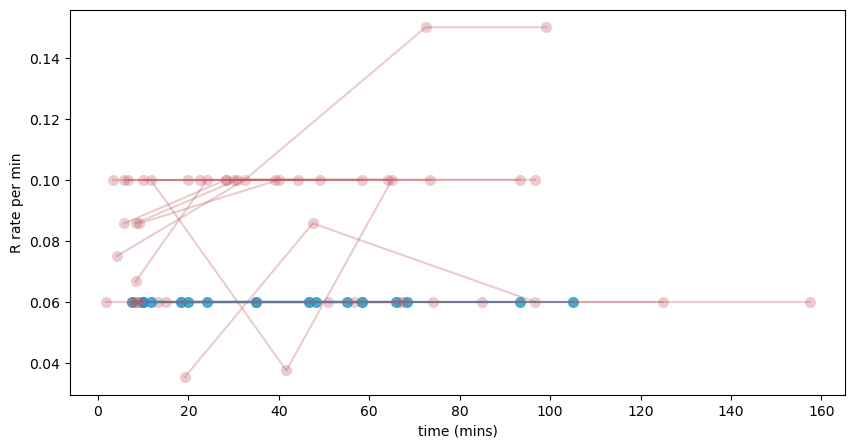

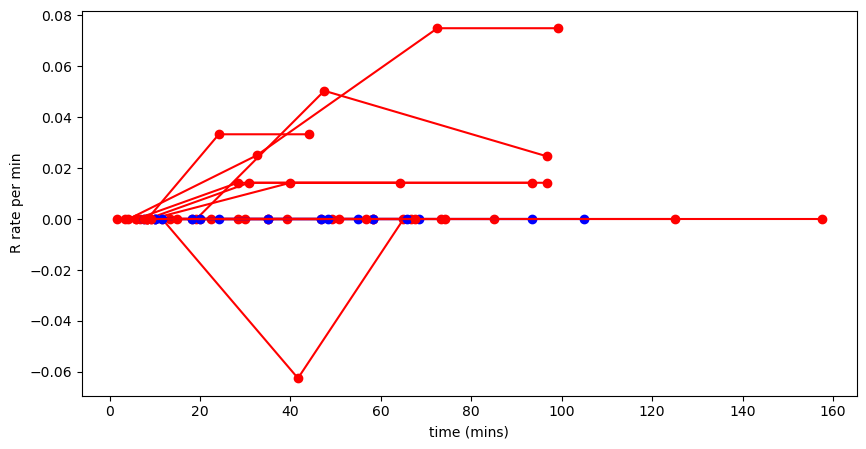

In [14]:
erates = []  
crates = []
etimes = []
ctimes = []
fig, ax= plt.subplots(1, 1,figsize=(10, 5))
for index,rates in enumerate(chunk_rates):
    if len(rates)>1:
        if expert[index] == 1:
            col = red
            erates+=rates
            etimes += list(np.array(chunk_mid_times_post_onset[index])/60)
            alpha_ = 0.3
        else:
            col = blue
            crates+=rates
            ctimes += list(np.array(chunk_mid_times_post_onset[index])/60)
            alpha_ = 0.8
        ax.plot(np.array(chunk_mid_times_post_onset[index])/60,rates,'-o', c = col, alpha = alpha_, markeredgewidth = 0, markersize = 8) 
        ax.set_xlabel('time (mins)')
        ax.set_ylabel('R rate per min')

SaveFig('decay1.pdf',out_path)

fig, ax= plt.subplots(1, 1,figsize=(10, 5))
for index,rates in enumerate(chunk_rates):
    if len(rates)>1:
        if expert[index] == 1:
            col = 'red'
        else:
            col = 'blue'
        relative_decay = np.array(rates) - rates[0]
        ax.plot(np.array(chunk_mid_times_post_onset[index])/60,relative_decay,'-o', c = col) 
        ax.set_xlabel('time (mins)')
        ax.set_ylabel('R rate per min')

SaveFig('decay2.pdf',out_path)

In [ ]:

times = np.array(times)/60

In [ ]:
rates = [item for sublist in chunk_rates for item in sublist]
times = [item for sublist in chunk_mid_times_post_onset for item in sublist]

from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(times, rates)

In [ ]:
r_value**2

In [15]:
## split this per group

e_starting_rate = []
e_change_per_min = []
c_starting_rate = []
c_change_per_min = []
for index,rates in enumerate(chunk_rates):
    if len(rates)>1:
        if expert[index] == 1:
            e_change_per_min += list(np.diff(rates) / np.diff(np.array(chunk_mid_times_post_onset[index])/60))
            e_starting_rate += rates[0:-1]
        else:
            c_change_per_min += list(np.diff(rates) / np.diff(np.array(chunk_mid_times_post_onset[index])/60))
            c_starting_rate += rates[0:-1]
    
fig, ax= plt.subplots(1, 1,figsize=(5, 5))
sns.regplot(y=e_change_per_min, x=e_starting_rate, ax = ax, color = red,scatter_kws={'s': 55, 'alpha': 0.3,'linewidths': 0})
sns.regplot(y=c_change_per_min, x=c_starting_rate, ax = ax, color = blue,scatter_kws={'s': 55, 'alpha': 0.8,'linewidths': 0})
ax.set_xlabel('starting rate')
ax.set_ylabel('rate change per minute')
ax.axhline(0,0,ls ='--')

r, p = scipy .stats.pearsonr(e_starting_rate,e_change_per_min)
print(p)
ax.text(0.5,0.7,'r =' + str(r) )

r, p = scipy .stats.pearsonr(c_starting_rate,c_change_per_min)
print(p)
ax.text(0.6,0.8,'r =' + str(r), color = 'blue')

SaveFig('decay_rate.pdf',out_path)

0.02763431395000147
nan


C:\Users\Emmett\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [ ]:

e_change_per_min
e_starting_rate

In [ ]:
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(e_starting_rate, e_change_per_min)
print(p_value)
print(r_value**2)

In [ ]:
slope, intercept, r_value, p_value, std_err = linregress(c_starting_rate,c_change_per_min)
print(p_value)
print(r_value**2)

In [299]:
p_value

0.00036409343980404937

In [300]:
import statsmodels.regression.linear_model as sm
group1_data = {'x': , 'y': }


df1 = pd.DataFrame(group1_data)


# Fit linear regression for Group 1
model_group1 = sm.OLS.from_formula('x ~ y', data=df1).fit()


# Print the summary of each model
print("Group 1:")
print(model_group1.summary())

SyntaxError: invalid syntax (169745888.py, line 2)

# replay event length

In [274]:
## mean event lengths


e_mean_lens = []
c_mean_lens = []
e_times = []
c_times = []
e_lens = []
c_lens = []
for index,mouse_data in enumerate(chunks_event_lens):
    if expert[index] == 1:
        e_mean_lens += [mouse_data]
        e_times += chunk_mid_times_post_onset[index]
        chunks_event_lens_non_meaned[index]
        e_lens += chunks_event_lens_non_meaned[index]
    else:
        c_mean_lens += [mouse_data]
        c_times += chunk_mid_times_post_onset[index]
        c_lens += chunks_event_lens_non_meaned[index]
    

# Create figure and axes
fig, ax= plt.subplots(1, 1,figsize=(2, 5))

# Plot non shuffle data scatter plot
ax.plot(np.ones(len(e_mean_lens))*-0.3, e_mean_lens, 'o',color=red, alpha=0.5, label='Data', markeredgewidth = 0, markersize = 8)
ax.plot(np.ones(len(c_mean_lens))*0.7, c_mean_lens, 'o',color=blue, alpha=0.5, label='Data',markeredgewidth = 0, markersize = 8)


plt_df = pd.DataFrame({'group':['expert mice']*len(e_mean_lens) + ['comparision']*len(c_mean_lens),'mean single reactivation event length': e_mean_lens+c_mean_lens })
ax=sns.boxplot( y = 'mean single reactivation event length', x = 'group', data = plt_df, color = 'blue', width = .2, zorder = 10,\
            showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
            showfliers=False, whiskerprops = {'linewidth':2, "zorder":10},\
               saturation = 1, orient = 'v',ax = ax)

ax.set_ylim(0,0.50)


SaveFig('event_length.pdf',out_path)

NameError: name 'chunks_event_lens' is not defined

In [ ]:
np.median(e_mean_lens)

In [12]:
np.median(c_mean_lens)

NameError: name 'c_mean_lens' is not defined

In [13]:
e_lens_ =[]
e_times_ = []
for index,e_len in enumerate(e_lens):
    if not np.isnan(e_len):
        e_lens_+=[e_len]
        e_times_ += [e_times[index]]
    

fig, ax= plt.subplots(1, 1,figsize=(5, 5))
e_times_ = np.array(e_times_)/60
sns.regplot(y=e_lens_, x=e_times_, ax = ax, color = red,scatter_kws={'s': 55, 'alpha': 0.2,'linewidths': 0})
ax.set_xlabel('time after first sleep onset')
ax.set_ylabel('mean event length')
r, p = scipy .stats.pearsonr(e_times_,e_lens_)
print(p)
ax.text(1.2,max(e_mean_lens) + 0.1,'r =' + str(r) )

c_lens_ =[]
c_times_ = []
for index,c_len in enumerate(c_lens):
    if not np.isnan(c_len):
        c_lens_+=[c_len]
        c_times_ += [c_times[index]]

c_times_ = np.array(c_times_)/60
sns.regplot(y=c_lens_, x=c_times_, ax = ax, color = blue,scatter_kws={'s': 55, 'alpha': 0.7,'linewidths': 0})
ax.set_xlabel('time after first sleep onset')
ax.set_ylabel('mean event length')
r, p = scipy .stats.pearsonr(c_times_,c_lens_)
print(p)
ax.text(1.2,max(c_mean_lens) + 0.15,'r =' + str(r) )

SaveFig('event_length_against_time.pdf',out_path)



NameError: name 'e_lens' is not defined

In [14]:
import statsmodels.api as sm


# Generate sample data for two groups
group1_data = {'time': e_times_, 'length': e_lens_}
group2_data = {'time': c_times_, 'length': c_lens_}

df1 = pd.DataFrame(group1_data)
df1['group'] = 'Group 1'
df2 = pd.DataFrame(group2_data)
df2['group'] = 'Group 2'

# Combine the dataframes
combined_df = pd.concat([df1, df2])


# Fit the ANCOVA model
model = sm.OLS.from_formula('length ~ time + group + time:group', data=combined_df).fit()

# Print the summary of the model
print(model.summary())


NameError: name 'c_times_' is not defined

In [306]:
group1_data = {'x': e_times_, 'y': e_lens_}
group2_data = {'x': c_times_, 'y': c_lens_}

df1 = pd.DataFrame(group1_data)
df2 = pd.DataFrame(group2_data)


# Fit linear regression for Group 1
model_group1 = sm.OLS.from_formula('y ~ x', data=df1).fit()

# Fit linear regression for Group 2
model_group2 = sm.OLS.from_formula('y ~ x', data=df2).fit()

# Print the summary of each model
print("Group 1:")
print(model_group1.summary())
print("\nGroup 2:")
print(model_group2.summary())


Group 1:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     1.975
Date:                Fri, 11 Aug 2023   Prob (F-statistic):              0.166
Time:                        01:48:07   Log-Likelihood:                 45.043
No. Observations:                  55   AIC:                            -86.09
Df Residuals:                      53   BIC:                            -82.07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2063      0.023      9.071

# task related frequency vs others 

In [158]:

def cluster_events(start_times, end_times, threshold):
    clusters = []
    for i in range(len(start_times)):
        event_added = False
        for cluster in clusters:
            for index in cluster:
                if (start_times[i] <= end_times[index] + threshold and end_times[i] >= start_times[index] - threshold):
                    cluster.append(i)
                    event_added = True
                    break
            if event_added:
                break
        if not event_added:
            clusters.append([i])
    return clusters

def relative_dict(input_dict):
    total_sum = sum(input_dict.values())
    relative_dict = {key: value / total_sum for key, value in input_dict.items()}
    return relative_dict



In [159]:
## load in data for task vs non task related stuff


dat_path = r"Z:\projects\sequence_squad\organised_data\ppseq_data\output_data\striatum\New_Post_sleep\\"

expert = []
compare = []

rel_task_nontask = []
chunks_task_nontask = []
nontask_seqs = []
chunk_mid_time_post_onset = []
chunk_nontask_task = []
chunk_expert = []
av_coactive_len_per_chunk = []
e_coactive_freqs_counts = {}
c_coactive_freqs_counts = {}
all_total_events = []
for run_index,pp_file in enumerate(os.listdir(dat_path)):
    if not 'sleep_time_points' in pp_file:
        current_mouse_path = dat_path + pp_file + '\\analysis_output'
        mouse = '_'.join(pp_file.split('_')[0:3])
        if mouse in list(expert_mice) + list(compare_mice):
            current_sleep_start = sleep_start[mouse]
            params_file = dat_path + pp_file + r'\trainingData\\' + 'params_' + mouse + '.json'
            with open(params_file, 'r') as file:
                params = json.load(file)
            time_spans = params['time_span']
            print(mouse)
            if mouse in expert_mice:
                expert += [1]
                compare += [0]
            else:                
                expert += [0]
                compare += [1]
            
            coactive_freqs_chunk  = {}
            chunk_total_nontask_task_related_events = []
            total_events = 0
            for file in os.listdir(current_mouse_path):
                if 'chunk' in file:
                    # load in chunk time and cluster info 
                    current_data_path = current_mouse_path + '\\' + file + '\\'  
                    
                    chunk_time = np.load(current_data_path + 'chunk_time_interval.npy')
                    
                    replay_clusters_df = pd.read_csv(current_data_path+'filtered_replay_clusters_df.csv')
                    # sequential data only
                    sequential_data = replay_clusters_df[replay_clusters_df.ordering_classification == 'sequential']
                    sequential_data = sequential_data.reset_index()

                    task_seqs = np.load(current_data_path + 'task_order_seqs.npy')+1
                    task_related = 0
                    non_task_related = 0
                    for motif_type in sequential_data.cluster_seq_type:
                        if motif_type in task_seqs:
                            task_related += 1
                        else:
                            non_task_related += 1
                            
                            
                    total_events += len(sequential_data.cluster_seq_type)

                    # normalise by number of each type: 
                    if (6-len(task_seqs)) == 0:
                        chunk_total_nontask_task_related_events += [[non_task_related,(task_related/len(task_seqs))]]
                    else:
                        chunk_total_nontask_task_related_events += [[non_task_related/(6-len(task_seqs)),(task_related/len(task_seqs))]]
                        
                    chunk_mid_time_post_onset += [((sum(chunk_time)/2)-current_sleep_start)]
                    
                    ### ignore the origonal clusterg rosp and remake them: 
                    start_times = sequential_data.first_spike_time.values
                    end_times = sequential_data.last_spike_time.values
                    event_proximity_filter =  0.5 #s (how close events have to be to each other to be clustered together as coacitve 

                    clustered_events = cluster_events(start_times, end_times,event_proximity_filter)

                    cluster_group = np.zeros(len(sequential_data))
                    for index,cluster in enumerate(clustered_events):
                        for item in cluster:
                            cluster_group[item] = int(index)
                    sequential_data['coactive_cluster_group'] = cluster_group

                    # work out how mnay coacitve in chunk: 
                    current_coactive_freqs_chunk = {}
                    for cluster in sequential_data.coactive_cluster_group.unique():
                        num = list(sequential_data.coactive_cluster_group.values).count(cluster)
                        if num in current_coactive_freqs_chunk:
                            current_coactive_freqs_chunk[num] += 1
                        else:
                            current_coactive_freqs_chunk[num] = 1
                            
                    avs =[]
                    for item in current_coactive_freqs_chunk:
                        avs += current_coactive_freqs_chunk[item] * [item]
                    av_coactive_len_per_chunk += [np.mean(avs)]
                    if mouse in expert_mice:
                        chunk_expert += [1]
                    else:
                        chunk_expert += [0]
                            
                    # make it relative:
                    current_coactive_freqs_chunk = relative_dict(current_coactive_freqs_chunk)

                    coactive_freqs_keys = list(current_coactive_freqs_chunk.keys())
                    rel_coactive_freqs = list(current_coactive_freqs_chunk.values())
                    for index,item in enumerate(rel_coactive_freqs):
                        num = int(coactive_freqs_keys[index])
                        if num in coactive_freqs_chunk:
                            coactive_freqs_chunk[num] += [item]
                        else:
                            coactive_freqs_chunk[num] = [item]


                    
            relative = []
            totals = [sum(item) for item in chunk_total_nontask_task_related_events]
            for i,item in enumerate(chunk_total_nontask_task_related_events):
                relative += [list(np.array(item)/totals[i])]
                
            all_total_events += [total_events]
                
            num_task_order_seqs = len(np.load(current_data_path+ 'task_order_seqs.npy')+1)
            
            rel_task_nontask += [[np.mean(conactinate_nth_items(relative)[1]),np.mean(conactinate_nth_items(relative)[0])]]
            
            chunks_task_nontask += conactinate_nth_items(relative)[1]
            
            for item in coactive_freqs_chunk:
                if mouse in expert_mice:
                    if item in e_coactive_freqs_counts:
                        e_coactive_freqs_counts[item] += [np.mean(coactive_freqs_chunk[item])]
                    else:
                        e_coactive_freqs_counts[item] = [np.mean(coactive_freqs_chunk[item])]
                elif mouse in hlesion:
                    if item in hl_coactive_freqs_counts:
                        hl_coactive_freqs_counts[item] += [np.mean(coactive_freqs_chunk[item])]
                    else:
                        hl_coactive_freqs_counts[item] = [np.mean(coactive_freqs_chunk[item])]
                elif mouse in learning:
                    if item in c_coactive_freqs_counts:
                        l_coactive_freqs_counts[item] += [np.mean(coactive_freqs_chunk[item])]
                    else:
                        l_coactive_freqs_counts[item] = [np.mean(coactive_freqs_chunk[item])]


            
            
            


NameError: name 'compare_mice' is not defined

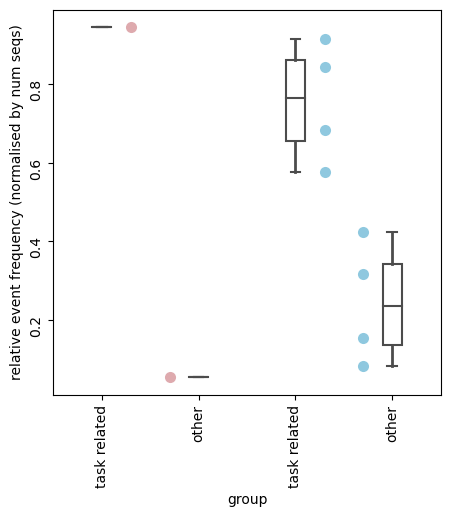

In [276]:
# seq proportions (task seqs vs others) - mean across all chunks
    
fig, ax= plt.subplots(1, 1,figsize=(5, 5))
e_rel_task_nontask = []
c_rel_task_nontask = []
for index,item in enumerate(rel_task_nontask):
    if expert[index] == 1:
        e_rel_task_nontask += [item]
    else:
        c_rel_task_nontask += [item]
    
for index,item in enumerate(e_rel_task_nontask):    
    ax.plot([0.3,0.7],item, 'o', color = red, alpha = 0.5, label='Data', markeredgewidth = 0, markersize = 8)
for index,item in enumerate(c_rel_task_nontask):    
    ax.plot([2.3,2.7],item, 'o', color = blue, alpha = 0.5 , label='Data', markeredgewidth = 0, markersize = 8)
    
data = conactinate_nth_items(e_rel_task_nontask)[0] + conactinate_nth_items(e_rel_task_nontask)[1] + conactinate_nth_items(c_rel_task_nontask)[0] + conactinate_nth_items(c_rel_task_nontask)[1]
groups = ['task related'] * len(conactinate_nth_items(e_rel_task_nontask)[0]) + ['other'] * len(conactinate_nth_items(e_rel_task_nontask)[1]) +  ['task related2'] * len(conactinate_nth_items(c_rel_task_nontask)[0]) + ['other2'] * len(conactinate_nth_items(c_rel_task_nontask)[1])
plt_df = pd.DataFrame({'group':groups,'relative event frequency (normalised by num seqs)': data })
ax=sns.boxplot( y = 'relative event frequency (normalised by num seqs)', x = 'group', data = plt_df, color = 'blue', width = .2, zorder = 10,\
            showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
            showfliers=False, whiskerprops = {'linewidth':2, "zorder":10},\
               saturation = 1, orient = 'v',ax = ax)


labels = ['task related', 'other','task related', 'other']
    
ax.set_xticks(range(0,len(labels)))
ax.set_xticklabels(labels)
ax.tick_params(axis='both', which='major', labelsize=10, rotation =90)

SaveFig('norm_R_event_type_frequency.pdf',out_path)

In [113]:
total_a = list(np.array(all_total_events)[np.array(expert) == 1])
total_a_ = []
all_data = []
for index,data in enumerate(e_rel_task_nontask):
    if np.isnan(data[0]) or np.isnan(data[1]):
        print(data)
    else:
        total_a_ += [total_a[index]]
        all_data += [data]
        
observed_a = conactinate_nth_items(all_data)[0]


total_b = list(np.array(all_total_events)[np.array(compare) == 1])
total_b_ = []
all_data = []
for index,data in enumerate(c_rel_task_nontask):
    if np.isnan(data[0]) or np.isnan(data[1]):
        print(data)
    else:
        total_b_ += [total_b[index]]
        all_data += [data]
        
observed_b = conactinate_nth_items(all_data)[0]

[nan, nan]
[nan, nan]
[nan, nan]


In [114]:
binom_test((np.sum(total_a) * np.mean(observed_a)).astype(int), np.sum(total_a), p=0.5)

C:\Users\Emmett\AppData\Local\Temp\ipykernel_14928\3176052684.py:1: DeprecationWarning: 'binom_test' is deprecated in favour of 'binomtest' from version 1.7.0 and will be removed in Scipy 1.12.0.
  binom_test((np.sum(total_a) * np.mean(observed_a)).astype(int), np.sum(total_a), p=0.5)


4.8301092702579074e-89

In [116]:
binom_test((np.sum(total_b) * np.mean(observed_b)).astype(int), np.sum(total_b), p=0.5)


C:\Users\Emmett\AppData\Local\Temp\ipykernel_14928\1885183555.py:1: DeprecationWarning: 'binom_test' is deprecated in favour of 'binomtest' from version 1.7.0 and will be removed in Scipy 1.12.0.
  binom_test((np.sum(total_b) * np.mean(observed_b)).astype(int), np.sum(total_b), p=0.5)


3.673525265396942e-16

In [344]:
all_data = []
for data in e_rel_task_nontask:
    if np.isnan(data[0]) or np.isnan(data[1]):
        print(data)
    else:
        all_data += [data]

from statsmodels.stats.contingency_tables import mcnemar

# Observed proportions for each group
# Observed proportions for each group
observed_a = conactinate_nth_items(all_data)[0]
observed_b = conactinate_nth_items(all_data)[1]

# Convert proportions to counts
total_trials = len(observed_a)
observed_counts_a = np.round(np.array(observed_a) * total_trials)
observed_counts_b = np.round(np.array(observed_b) * total_trials)

# Create a contingency table
contingency_table = np.array([observed_counts_a, observed_counts_b]).T

# Perform McNemar's test
result = mcnemar(contingency_table)

print(result)


[nan, nan]
[nan, nan]
pvalue      0.5034446716308594
statistic   8.0


In [311]:
all_data = []
for data in c_rel_task_nontask:
    if np.isnan(data[0]) or np.isnan(data[1]):
        print(data)
    else:
        all_data += [data]

from statsmodels.stats.contingency_tables import mcnemar

# Observed proportions for each group
# Observed proportions for each group
observed_a = conactinate_nth_items(all_data)[0]
observed_b = conactinate_nth_items(all_data)[1]

# Convert proportions to counts
total_trials = len(observed_a)
observed_counts_a = np.round(np.array(observed_a) * total_trials)
observed_counts_b = np.round(np.array(observed_b) * total_trials)

# Create a contingency table
contingency_table = np.array([observed_counts_a, observed_counts_b]).T

# Perform McNemar's test
result = mcnemar(contingency_table)

print(result)


[nan, nan]
pvalue      0.7265625
statistic   3.0


In [312]:
observed_counts_a

array([5., 5., 1., 5., 4., 7., 3., 7.])

# coactive frequency 

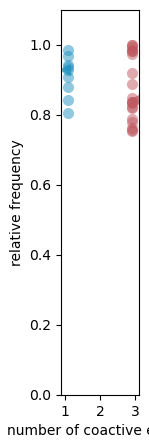

In [313]:
# plot frequency of coactive events (1,2,3,4,etc.)

fig, ax= plt.subplots(1, 1,figsize=(1, 5))

means = []
stds = []
x_ = []
for item in e_coactive_freqs_counts:
    ax.plot(np.ones(len(e_coactive_freqs_counts[1]))*(item-0.1),e_coactive_freqs_counts[1],'o', c = red, alpha = 0.5, markeredgewidth = 0, markersize = 8)
    x_ += [item]
    means += [np.median(e_coactive_freqs_counts[1])]
    stds += [np.std(e_coactive_freqs_counts[1])]
    break
    
means = np.array(means)[np.argsort(x_)]
stds = np.array(stds)[np.argsort(x_)]
x_ = np.array(x_)[np.argsort(x_)]

ax.plot(x_[0],means[0],'<', color = red,alpha = 0.7, markeredgewidth = 0, markersize = 8)

means = []
stds = []
x_ = []
for item in c_coactive_freqs_counts:
    ax.plot(np.ones(len(c_coactive_freqs_counts[1]))*(item+0.1),c_coactive_freqs_counts[1],'o', c = blue, alpha = 0.5, markeredgewidth = 0, markersize = 8)
    x_ += [item]
    means += [np.median(c_coactive_freqs_counts[1])]
    stds += [np.std(c_coactive_freqs_counts[1])]
    break
    
means = np.array(means)[np.argsort(x_)]
stds = np.array(stds)[np.argsort(x_)]
x_ = np.array(x_)[np.argsort(x_)]

ax.plot(x_[0],means[0],'<', color = blue,alpha = 0.7, markeredgewidth = 0, markersize = 8)


    
upper = means + stds
lower = means - stds
ax.fill_between(x_,(lower),(upper),
    alpha=0.2, edgecolor='None', facecolor='red',
    linewidth=1, linestyle='dashdot', antialiased=True)

ax.set_xlabel('number of coactive events')
ax.set_ylabel('relative frequency')

ax.set_ylim(0,1.1)

SaveFig('single_event_freq.pdf',out_path)

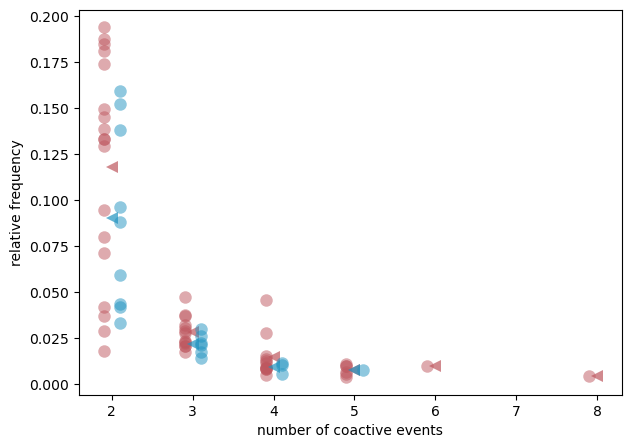

In [314]:

fig, ax= plt.subplots(1, 1,figsize=(7, 5))

means = []
stds = []
x_ = []
for item in e_coactive_freqs_counts:
    if not item == 1:
        ax.plot(np.ones(len(e_coactive_freqs_counts[item]))*(item-0.1),e_coactive_freqs_counts[item],'o', c = red, alpha = 0.5, markeredgewidth = 0, markersize = 9)
        x_ += [item]
        means += [np.mean(e_coactive_freqs_counts[item])]
        stds += [np.std(e_coactive_freqs_counts[item])]
    
means = np.array(means)[np.argsort(x_)]
stds = np.array(stds)[np.argsort(x_)]
x_ = np.array(x_)[np.argsort(x_)]

ax.plot(x_,means,'<', color = red,alpha = 0.7, markeredgewidth = 0, markersize = 8)

means = []
stds = []
x_ = []
for item in c_coactive_freqs_counts:
    if not item == 1:
        ax.plot(np.ones(len(c_coactive_freqs_counts[item]))*(item+0.1),c_coactive_freqs_counts[item],'o', c = blue, alpha = 0.5, markeredgewidth = 0, markersize = 9)
        x_ += [item]
        means += [np.mean(c_coactive_freqs_counts[item])]
        stds += [np.std(c_coactive_freqs_counts[item])]
    
means = np.array(means)[np.argsort(x_)]
stds = np.array(stds)[np.argsort(x_)]
x_ = np.array(x_)[np.argsort(x_)]

ax.plot(x_,means,'<', color = blue,alpha = 0.7, markeredgewidth = 0, markersize = 8)


    
upper = means + stds
lower = means - stds
# ax.fill_between(x_,(lower),(upper),
#     alpha=0.2, edgecolor='None', facecolor='red',
#     linewidth=1, linestyle='dashdot', antialiased=True)

ax.set_xlabel('number of coactive events')
ax.set_ylabel('relative frequency')

SaveFig('coactive_event_freq.pdf',out_path)

In [315]:
means

array([0.09010243, 0.02192122, 0.009065  , 0.00732601])

0.01672247307020289
0.38054619345452356


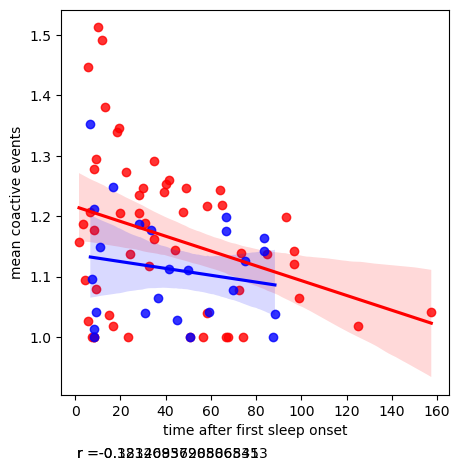

In [316]:
# coactive events breakdown across time from sleep onset
e_av_coactive_len_per_chunk_ = []
e_chunk_midpoints_ = []
c_av_coactive_len_per_chunk_ = []
c_chunk_midpoints_ = []
for index,av in enumerate(av_coactive_len_per_chunk):
    if not np.isnan(av):
        if chunk_expert[index] == 1:
            e_av_coactive_len_per_chunk_+=[av]
            e_chunk_midpoints_ += [chunk_mid_time_post_onset[index]]
        else:
            c_av_coactive_len_per_chunk_+=[av]
            c_chunk_midpoints_ += [chunk_mid_time_post_onset[index]]



fig, ax= plt.subplots(1, 1,figsize=(5, 5))

x_vals = (np.array(e_chunk_midpoints_)/60)[(np.array(e_chunk_midpoints_)/60) > 0]
y_vals = np.array(e_av_coactive_len_per_chunk_)[(np.array(e_chunk_midpoints_)/60) > 0]
sns.regplot(x =x_vals,y =y_vals, color = 'red')
ax.set_xlabel('time after first sleep onset')
ax.set_ylabel('mean coactive events')
r, p = scipy .stats.pearsonr(x_vals,y_vals)
print(p)
ax.text(0.8,0.8,'r =' + str(r) )

x_vals = (np.array(c_chunk_midpoints_)/60)[(np.array(c_chunk_midpoints_)/60) > 0]
y_vals = np.array(c_av_coactive_len_per_chunk_)[(np.array(c_chunk_midpoints_)/60) > 0]
sns.regplot(x =x_vals,y =y_vals, color = 'blue')
ax.set_xlabel('time after first sleep onset')
ax.set_ylabel('mean coactive events')
r, p = scipy .stats.pearsonr(x_vals,y_vals)
print(p)
ax.text(0.8,0.8,'r =' + str(r) )

SaveFig('mean_coactive_freq_decay.png',out_path)

# ordered vs non ordered and catagorisation and breakdown

In [317]:
## two more plots:

# ordered vs non ordered
# ordered breakdown 
# inter event intervals (just for ut knowledge)
# motif freq in awake vs sleep (task non task)
# color coded by where they sit in teh seq...? 

def logic_machine_for_pair_catagorisation(pair,dominant,other):
    # if first one in dominant check for ordering:
    if pair[0] in dominant and pair[-1] in dominant:
        if pair_in_sequence(pair,dominant):
            return('ordered')
        elif pair_in_sequence(pair,dominant[::-1]):
            return('reverse')
        elif pair[-1] == pair[0]:
            return('repeat')
        elif pair[-1] in dominant:
            return('misordered') 
    # if its not these  options then check if it could be in the extra task seqs
    elif pair[0] in  (dominant + other) and pair[-1] in  (dominant + other):
        for item in other:
            if pair[0] in  (dominant + [item]):
                if pair_in_sequence(pair,(dominant + [item])):
                    return('ordered')
                elif pair_in_sequence(pair,(dominant + [item])[::-1]):
                    return('reverse')
                elif pair[-1] == pair[0]:
                    return('repeat')
                elif pair[-1] in (dominant + [item]):
                    return('misordered')  
        # if not this then check if both are in the extra seqs (and are not a repeat):
        if pair[0] in other and pair[-1] in other:
            if not pair[-1] == pair[0]: 
                return('ordered')
    else:
        # if item 1 is in but item 2 isnt then task to other 
        if pair[0] in  (dominant + other):
            if not pair[-1] in  (dominant + other):
                return('task to other')
        # if item 2 is in but item 1 isnt then other to task 
        elif not pair[0] in  (dominant + other):
            if pair[-1] in  (dominant + other):
                return('other to task')
            else:
                return('other')
    return print('ERROR!')

def catagorize_seqs(real_order,num_dominant_seqs,order):
    
    #deal wih the fact that the way I order the sequence messes up the order a bit
    if not len(real_order) == num_dominant_seqs:
        dominant = real_order[0:num_dominant_seqs]
        other_ = real_order[num_dominant_seqs::]
    else:
        dominant = real_order
        other_ = []

    amounts = []
    relative_amounts = []
    pair_outcomes = []
    pairs = []
    for sequence in order:
        ordered = 0
        reverse = 0
        repeat = 0
        misordered = 0
        non_to_task = 0
        task_to_non = 0
        other = 0
        for index,element in enumerate(sequence[0:-1]):
            pair = [element,sequence[index+1]]
            outcome = (logic_machine_for_pair_catagorisation(pair,dominant,other_))
            if outcome == 'ordered':
                ordered +=1
            elif outcome == 'reverse':
                reverse +=1
            elif outcome == 'repeat':
                repeat +=1
            elif outcome == 'misordered':
                misordered +=1
            elif outcome == 'task to other':
                task_to_non +=1
            elif outcome == 'other to task':
                non_to_task +=1
            elif outcome == 'other':
                other +=1
            pairs += [pair]
            pair_outcomes += [[outcome]]
        pairs += [['None']]
        pair_outcomes += [['None']]

        relative_amounts += [list(np.array([ordered,reverse,repeat,misordered,non_to_task,task_to_non,other])/(len(sequence)-1))]
        amounts += [[ordered,reverse,repeat,misordered,non_to_task,task_to_non,other]]
        
    return relative_amounts, amounts,pair_outcomes,pairs

def pair_in_sequence(pair, sequence):
    for i in range(len(sequence) - 1):
        if sequence[i] == pair[0] and sequence[i + 1] == pair[1]:
            return True
        # because its ciruclar:
        elif sequence[-1] == pair[0] and sequence[0] == pair[1]:
            return True
    return False

In [318]:
## load in data for task vs non task related stuff
import ast
import warnings
warnings.filterwarnings("ignore")

dat_path = r"Z:\projects\sequence_squad\organised_data\ppseq_data\output_data\striatum\New_Post_sleep\\"

expert = []


mouse_summed_amounts = []
for run_index,pp_file in enumerate(os.listdir(dat_path)):
    if not 'sleep_time_points' in pp_file:
        current_mouse_path = dat_path + pp_file + '\\analysis_output'
        mouse = '_'.join(pp_file.split('_')[0:3])
        if mouse in list(expert_mice) + list(compare_mice):
            current_sleep_start = sleep_start[mouse]
            params_file = dat_path + pp_file + r'\trainingData\\' + 'params_' + mouse + '.json'
            with open(params_file, 'r') as file:
                params = json.load(file)
            time_spans = params['time_span']
            print(mouse)

            
            chunk_summed_amounts = []
            for file in os.listdir(current_mouse_path):
                if 'chunk' in file:
                    # load in chunk time and cluster info 
                    current_data_path = current_mouse_path + '\\' + file + '\\'  
                    
                    chunk_time = np.load(current_data_path + 'chunk_time_interval.npy')
                    
                    replay_clusters_df = pd.read_csv(current_data_path+'filtered_replay_clusters_df.csv')
                    # sequential data only
                    sequential_data = replay_clusters_df[replay_clusters_df.ordering_classification == 'sequential']
                    sequential_data = sequential_data.reset_index(drop = True)
                    
                    ### ignore the origonal clusterg rosp and remake them: 
                    start_times = sequential_data.first_spike_time.values
                    end_times = sequential_data.last_spike_time.values
                    event_proximity_filter =  0.5 #s (how close events have to be to each other to be clustered together as coacitve 

                    clustered_events = cluster_events(start_times, end_times,event_proximity_filter)

                    cluster_group = np.zeros(len(sequential_data))
                    for index,cluster in enumerate(clustered_events):
                        for item in cluster:
                            cluster_group[item] = int(index)
                    sequential_data['coactive_cluster_group'] = cluster_group
                    
                    ############################################## split into multi clusters and process

                    multi_cluster_df = pd.DataFrame({'cluster_seq_type':[],
                     'num_spikes':[],
                     'num_neurons':[],
                     'first_spike_time':[],
                     'event_length':[],
                     'last_spike_time':[],
                     'cluster_spike_times':[],
                     'cluster_neurons':[],
                     'spike_plotting_order':[],
                     'coactive_cluster_group':[],
                     'new_cluster_group':[],
                     'cluster_order_first_spike_defined':[],
                     'cluster_order_mean_weighted_spikes_defined':[],
                     'pairs_mean_ordering':[],
                     'catagories_mean_ordering':[],
                     'pairs_fs_ordering':[],
                     'catagories_fs_ordering':[],
                     'real_sequence_order':[]})
                    meaned_order = []
                    fs_order = []
                    event_times = []
                    multi_cluster_df
                    count = 0
                    for i,group in enumerate(sequential_data.coactive_cluster_group.unique()):
                        group_mask = sequential_data.coactive_cluster_group == group
                        current_cluster = sequential_data[group_mask]
                        if len(current_cluster) > 1:
                            means = []
                            event_types = []
                            fs_orders = []
                            for index,events in enumerate(current_cluster.cluster_spike_times):
                                event_types += [current_cluster.cluster_seq_type.values[index]]
                                # calculate event order based on spike time weighted mean
                                means += [np.mean(ast.literal_eval(events))]
                                # calculate order based on first spike time:
                                fs_orders += [current_cluster.first_spike_time.values[index]]

                            # order by mean time:    
                            meaned_order += [list(np.array(event_types)[np.argsort(means)])]
                            # order by first spike:
                            fs_order += [list(np.array(event_types)[np.argsort(fs_orders)])]

                            event_times += [fs_orders]

                            current_cluster['new_cluster_group'] =  [count]*len(current_cluster)
                            current_cluster['cluster_order_first_spike_defined'] =  list(np.argsort(np.argsort(fs_orders)))
                            current_cluster['cluster_order_mean_weighted_spikes_defined'] =  list(np.argsort(np.argsort(means)))

                            if count == 0:
                                multi_cluster_df = current_cluster.copy()
                            else:
                                # Concatenate the DataFrames vertically (row-wise)
                                multi_cluster_df = pd.concat([multi_cluster_df, current_cluster], axis=0)
                                # Reset the index if needed
                                multi_cluster_df = multi_cluster_df.reset_index(drop=True)

                            count += 1

                    ############################################## Load in seq order data 

                    awake_PP_path = r"Z:\projects\sequence_squad\organised_data\ppseq_data\finalised_output\striatum\awake\\"

                    for index_,M_I_R in enumerate(os.listdir(awake_PP_path)):
                        if not M_I_R == 'not_suitable':
                            mir = '_'.join(M_I_R.split('_')[0:3])
                            if mir == mouse:
                                c_path = awake_PP_path + M_I_R + r"\analysis_output\reordered_recolored\\" 

                    sequence_order_df = pd.read_csv(awake_PP_path+"sequence_order.csv")

                    import ast
                    seq_order= ast.literal_eval(sequence_order_df[sequence_order_df.mir == mouse].seq_order.values[0])
                    num_dominant_seqs = int(sequence_order_df[sequence_order_df.mir == mouse].dominant_task_seqs)

                    ############################################## calculate catagory breakdown

                    if len(multi_cluster_df.coactive_cluster_group.unique()) > 1:

                        real_order = list(np.array(seq_order)+1)

                        # # mean ordering first : 
                        relative_amounts,amounts,pair_outcomes,pairs = catagorize_seqs(real_order,num_dominant_seqs,meaned_order)
                        summed_amounts = [sum(items) for items in conactinate_nth_items(amounts)]
                    #     labels = ['ordered','reverse','repeat','misordered','other_to_task','task_to_other','other']
                    #     fig, ax = plt.subplots()
                    #     ax.bar(labels,summed_amounts)
                    #     ax.set_title('catagory occurances (seqs ordered by mean spike time)')

                    #     SaveFig('catagory occurances_1___chunk'+ str(index_+1) + '.png',chunk_path)

                        all_pair_outcomes_todf = []
                        all_pairs_todf = []
                        for group in multi_cluster_df.new_cluster_group.unique():
                            group_pairs = np.array(pairs)[multi_cluster_df[multi_cluster_df.new_cluster_group == group].index.values]
                            group_pair_outcomes = np.array(pair_outcomes)[multi_cluster_df[multi_cluster_df.new_cluster_group == group].index.values]
                            all_pairs = []
                            all_pair_outcomes = []
                            for index,pair_ in enumerate(group_pairs[0:-1]):
                                all_pairs += [pair_]
                                all_pair_outcomes += [group_pair_outcomes[index]]

                            all_pair_outcomes_todf  += [all_pair_outcomes] * len(multi_cluster_df[multi_cluster_df.new_cluster_group == group])
                            all_pairs_todf += [all_pairs] * len(multi_cluster_df[multi_cluster_df.new_cluster_group == group])

                        multi_cluster_df['pairs_mean_ordering'] = all_pairs_todf
                        multi_cluster_df['catagories_mean_ordering'] = all_pair_outcomes_todf

                        multi_cluster_df['real_sequence_order'] = [real_order]*len(multi_cluster_df)

                        chunk_summed_amounts += [list(np.array(summed_amounts)/sum(summed_amounts))]


            if len(chunk_summed_amounts) > 0:
                c_summed_amounts = []
                for item in conactinate_nth_items(chunk_summed_amounts):
                    c_summed_amounts +=[np.mean(item)]
                mouse_summed_amounts += [c_summed_amounts]

                if mouse in expert_mice:
                    expert += [1]
                else:
                    expert += [0]

        
        
        




136_1_3
136_1_4
148_2_2
149_1_1
178_1_4
178_1_5
178_1_6
178_1_7
178_1_8
178_1_9
178_2_1
178_2_2
178_2_3
178_2_4
255_1_1
255_1_2
255_1_4
256_1_1
262_1_1
262_1_2
262_1_4
262_1_5
262_1_6
269_1_4
269_1_5
269_1_6
269_1_7
270_1_5
270_1_6


In [85]:
multi_cluster_df.coactive_cluster_group.unique()

array([11.])

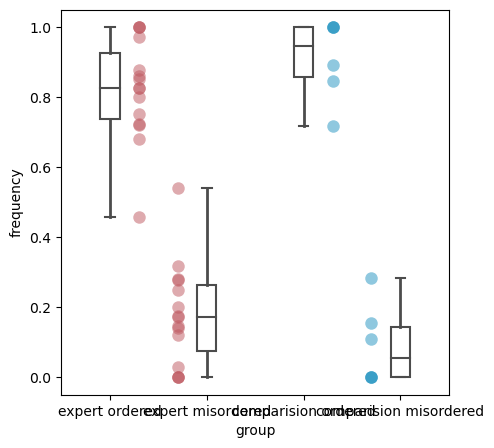

In [319]:
ordered_misordered_bdown =[]
for item in mouse_summed_amounts:
    ordered_misordered_bdown += [list(np.array(item[0:4])/sum(item[0:4]))]
    
e_ordered = []
e_misordered = []
c_ordered = []
c_misordered = []
for index,item in enumerate(ordered_misordered_bdown):
    if expert[index] == 1:
        e_ordered += [sum(item[0:3])]
        e_misordered += [item[-1]]
    else:
        c_ordered += [sum(item[0:3])]
        c_misordered += [item[-1]]
        

fig, ax= plt.subplots(1, 1,figsize=(5, 5))

 
ax.plot(0.3*np.ones(len(e_ordered)),e_ordered, 'o', color = red, alpha = 0.5, markeredgewidth = 0, markersize = 9)
ax.plot(0.7*np.ones(len(e_misordered)),e_misordered, 'o', color = red, alpha = 0.5, markeredgewidth = 0, markersize = 9)
ax.plot(2.3*np.ones(len(c_ordered)),c_ordered, 'o', color = blue, alpha = 0.5, markeredgewidth = 0, markersize = 9)
ax.plot(2.7*np.ones(len(c_misordered)),c_misordered, 'o', color = blue, alpha = 0.5, markeredgewidth = 0, markersize = 9)


    
data = e_ordered+ e_misordered+c_ordered+c_misordered
groups = ['expert ordered'] * len(e_ordered) + ['expert misordered'] * len(e_misordered) + ['comparision ordered'] * len(c_ordered) + ['comparision misordered'] * len(c_misordered) 
plt_df = pd.DataFrame({'group':groups,'frequency': data })
ax=sns.boxplot( y = 'frequency', x = 'group', data = plt_df, color = 'blue', width = .2, zorder = 10,\
            showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
            showfliers=False, whiskerprops = {'linewidth':2, "zorder":10},\
               saturation = 1, orient = 'v',ax = ax)


SaveFig('ordered_vs_misordered.pdf',out_path)

In [320]:
np.mean(e_ordered)


0.8233134162062867

In [321]:
np.mean(c_ordered)

nan

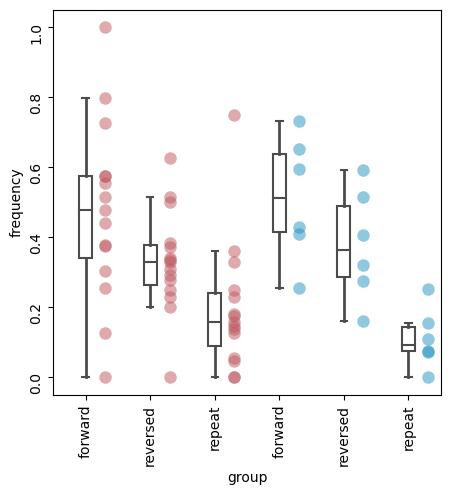

In [322]:


ordered_misordered_bdown =[]
for item in mouse_summed_amounts:
    ordered_misordered_bdown += [list(np.array(item[0:3])/sum(item[0:3]))]

fig, ax= plt.subplots(1, 1,figsize=(5, 5))

e_breakdowns = []
c_breakdowns = []
for index,item in enumerate(ordered_misordered_bdown):
    if expert[index] == 1:
        e_breakdowns += [item]
    else:
        c_breakdowns += [item]
        
for breakdown in e_breakdowns:
    ax.plot([0.3,1.3,2.3],breakdown, 'o', color = red,alpha = 0.5, markeredgewidth = 0, markersize = 9)
for breakdown in c_breakdowns:
    ax.plot([3.3,4.3,5.3],breakdown, 'o', color = blue,alpha = 0.5, markeredgewidth = 0, markersize = 9)
    

data = [item for sublist in conactinate_nth_items(e_breakdowns) + conactinate_nth_items(c_breakdowns) for item in sublist]
groups = ['expert forward']*len(conactinate_nth_items(e_breakdowns)[0])+ ['expert reversed']*len(conactinate_nth_items(e_breakdowns)[1])+['expert repeat']*len(conactinate_nth_items(e_breakdowns)[2])+['comparison forward']*len(conactinate_nth_items(c_breakdowns)[0])+ ['comparison reversed']*len(conactinate_nth_items(c_breakdowns)[1])+['comparison repeat']*len(conactinate_nth_items(c_breakdowns)[2])
plt_df = pd.DataFrame({'group':groups,'frequency': data })
ax=sns.boxplot( y = 'frequency', x = 'group', data = plt_df, color = 'blue', width = .2, zorder = 10,\
            showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
            showfliers=False, whiskerprops = {'linewidth':2, "zorder":10},\
               saturation = 1, orient = 'v',ax = ax)
    
    
labels = ['forward', 'reversed','repeat','forward', 'reversed','repeat']
    
ax.set_xticks(range(0,len(labels)))
ax.set_xticklabels(labels)
ax.tick_params(axis='both', which='major', labelsize=10, rotation =90)

SaveFig('ordered_breakdown.pdf',out_path)

In [323]:

import numpy as np
from scipy.stats import chi2_contingency

# Sample data
category_1 = [10, 20, 30]
category_2 = [15, 25, 10]
category_3 = [5, 15, 25]

# Create a 2D list (contingency table)
observed_data = np.array(conactinate_nth_items(e_breakdowns))

# Perform Chi-squared test for independence
chi2_stat, p_val, dof, expected = chi2_contingency(observed_data)

print("Chi-squared statistic:", chi2_stat)
print("P-value:", p_val)
print("Degrees of freedom:", dof)
print("Expected frequencies:\n", expected)


Chi-squared statistic: 5.342410401448459
P-value: 0.9999990935007899
Degrees of freedom: 28
Expected frequencies:
 [[0.47320932 0.47320932 0.47320932 0.47320932 0.47320932 0.47320932
  0.47320932 0.47320932 0.47320932 0.47320932 0.47320932 0.47320932
  0.47320932 0.47320932 0.47320932]
 [0.33063782 0.33063782 0.33063782 0.33063782 0.33063782 0.33063782
  0.33063782 0.33063782 0.33063782 0.33063782 0.33063782 0.33063782
  0.33063782 0.33063782 0.33063782]
 [0.19615286 0.19615286 0.19615286 0.19615286 0.19615286 0.19615286
  0.19615286 0.19615286 0.19615286 0.19615286 0.19615286 0.19615286
  0.19615286 0.19615286 0.19615286]]


In [324]:
corrected_alpha

0.016666666666666666

In [325]:
results_matrix

array([[0.        , 0.99638457, 0.98811598],
       [0.        , 0.        , 0.99650035],
       [0.        , 0.        , 0.        ]])

In [326]:
e_breakdowns

[[0.3039098610545245, 0.33592773149383953, 0.360162407451636],
 [0.3779594334204636, 0.291899029042837, 0.3301415375366994],
 [0.7990936555891238, 0.20090634441087613, 0.0],
 [0.7251018200330915, 0.22806096474481355, 0.046837215222094955],
 [0.5550525350821521, 0.30811649390028917, 0.1368309710175587],
 [0.5749173581596169, 0.37111246036564804, 0.053970181474735215],
 [0.2544805074829094, 0.5160436041140605, 0.22947588840303015],
 [0.4411219217074792, 0.38304224066966186, 0.17583583762285898],
 [0.4775172682167525, 0.341531277361611, 0.18095145442163632],
 [0.5141351377728619, 0.32873548261166596, 0.15712937961547221],
 [0.375, 0.5, 0.125],
 [0.5748502994011977, 0.27919161676646714, 0.14595808383233536],
 [0.125, 0.625, 0.25],
 [0.0, 0.25, 0.75],
 [1.0, 0.0, 0.0]]

In [327]:
### catagories when considering all motiufs (not just coactive ones)

# relative_amounts,amounts,pair_outcomes,pairs = catagorize_seqs(real_order,num_dominant_seqs,[list(sequential_data.cluster_seq_type.values[sort_index])])


# # # first spike ordering second : 
# summed_amounts = [sum(items) for items in conactinate_nth_items(amounts)]
# labels = ['ordered','reverse','repeat','misordered','other_to_task','task_to_other','other']
# fig, ax = plt.subplots()
# ax.bar(labels,summed_amounts)
# ax.set_title('catagory occurances (all seq ordered by mean times)')

# #     SaveFig('catagory occurances_2___chunk'+ str(index_+1) + '.png',chunk_path)

# all_pair_outcomes_todf = []
# all_pairs_todf = []
# for group in multi_cluster_df.new_cluster_group.unique():
#     group_pairs = np.array(pairs)[multi_cluster_df[multi_cluster_df.new_cluster_group == group].index.values]
#     group_pair_outcomes = np.array(pair_outcomes)[multi_cluster_df[multi_cluster_df.new_cluster_group == group].index.values]
#     all_pairs = []
#     all_pair_outcomes = []
#     for index,pair_ in enumerate(group_pairs[0:-1]):
#         all_pairs += [pair_]
#         all_pair_outcomes += [group_pair_outcomes[index]]

#     all_pair_outcomes_todf  += [all_pair_outcomes] * len(multi_cluster_df[multi_cluster_df.new_cluster_group == group])
#     all_pairs_todf += [all_pairs] * len(multi_cluster_df[multi_cluster_df.new_cluster_group == group])

# multi_cluster_df['pairs_fs_ordering'] = all_pairs_todf
# multi_cluster_df['catagories_fs_ordering'] = all_pair_outcomes_todf


# multi_cluster_df['real_sequence_order'] = [real_order]*len(multi_cluster_df)

# replay types - awake vs sleep correlations and cataogrisation  

In [328]:
## load in data for task vs non task related stuff
import ast
import warnings
warnings.filterwarnings("ignore")

dat_path = r"Z:\projects\sequence_squad\organised_data\ppseq_data\output_data\striatum\New_Post_sleep\\"

expert = []

se_frequencies_awake_sleep_df = pd.DataFrame({})
mouse_summed_amounts = []
for run_index,pp_file in enumerate(os.listdir(dat_path)):
    if not 'sleep_time_points' in pp_file:
        current_mouse_path = dat_path + pp_file + '\\analysis_output'
        mouse = '_'.join(pp_file.split('_')[0:3])
        if mouse in list(expert_mice) + list(compare_mice):
            current_sleep_start = sleep_start[mouse]
            params_file = dat_path + pp_file + r'\trainingData\\' + 'params_' + mouse + '.json'
            with open(params_file, 'r') as file:
                params = json.load(file)
            time_spans = params['time_span']
            print(mouse)

            

            for file in os.listdir(current_mouse_path):
                if 'chunk' in file:
                    # load in chunk time and cluster info 
                    current_data_path = current_mouse_path + '\\' + file + '\\'  
                    
                    chunk_time = np.load(current_data_path + 'chunk_time_interval.npy')
                    
                    replay_clusters_df = pd.read_csv(current_data_path+'filtered_replay_clusters_df.csv')
                    # sequential data only
                    sequential_data = replay_clusters_df[replay_clusters_df.ordering_classification == 'sequential']
                    sequential_data = sequential_data.reset_index(drop = True)

                    
                    try:
                        # single event data:
                        single_event_frequencies_awake_sleep_df = pd.read_csv(current_data_path+'single_event_frequencies_awake_sleep_df.csv')
                        chunk_midpoints = [(sum(chunk_time)/2)-current_sleep_start] *len(single_event_frequencies_awake_sleep_df.seq) 
                        single_event_frequencies_awake_sleep_df['chunk_midpoints'] = chunk_midpoints
                        task_order_seqs = np.load(current_data_path+ 'task_order_seqs.npy')+1
                        task_involved = []
                        for item in single_event_frequencies_awake_sleep_df.seq:
                            if item in task_order_seqs:
                                task_involved +=[1]
                            else:
                                task_involved +=[0]
                        single_event_frequencies_awake_sleep_df['task_involved'] = task_involved   
                        
                        
                        sleep_freqs = []
                        for seq_type in range(1,7):
                            sleep_freqs += [list(sequential_data.cluster_seq_type).count(seq_type) / len(sequential_data.cluster_seq_type)]
                        sleep_freqs = list(np.array(sleep_freqs) * 100)
                        single_event_frequencies_awake_sleep_df['sleep_frequencies'] = sleep_freqs   
                        
                        single_event_frequencies_awake_sleep_df['sleep_frequencies'] = sleep_freqs   
                        
                        chunk_expert = []
                        if mouse in expert_mice:
                            chunk_expert += [1]*6
                        else:
                            chunk_expert += [0]*6

                        single_event_frequencies_awake_sleep_df['expert'] = chunk_expert   
                        

                        se_frequencies_awake_sleep_df = pd.concat([se_frequencies_awake_sleep_df, single_event_frequencies_awake_sleep_df])
                    except:
                        print('data missing? ' + '_'.join(pp_file.split('_')[0:3]))


136_1_3
136_1_4
148_2_2
149_1_1
178_1_4
178_1_5
178_1_6
178_1_7
178_1_8
178_1_9
178_2_1
178_2_2
178_2_3
data missing? 178_2_3
data missing? 178_2_3
178_2_4
255_1_1
255_1_2
255_1_4
data missing? 255_1_4
256_1_1
data missing? 256_1_1
262_1_1
262_1_2
262_1_4
262_1_5
262_1_6
269_1_4
269_1_5
269_1_6
269_1_7
270_1_5
data missing? 270_1_5
270_1_6


In [329]:
def remove_outliers_z_score(x, y, threshold=3):
    z_scores = np.abs((y - np.mean(y)) / np.std(y))
    filtered_indices = z_scores <= threshold
    return x[filtered_indices], y[filtered_indices]

In [330]:


def remove_outliers_iqr(x, y, multiplier=1.5):
    q1 = np.percentile(y, 25)
    q3 = np.percentile(y, 75)
    iqr = q3 - q1
    lower_bound = q1 - multiplier * iqr
    upper_bound = q3 + multiplier * iqr
    filtered_indices = (y >= lower_bound) & (y <= upper_bound)
    return x[filtered_indices], y[filtered_indices]




6.13813342293794e-05
0.00019524678605047088
1.8895270630750453e-05
0.0018369841813758335
0.8165750850647707
0.1569527471480931


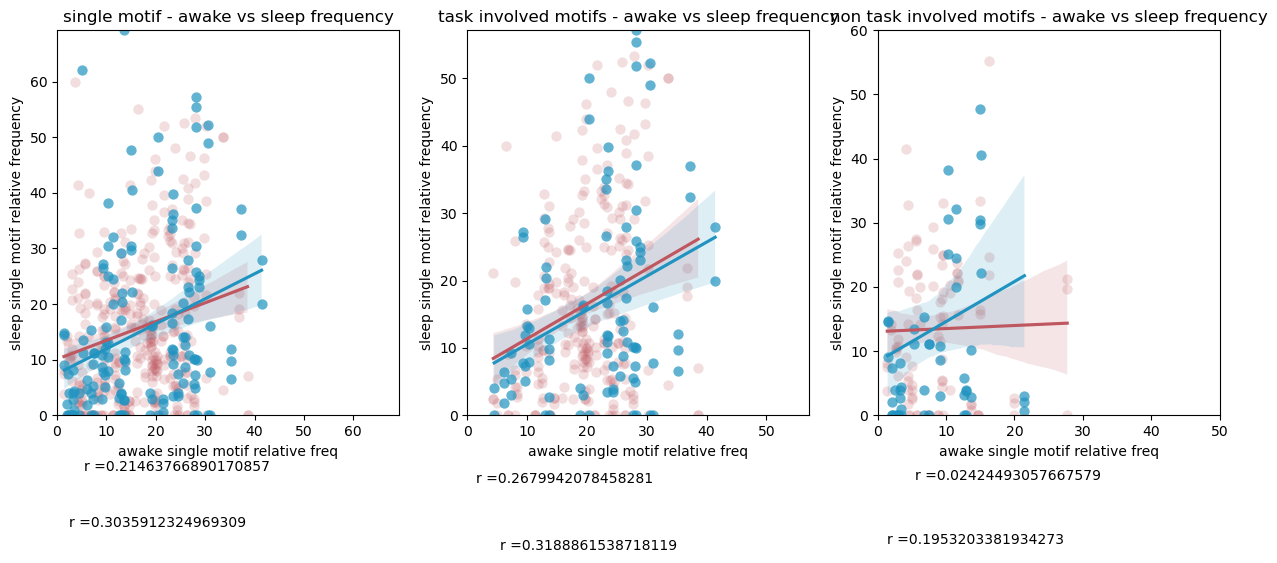

In [331]:
fig, [ax,ax2,ax3]= plt.subplots(1, 3,figsize=(15, 5))

# 1 . # coactive events breakdown across time from sleep onset

expert_df = se_frequencies_awake_sleep_df[se_frequencies_awake_sleep_df.expert == 1]
comparision_df = se_frequencies_awake_sleep_df[se_frequencies_awake_sleep_df.expert == 0]

wake_freqs = expert_df.awake_frequencies.values
sleep_freqs = expert_df.sleep_frequencies.values

x_vals,y_vals = remove_outliers_z_score(wake_freqs,sleep_freqs)

sns.regplot(x =x_vals,y =y_vals,ax =ax, color = red,scatter_kws={'s': 55, 'alpha': 0.2,'linewidths': 0})

ax.set_xlabel('awake single motif relative freq')
ax.set_ylabel('sleep single motif relative frequency')

ax.set_title('single motif - awake vs sleep frequency')

r, p = scipy .stats.pearsonr(x_vals,y_vals)

print(p)

ax.text(5.4,-10,'r =' + str(r) )

lim1 = max(max(x_vals),max(y_vals))



#### same but  comparison data
wake_freqs = comparision_df.awake_frequencies.values
sleep_freqs = comparision_df.sleep_frequencies.values

x_vals,y_vals = remove_outliers_z_score(wake_freqs,sleep_freqs)

sns.regplot(x =x_vals,y =y_vals,ax =ax, color = blue,scatter_kws={'s': 55, 'alpha': 0.7,'linewidths': 0})

r, p = scipy .stats.pearsonr(x_vals,y_vals)

print(p)

ax.text(2.4,-20,'r =' + str(r) )

xlim= max(max(x_vals),max(y_vals),lim1)
ylim= max(max(x_vals),max(y_vals),lim1)
ax.set_xlim(0,xlim)
ax.set_ylim(0,ylim)



# 2 . ### same but task involved only:


task_expert_df = expert_df[expert_df.task_involved == 1]
task_comparision_df = comparision_df[comparision_df.task_involved == 1]

wake_freqs = task_expert_df.awake_frequencies.values
sleep_freqs = task_expert_df.sleep_frequencies.values

x_vals,y_vals = remove_outliers_z_score(wake_freqs,sleep_freqs)

sns.regplot(x =x_vals,y =y_vals,ax =ax2, color = red,scatter_kws={'s': 55, 'alpha': 0.2,'linewidths': 0})

ax2.set_xlabel('awake single motif relative freq')
ax2.set_ylabel('sleep single motif relative frequency')

ax2.set_title('task involved motifs - awake vs sleep frequency')

r, p = scipy .stats.pearsonr(x_vals,y_vals)

print(p)

ax2.text(1.4,-10,'r =' + str(r) )

lim1 = max(max(x_vals),max(y_vals))

#### same but  comparison data
wake_freqs = task_comparision_df.awake_frequencies.values
sleep_freqs = task_comparision_df.sleep_frequencies.values

x_vals,y_vals = remove_outliers_z_score(wake_freqs,sleep_freqs)

sns.regplot(x =x_vals,y =y_vals,ax =ax2, color = blue,scatter_kws={'s': 55, 'alpha': 0.7,'linewidths': 0})

r, p = scipy .stats.pearsonr(x_vals,y_vals)

print(p)

ax2.text(5.4,-20,'r =' + str(r) )

xlim= max(max(x_vals),max(y_vals),lim1)
ylim= max(max(x_vals),max(y_vals),lim1)
ax2.set_xlim(0,xlim)
ax2.set_ylim(0,ylim)


# 3 . ### same but non task involved only:


task_expert_df = expert_df[expert_df.task_involved == 0]
task_comparision_df = comparision_df[comparision_df.task_involved == 0]

wake_freqs = task_expert_df.awake_frequencies.values
sleep_freqs = task_expert_df.sleep_frequencies.values

x_vals,y_vals = remove_outliers_z_score(wake_freqs,sleep_freqs)

sns.regplot(x =x_vals,y =y_vals,ax =ax3, color = red, scatter_kws={'s': 55, 'alpha': 0.2,'linewidths': 0})

ax3.set_xlabel('awake single motif relative freq')
ax3.set_ylabel('sleep single motif relative frequency')

ax3.set_title('non task involved motifs - awake vs sleep frequency')

r, p = scipy .stats.pearsonr(x_vals,y_vals)

print(p)

ax3.text(5.4,-10,'r =' + str(r) )

lim1 = max(max(x_vals),max(y_vals))

#### same but  comparison data
wake_freqs = task_comparision_df.awake_frequencies.values
sleep_freqs = task_comparision_df.sleep_frequencies.values

x_vals,y_vals = remove_outliers_z_score(wake_freqs,sleep_freqs)

sns.regplot(x =x_vals,y =y_vals,ax =ax3, color = blue,scatter_kws={'s': 55, 'alpha': 0.7,'linewidths': 0})

r, p = scipy .stats.pearsonr(x_vals,y_vals)

print(p)

ax3.text(1.4,-20,'r =' + str(r) )

xlim= max(max(x_vals),max(y_vals),lim1)
ylim= max(max(x_vals),max(y_vals),lim1)
ax3.set_xlim(0,50)
ax3.set_ylim(0,60)

SaveFig('motif_awake_sleep_freq.pdf',out_path)

In [341]:
# expert_df = se_frequencies_awake_sleep_df[se_frequencies_awake_sleep_df.expert == 1]
# comparision_df = se_frequencies_awake_sleep_df[se_frequencies_awake_sleep_df.expert == 0]

# wake_freqs = expert_df.awake_frequencies.values
# sleep_freqs = expert_df.sleep_frequencies.values

# x_vals1,y_vals1 = remove_outliers_z_score(wake_freqs,sleep_freqs)


# wake_freqs = comparision_df.awake_frequencies.values
# sleep_freqs = comparision_df.sleep_frequencies.values

# x_vals2,y_vals2 = remove_outliers_z_score(wake_freqs,sleep_freqs)

####################

# task_expert_df = expert_df[expert_df.task_involved == 1]
# task_comparision_df = comparision_df[comparision_df.task_involved == 1]

# wake_freqs = task_expert_df.awake_frequencies.values
# sleep_freqs = task_expert_df.sleep_frequencies.values

# x_vals12,y_vals12 = remove_outliers_z_score(wake_freqs,sleep_freqs)

# wake_freqs = task_comparision_df.awake_frequencies.values
# sleep_freqs = task_comparision_df.sleep_frequencies.values

# x_vals2,y_vals2 = remove_outliers_z_score(wake_freqs,sleep_freqs)

###################

task_expert_df = expert_df[expert_df.task_involved == 0]
task_comparision_df = comparision_df[comparision_df.task_involved == 0]

wake_freqs = task_expert_df.awake_frequencies.values
sleep_freqs = task_expert_df.sleep_frequencies.values

x_vals1,y_vals1 = remove_outliers_z_score(wake_freqs,sleep_freqs)
wake_freqs = task_comparision_df.awake_frequencies.values
sleep_freqs = task_comparision_df.sleep_frequencies.values

x_vals2,y_vals2 = remove_outliers_z_score(wake_freqs,sleep_freqs)



In [342]:
##  combined linear regression and analysis of variance (ANOVA) approach. interaction effect 


import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Create sample data
group1_x = np.array(x_vals1)
group1_y = np.array(y_vals1)

group2_x = np.array(x_vals2)
group2_y = np.array(y_vals2)

# Combine data
x = np.concatenate([group1_x, group2_x])
y = np.concatenate([group1_y, group2_y])

# Create a categorical variable for group membership
groups = np.array(['Group1'] * len(group1_x) + ['Group2'] * len(group2_x))

# Fit separate regression models for each group
model_group1 = sm.OLS(group1_y, sm.add_constant(group1_x)).fit()
model_group2 = sm.OLS(group2_y, sm.add_constant(group2_x)).fit()

# Fit combined regression model with interaction term
model_combined = ols('y ~ x + C(groups) + x:C(groups)', data={'x': x, 'y': y, 'groups': groups}).fit()

# Compare models using ANOVA or likelihood ratio test
anova_table = sm.stats.anova_lm(model_combined, typ=2)

# Print the ANOVA table
print(anova_table)

# Check if interaction term is significant
if anova_table['PR(>F)'][3] < 0.05:
    print("Interaction term is significant. The regression lines are different.")
else:
    print("Interaction term is not significant. The regression lines are not significantly different.")



                   sum_sq     df         F    PR(>F)
C(groups)        2.662619    1.0  0.014047  0.905819
x              291.623948    1.0  1.538549  0.216851
x:C(groups)    349.142647    1.0  1.842006  0.176839
Residual     27294.451071  144.0       NaN       NaN
Interaction term is not significant. The regression lines are not significantly different.


Group 1 Linear Regression:
Slope: 0.04737970619859038
Intercept: 13.03749933375995
R-squared: 0.0005878166586678271
P-value: 0.8165750850647726

Group 2 Linear Regression:
Slope: 0.6234693689509041
Intercept: 8.360348483046382
R-squared: 0.038150034511994856
P-value: 0.1569527471480933


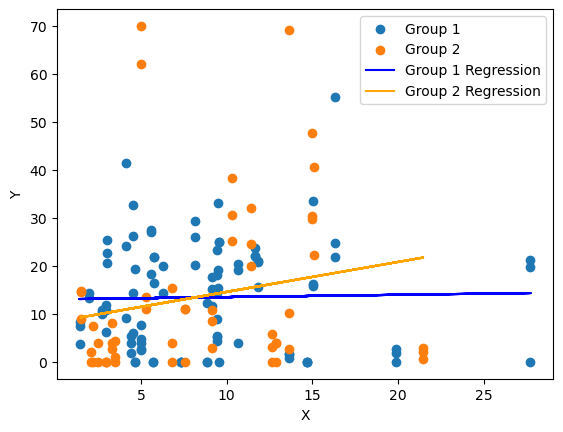

In [343]:
### just regression to see if lines are significant

import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt

# Perform linear regression for each group
slope_group1, intercept_group1, r_value_group1, p_value_group1, std_err_group1 = linregress(group1_x, group1_y)
slope_group2, intercept_group2, r_value_group2, p_value_group2, std_err_group2 = linregress(group2_x, group2_y)

# Print regression results for each group
print("Group 1 Linear Regression:")
print("Slope:", slope_group1)
print("Intercept:", intercept_group1)
print("R-squared:", r_value_group1**2)
print("P-value:", p_value_group1)

print("\nGroup 2 Linear Regression:")
print("Slope:", slope_group2)
print("Intercept:", intercept_group2)
print("R-squared:", r_value_group2**2)
print("P-value:", p_value_group2)

# Plot the scatter plot and regression lines
plt.scatter(group1_x, group1_y, label='Group 1')
plt.scatter(group2_x, group2_y, label='Group 2')
plt.plot(group1_x, intercept_group1 + slope_group1 * group1_x, color='blue', label='Group 1 Regression')
plt.plot(group2_x, intercept_group2 + slope_group2 * group2_x, color='orange', label='Group 2 Regression')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()


In [1259]:
xlim

58.076225045372055

5.3517919023554035e-20
3.2056532356581635e-23
1.415956238090599e-05


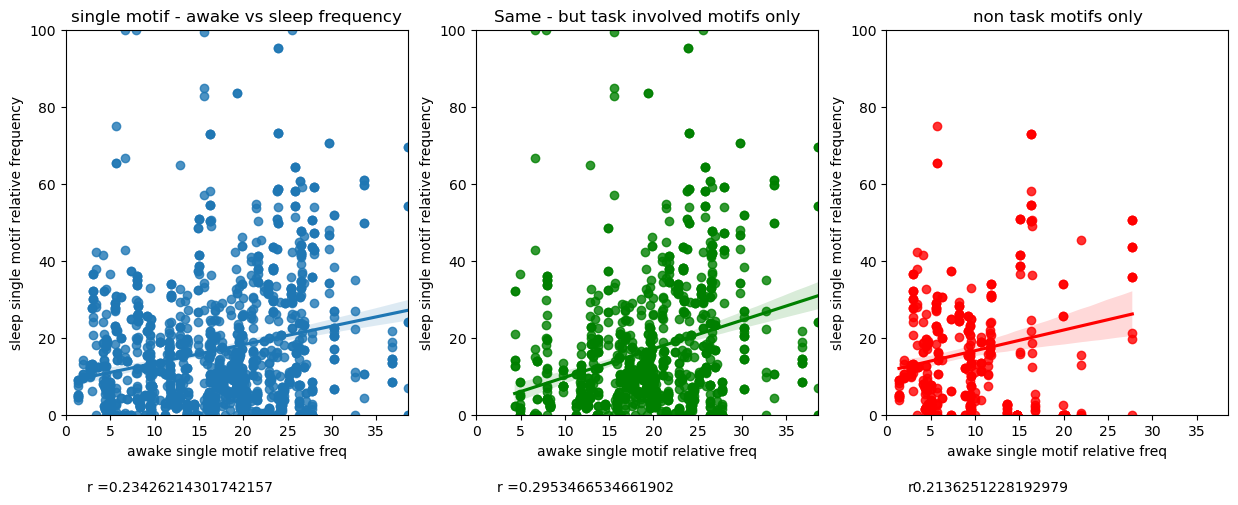

In [1227]:
task_ivolved_se_freqs = se_frequencies_awake_sleep_df[se_frequencies_awake_sleep_df.task_involved == 1]

# coactive events breakdown across time from sleep onset
x_vals = list(task_ivolved_se_freqs.awake_frequencies.values)
y_vals = list(task_ivolved_se_freqs.sleep_frequencies.values)

sns.regplot(x =x_vals,y =y_vals,ax =ax2, color = 'green')

ax2.set_xlabel('awake single motif relative freq')
ax2.set_ylabel('sleep single motif relative frequency')

ax2.set_title('Same - but task involved motifs only')

r, p = scipy .stats.pearsonr(x_vals,y_vals)

print(p)

ax2.text(2.4,-20,'r =' + str(r) )

ax2.set_xlim(0,xlim)
ax2.set_ylim(0,ylim)


### same but task not involved only:


task_ivolved_se_freqs = se_frequencies_awake_sleep_df[se_frequencies_awake_sleep_df.task_involved == 0]

# coactive events breakdown across time from sleep onset
x_vals = list(task_ivolved_se_freqs.awake_frequencies.values)
y_vals = list(task_ivolved_se_freqs.sleep_frequencies.values)

sns.regplot(x =x_vals,y =y_vals,ax =ax3, color = 'red')

ax3.set_xlabel('awake single motif relative freq')
ax3.set_ylabel('sleep single motif relative frequency')

ax3.set_title('non task motifs only')

r, p = scipy .stats.pearsonr(x_vals,y_vals)

print(p)

ax3.text(2.4,-20,'r' + str(r) )

ax3.set_xlim(0,xlim)
ax3.set_ylim(0,ylim)



SaveFig('single_motifs_awake_sleep_correlation',out_path)

In [969]:
## load in data for task vs non task related stuff       
import pickle

dat_path = r"Z:\projects\sequence_squad\organised_data\ppseq_data\output_data\striatum\New_Post_sleep\\"

chunk_midpoints = []
mirs = []

se_frequencies_awake_sleep_df = pd.DataFrame({'seq':[],
 'awake_frequencies':[],
 'reward_related_awake_frequencies':[],
 'sleep_frequencies':[],
 'chunk_midpoints':[],
 'task_involved':[]})

standard_transit_frequencies_awake_sleep_df= pd.DataFrame({'transition':[],
 'catagory':[],
 'awake_event_transitions':[],
 'mean_spike_ordered_sleep_frequencies':[],
 'fs_ordered_sleep_frequencies':[],
 'mouse':[],
 'chunk_midpoints':[]})

reward_related_transit_frequencies_awake_sleep_df= pd.DataFrame({'transition':[],
 'catagory':[],
 'reward_event_transitions':[],
 'mean_spike_ordered_sleep_frequencies':[],
 'fs_ordered_sleep_frequencies':[],
 'mouse':[],
 'chunk_midpoints':[]})



for run_index,pp_file in enumerate(os.listdir(dat_path)):
    if not 'sleep_time_points' in pp_file:
        mirs += ['_'.join(pp_file.split('_')[0:3])]
        current_mouse_path = dat_path + pp_file + '\\analysis_output'
        mouse = '_'.join(pp_file.split('_')[0:3])
        if mouse in expert_mice:
            current_sleep_start = sleep_start[mouse]
            params_file = dat_path + pp_file + r'\trainingData\\' + 'params_' + mouse + '.json'
            with open(params_file, 'r') as file:
                params = json.load(file)
            time_spans = params['time_span']
            
            event_rate_chunk = {}
            for file in os.listdir(current_mouse_path):
                if 'chunk' in file:                    
                    # load in chunk time and cluster info 
                    current_data_path = current_mouse_path + '\\' + file + '\\'
                    chunk_time = np.load(current_data_path + 'chunk_time_interval.npy')
                    
        
                    ### load in data for these plots:
                    try:
#                         with open(current_data_path + 'awake_event_transitions.pickle', 'rb') as handle:
#                             awake_event_transitions = pickle.load(handle)

#                         with open(current_data_path + 'sleep_event_transitions_first_spike_time_ordered.pickle', 'rb') as handle:
#                             sleep_event_transitions_first_spike_time_ordered = pickle.load(handle)

#                         with open(current_data_path + 'sleep_event_transitions_mean_spike_time_ordered.pickle', 'rb') as handle:
#                             sleep_event_transitions_mean_spike_time_ordered = pickle.load(handle)

#                         with open(current_data_path + 'reward_releated_awake_event_transitions.pickle', 'rb') as handle:
#                             reward_releated_awake_event_transitions= pickle.load(handle)

                        # single event data:
                        single_event_frequencies_awake_sleep_df = pd.read_csv(current_data_path+'single_event_frequencies_awake_sleep_df.csv')
                        chunk_midpoints = [(sum(chunk_time)/2)-current_sleep_start] *len(single_event_frequencies_awake_sleep_df.seq) 
                        single_event_frequencies_awake_sleep_df['chunk_midpoints'] = chunk_midpoints
                        task_order_seqs = np.load(current_data_path+ 'task_order_seqs.npy')+1
                        task_involved = []
                        for item in single_event_frequencies_awake_sleep_df.seq:
                            if item in task_order_seqs:
                                task_involved +=[1]
                            else:
                                task_involved +=[0]
                        single_event_frequencies_awake_sleep_df['task_involved'] = task_involved                    
                        se_frequencies_awake_sleep_df = pd.concat([se_frequencies_awake_sleep_df, single_event_frequencies_awake_sleep_df])

                        # standard
                        transit_frequencies_awake_sleep_df = pd.read_csv(current_data_path+'transit_frequencies_awake_sleep_df.csv')
                        transit_frequencies_awake_sleep_df['mouse'] = len(transit_frequencies_awake_sleep_df.catagory) * ['_'.join(pp_file.split('_')[0:3])]
                        chunk_midpoints = [(sum(chunk_time)/2)-current_sleep_start] *len(transit_frequencies_awake_sleep_df.catagory) 
                        transit_frequencies_awake_sleep_df['chunk_midpoints'] = chunk_midpoints
                        standard_transit_frequencies_awake_sleep_df = pd.concat([standard_transit_frequencies_awake_sleep_df, transit_frequencies_awake_sleep_df])

                        #reward related
                        Rewarded_transit_frequencies_awake_sleep_df = pd.read_csv(current_data_path+'Rewarded_transit_frequencies_awake_sleep_df.csv')
                        Rewarded_transit_frequencies_awake_sleep_df['mouse'] = len(Rewarded_transit_frequencies_awake_sleep_df.catagory) * ['_'.join(pp_file.split('_')[0:3])]
                        chunk_midpoints = [(sum(chunk_time)/2)-current_sleep_start] *len(Rewarded_transit_frequencies_awake_sleep_df.catagory) 
                        Rewarded_transit_frequencies_awake_sleep_df['chunk_midpoints'] = chunk_midpoints
                        reward_related_transit_frequencies_awake_sleep_df = pd.concat([reward_related_transit_frequencies_awake_sleep_df, Rewarded_transit_frequencies_awake_sleep_df])
                        
                    except:
                        print('data not processed yet ' + '_'.join(pp_file.split('_')[0:3]))
                        


data not processed yet 178_2_3
data not processed yet 178_2_3


# correlation analysis:

In [279]:
## awake vs sleep event frequency 
# single event freq awake vs sleep
# same again but for rewarded event

# transition event frequency awake vs sleep
# same again but for rewarded events

# correlation against time? 

In [280]:
se_frequencies_awake_sleep_df

,seq,awake_frequencies,reward_related_awake_frequencies,sleep_frequencies,chunk_midpoints,task_involved
0,1.0,26.479438,31.854839,41.523810,700.0,1.0
1,2.0,24.373119,10.483871,2.571429,700.0,1.0
2,3.0,8.324975,4.838710,2.095238,700.0,1.0
3,4.0,21.063190,37.096774,10.380952,700.0,1.0
4,5.0,8.124373,1.612903,24.476190,700.0,0.0
...,...,...,...,...,...,...
1,2.0,26.390403,22.295082,30.714286,9450.0,1.0
2,3.0,7.306434,7.540984,25.000000,9450.0,0.0
3,4.0,5.016358,1.311475,2.857143,9450.0,0.0
4,5.0,19.847328,10.819672,12.142857,9450.0,1.0


Single events awake vs sleep

Single events Reward related awake vs sleep

p = 0.03478869943689499
p = 0.08823886786560092


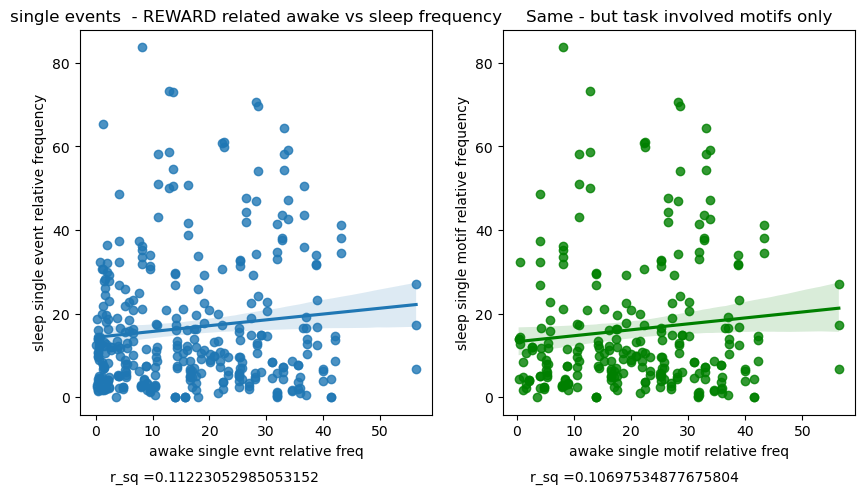

In [282]:
# coactive events breakdown across time from sleep onset

x_vals = list(se_frequencies_awake_sleep_df.reward_related_awake_frequencies.values)
y_vals = list(se_frequencies_awake_sleep_df.sleep_frequencies.values)



fig, [ax,ax2]= plt.subplots(1, 2,figsize=(10, 5))
sns.regplot(x =x_vals,y =y_vals,ax =ax)

ax.set_xlabel('awake single evnt relative freq')
ax.set_ylabel('sleep single event relative frequency')

ax.set_title('single events  - REWARD related awake vs sleep frequency')

r, p = scipy .stats.pearsonr(x_vals,y_vals)

print('p = ' + str(p))

ax.text(2.4,-20,'r_sq =' + str(r) )


### same but task involved only:

task_ivolved_se_freqs = se_frequencies_awake_sleep_df[se_frequencies_awake_sleep_df.task_involved == 1]

# coactive events breakdown across time from sleep onset
x_vals = list(task_ivolved_se_freqs.reward_related_awake_frequencies.values)
y_vals = list(task_ivolved_se_freqs.sleep_frequencies.values)

sns.regplot(x =x_vals,y =y_vals,ax =ax2, color = 'green')

ax2.set_xlabel('awake single motif relative freq')
ax2.set_ylabel('sleep single motif relative frequency')

ax2.set_title('Same - but task involved motifs only')

r, p = scipy .stats.pearsonr(x_vals,y_vals)

print('p = ' + str(p))

ax2.text(2.4,-20,'r_sq =' + str(r) )

SaveFig('reward_reated_single_motifs_awake_sleep_correlation',out_path)

Multi (coactive events) awake vs sleep

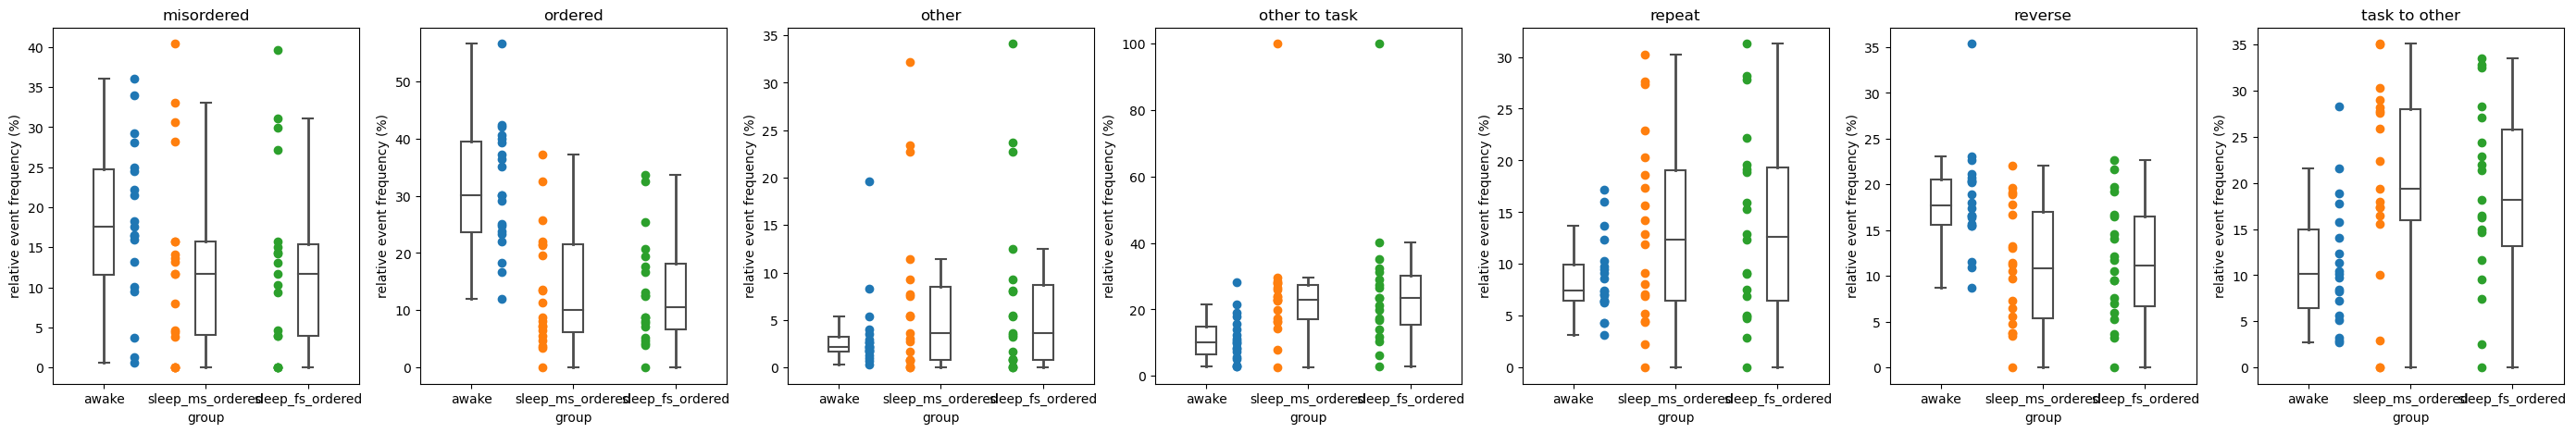

In [283]:
#relative amoutn of each in awake and sleep:

# Group the dataframe by 'categories'
grouped_df = standard_transit_frequencies_awake_sleep_df.groupby('catagory')

# Get the number of unique categories
num_categories = len(grouped_df)

# Create subplots
fig, axes = plt.subplots(1,num_categories, figsize=(5*num_categories,5))

# Iterate over each category and subplot
for i, (category, group) in enumerate(grouped_df):
    awake_mean = []
    sleep_mean_mo = []
    sleep_mean_fso = []
    for index,(mouse_ID,mouse_df) in enumerate(group.groupby('mouse')):
        awake_sums = []
        sleep_sums_mo = []
        sleep_sums_fso = []
        for index,(chunk_ID,chunk_df) in enumerate(mouse_df.groupby('chunk_midpoints')):
            awake_sums += [sum(chunk_df.awake_event_transitions)]
            sleep_sums_mo += [sum(chunk_df.mean_spike_ordered_sleep_frequencies)]
            sleep_sums_fso += [sum(chunk_df.fs_ordered_sleep_frequencies)]
        awake_mean += [np.mean(awake_sums)]
        sleep_mean_mo += [np.mean(sleep_sums_mo)]
        sleep_mean_fso += [np.mean(sleep_sums_fso)]
        
    axes[i].set_title(category)
    axes[i].plot(np.ones(len(awake_mean))*0.3,awake_mean,'o')
    axes[i].plot(np.ones(len(sleep_mean_mo))*0.7,sleep_mean_mo,'o')
    axes[i].plot(np.ones(len(sleep_mean_fso))*1.7,sleep_mean_fso,'o')

    data = awake_mean + sleep_mean_mo + sleep_mean_fso
    groups = (['awake']*len(awake_mean)) +(['sleep_ms_ordered']*len(sleep_mean_mo)) + (['sleep_fs_ordered']*len(sleep_mean_fso))
    plt_df = pd.DataFrame({'group':groups,'relative event frequency (%)': data })
    ax=sns.boxplot( y = 'relative event frequency (%)', x = 'group', data = plt_df, color = 'blue', width = .2, zorder = 10,\
                showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
                showfliers=False, whiskerprops = {'linewidth':2, "zorder":10},\
                   saturation = 1, orient = 'v',ax = axes[i])
    
SaveFig('catagory_transition_frequencies_awake-vs-sleep',out_path)

2.3241423071078736e-05
5.613187364966334e-06


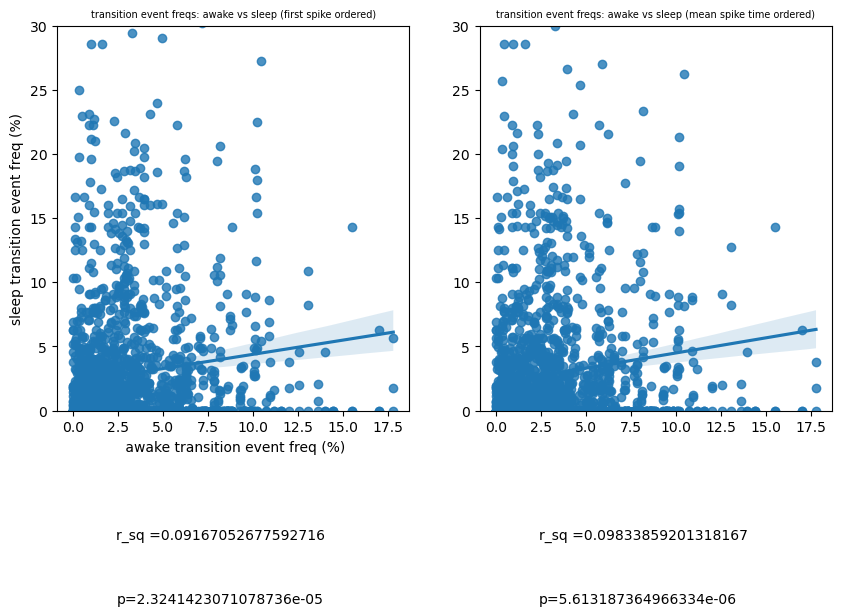

In [284]:
fig,[ax,ax2]= plt.subplots(1, 2,figsize=(10, 5))



sns.regplot(y=list(standard_transit_frequencies_awake_sleep_df.fs_ordered_sleep_frequencies.values), x=list(standard_transit_frequencies_awake_sleep_df.awake_event_transitions.values), ax = ax)
sns.regplot(y=list(standard_transit_frequencies_awake_sleep_df.mean_spike_ordered_sleep_frequencies.values), x=list(standard_transit_frequencies_awake_sleep_df.awake_event_transitions.values), ax = ax2)

r, p = scipy .stats.pearsonr(y=list(standard_transit_frequencies_awake_sleep_df.fs_ordered_sleep_frequencies.values), x=list(standard_transit_frequencies_awake_sleep_df.awake_event_transitions.values))
print(p)
ax.text(2.4,-10,'r_sq =' + str(r) )
ax.text(2.4,-15,'p=' + str(p) )

r, p = scipy .stats.pearsonr(y=list(standard_transit_frequencies_awake_sleep_df.mean_spike_ordered_sleep_frequencies.values), x=list(standard_transit_frequencies_awake_sleep_df.awake_event_transitions.values))
print(p)
ax2.text(2.4,-10,'r_sq =' + str(r) )
ax2.text(2.4,-15,'p=' + str(p) )

ax.set_title('transition event freqs: awake vs sleep (first spike ordered)', size =7)
ax2.set_title('transition event freqs: awake vs sleep (mean spike time ordered)', size =7)
ax.set_xlabel(' awake transition event freq (%)')
ax.set_ylabel('sleep transition event freq (%)')

ax.set_ylim(0,30)
ax2.set_ylim(0,30)

SaveFig('all_transition_frequencies_awake-vs-sleep',out_path)

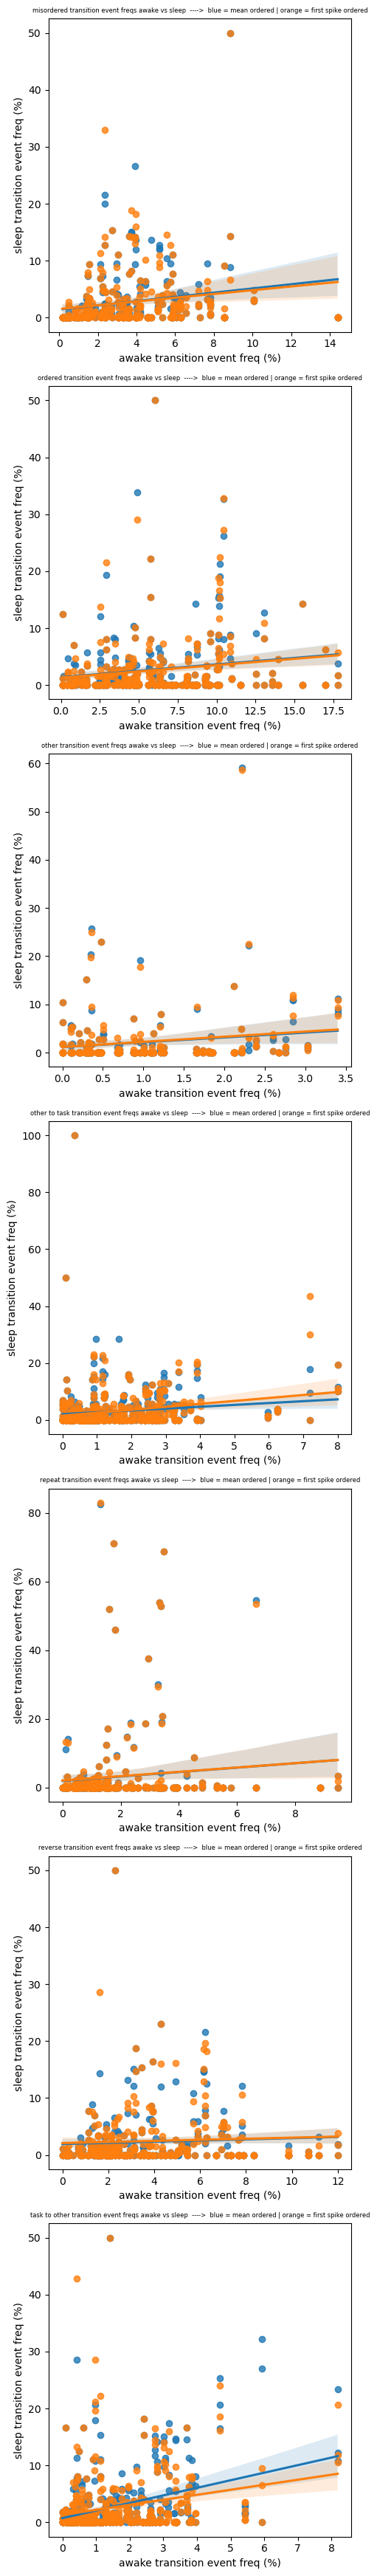

In [285]:
# Group the dataframe by 'categories'
grouped_df = standard_transit_frequencies_awake_sleep_df.groupby('catagory')

# Get the number of unique categories
num_categories = len(grouped_df)

# Create subplots
fig, axes = plt.subplots(num_categories, 1, figsize=(5, 5*num_categories))

# Iterate over each category and subplot
for i, (category, group) in enumerate(grouped_df):
    awake_event_freqs = group.awake_event_transitions.values
    mo_sleep_freqs = group.mean_spike_ordered_sleep_frequencies.values
    fs_sleep_freqs = group.fs_ordered_sleep_frequencies.values

    sns.regplot(y=mo_sleep_freqs, x=awake_event_freqs, ax = axes[i])
    sns.regplot(y=fs_sleep_freqs, x=awake_event_freqs, ax = axes[i])
    axes[i].set_title(category + ' transition event freqs awake vs sleep  ' + '---->' + '  blue = mean ordered | orange = first spike ordered', size = 6)

    axes[i].set_xlabel('awake transition event freq (%)')
    axes[i].set_ylabel('sleep transition event freq (%)')

# Adjust spacing between subplots
plt.tight_layout()

SaveFig('catagorised_transition_frequencies_awake-vs-sleep',out_path)

Multi (coactive events) REWARD related awake vs sleep

0.0028815241005457665
0.0015956967283723


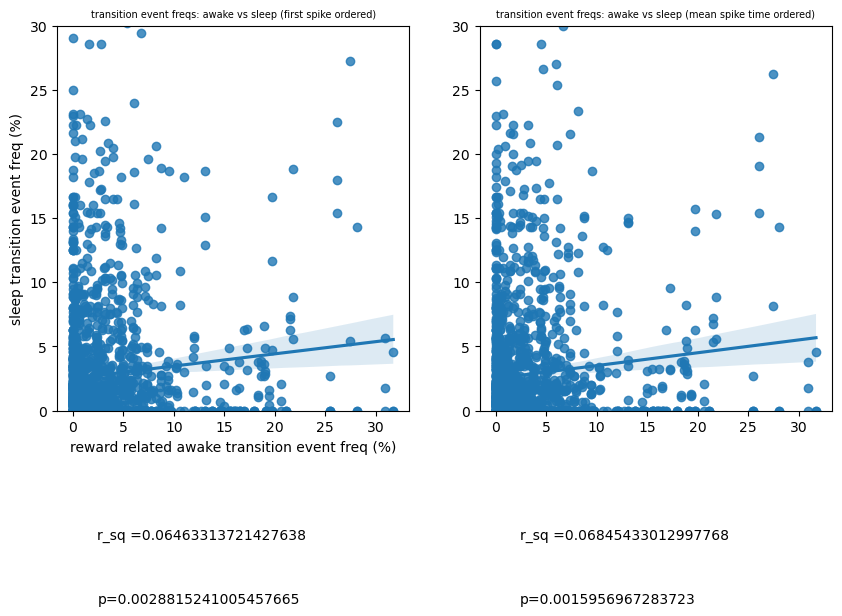

In [286]:
fig,[ax,ax2]= plt.subplots(1, 2,figsize=(10, 5))



sns.regplot(y=list(reward_related_transit_frequencies_awake_sleep_df.fs_ordered_sleep_frequencies.values), x=list(reward_related_transit_frequencies_awake_sleep_df.reward_event_transitions.values), ax = ax)
sns.regplot(y=list(reward_related_transit_frequencies_awake_sleep_df.mean_spike_ordered_sleep_frequencies.values), x=list(reward_related_transit_frequencies_awake_sleep_df.reward_event_transitions.values), ax = ax2)

r, p = scipy .stats.pearsonr(y=list(reward_related_transit_frequencies_awake_sleep_df.fs_ordered_sleep_frequencies.values), x=list(reward_related_transit_frequencies_awake_sleep_df.reward_event_transitions.values))
print(p)
ax.text(2.4,-10,'r_sq =' + str(r) )
ax.text(2.4,-15,'p=' + str(p) )

r, p = scipy .stats.pearsonr(y=list(reward_related_transit_frequencies_awake_sleep_df.mean_spike_ordered_sleep_frequencies.values), x=list(reward_related_transit_frequencies_awake_sleep_df.reward_event_transitions.values))
print(p)
ax2.text(2.4,-10,'r_sq =' + str(r) )
ax2.text(2.4,-15,'p=' + str(p) )

ax.set_title('transition event freqs: awake vs sleep (first spike ordered)', size =7)
ax2.set_title('transition event freqs: awake vs sleep (mean spike time ordered)', size =7)
ax.set_xlabel('reward related awake transition event freq (%)')
ax.set_ylabel('sleep transition event freq (%)')

ax.set_ylim(0,30)
ax2.set_ylim(0,30)

SaveFig('all_transition_frequencies_reward-related-awake-vs-sleep',out_path)

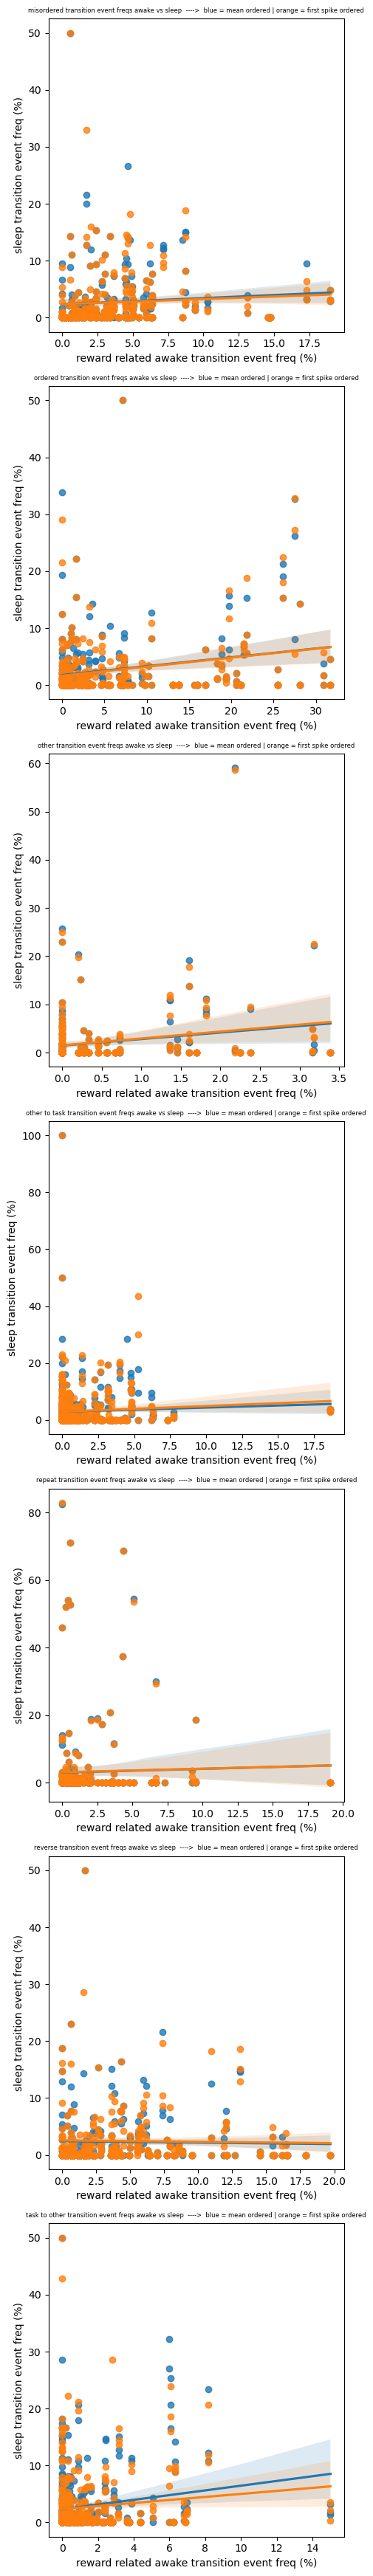

In [287]:
# Group the dataframe by 'categories'
grouped_df = reward_related_transit_frequencies_awake_sleep_df.groupby('catagory')

# Get the number of unique categories
num_categories = len(grouped_df)

# Create subplots
fig, axes = plt.subplots(num_categories, 1, figsize=(5, 5*num_categories))

# Iterate over each category and subplot
for i, (category, group) in enumerate(grouped_df):
    r_event_freqs = group.reward_event_transitions.values
    mo_sleep_freqs = group.mean_spike_ordered_sleep_frequencies.values
    fs_sleep_freqs = group.fs_ordered_sleep_frequencies.values

    sns.regplot(y=mo_sleep_freqs, x=r_event_freqs, ax = axes[i])
    sns.regplot(y=fs_sleep_freqs, x=r_event_freqs, ax = axes[i])
    axes[i].set_title(category + ' transition event freqs awake vs sleep  ' + '---->' + '  blue = mean ordered | orange = first spike ordered', size = 6)

    axes[i].set_xlabel('reward related awake transition event freq (%)')
    axes[i].set_ylabel('sleep transition event freq (%)')

# Adjust spacing between subplots
plt.tight_layout()

SaveFig('catagorised_transition_frequencies_reward-related-awake-vs-sleep',out_path)

In [ ]:
mouse

In [ ]:
current_cluster

In [ ]:
current_cluster.cluster_spike_times


In [1283]:
order = []
for group in replay_clusters_df.coactive_cluster_group.unique():
    group_mask = replay_clusters_df.coactive_cluster_group == group
    current_cluster = replay_clusters_df[group_mask]
    if len(current_cluster) > 1:
        means = []
        event_types = []
        fs_orders = []
        for index,events in enumerate(current_cluster.cluster_spike_times):
            event_types += [current_cluster.cluster_seq_type.values[index]]
            # calculate event order based on spike time weighted mean
            means += [np.mean(ast.literal_eval(events))]
            # calculate order based on first spike time:
            fs_orders += [current_cluster.first_spike_time.values[index]]

        # order by mean time:    
        order += [list(np.array(event_types)[np.argsort(means)])]
        # order by first spike:
        # order += [list(np.array(event_types)[np.argsort(fs_orders)])]


In [ ]:
# I need to work out the most common sequence transition during the task and see if they match up...? 
# also the rlative proportions of sequences we see during the task vs during sleep. 
# would also be good to look at reward times and see if this corresponds to replay 

In [1287]:
for seq_order in order:
    seq_order

In [1288]:
seq_order

[5, 6]

In [1286]:
task_order

array([0, 2, 5, 4, 3])

In [1290]:
if [0,2] in task_order:
    print('y')

C:\Users\Emmett\AppData\Local\Temp\ipykernel_15548\3952964456.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if [0,2] in task_order:


In [1291]:
task_order

array([0, 2, 5, 4, 3])

In [1242]:
order

NameError: name 'order' is not defined

array([1, 0], dtype=int64)

In [1222]:
current_cluster.cluster_spike_times

'[2006.7727, 2006.7824, 2006.8222, 2006.7521, 2006.763, 2006.7651, 2006.7731, 2006.7823, 2006.7412, 2006.7492, 2006.7617, 2006.7626, 2006.7645, 2006.7697, 2006.7822, 2006.7828, 2006.7839, 2006.741, 2006.7487, 2006.7492, 2006.7521, 2006.7624, 2006.7688, 2006.7419, 2006.7474, 2006.752, 2006.7493, 2006.7504, 2006.7521, 2006.7643, 2006.7698, 2006.7626, 2006.7726, 2006.7492, 2006.7697, 2006.7314, 2006.7411, 2006.7419, 2006.7475, 2006.7616, 2006.7625, 2006.7646, 2006.7726, 2006.7825, 2006.6951, 2006.7492, 2006.7829, 2006.7697, 2006.715, 2006.7294, 2006.7325, 2006.7411, 2006.7421, 2006.7475, 2006.7493, 2006.7521, 2006.7617, 2006.773, 2006.7217, 2006.7253, 2006.742, 2006.7492, 2006.7616, 2006.7149, 2006.7228, 2006.7308, 2006.7315, 2006.7324, 2006.7411, 2006.7475, 2006.752, 2006.7625, 2006.7646, 2006.7696, 2006.7726, 2006.7734, 2006.7825]'

In [1214]:
## decide which order the are in....order weight by spikes 
## then deeicde what kind of event it is:
# single event
# multiple single events
# ordered event
# ordered backwards event
# disordered event

## proportion of multi event replays thatare task related vs non task related? 

## save out this data becaus eit is essential for LFP stuff

## plot proportions of each 
## plot against time 

In [ ]:
# plot types of replays we see 
# plot types of replays we see, # types - backwards, misordered, ordered, repeating etc. in proportion

# are single events a temporal order of spikes???? are they in the same order as in awake beahaviour?? 
# break down the neuron orders for R events. 

In [1181]:
## load in data for task vs non task related stuff       
import pickle

dat_path = r"Z:\projects\sequence_squad\organised_data\ppseq_data\output_data\striatum\New_Post_sleep\\"

chunk_midpoints = []
mirs = []
coactive_freqs_counts = {}
for run_index,pp_file in enumerate(os.listdir(dat_path)):
    if not 'sleep_time_points' in pp_file:
        mirs += ['_'.join(pp_file.split('_')[0:3])]
        current_mouse_path = dat_path + pp_file + '\\analysis_output'
        mouse = '_'.join(pp_file.split('_')[0:3])
        if mouse in expert_mice:
            current_sleep_start = sleep_start[mouse]
            params_file = dat_path + pp_file + r'\trainingData\\' + 'params_' + mouse + '.json'
            with open(params_file, 'r') as file:
                params = json.load(file)
            time_spans = params['time_span']
            
            event_rate_chunk = {}
            for file in os.listdir(current_mouse_path):
                if 'chunk' in file:
                    # load in chunk time and cluster info 
                    current_data_path = current_mouse_path + '\\' + file + '\\'  
                    
                    chunk_time = np.load(current_data_path + 'chunk_time_interval.npy')
                    chunk_midpoints += [(sum(chunk_time)/2)-current_sleep_start]             

                    with open(current_data_path + 'coactive_event_times.pickle', 'rb') as handle:
                        coactive_event_times = pickle.load(handle)
                        
                    
                    for num in coactive_event_times:
                        real_times_adjusted = (np.array(coactive_event_times[num]) - start_offset)+ (chunk_time[0] - current_sleep_start)
                        hist, bins = np.histogram(real_times_adjusted, bins=np.arange(0, 20000, bin_size))

                        if num in event_rate_chunk:
                            event_rate_chunk[num] += [list(hist)]
                        else:
                            event_rate_chunk[num] = [list(hist)]
    break


hm
hm
hm
hm
hm
hm
hm
hm
hm


In [ ]:
# how many 
### for task relevant seqs what is their proportion compared to each other over time, is it more likley to be one seq for a while or does it change? 



for seq_type in replay_clusters_df.cluster_seq_type.unique():
    replay_clusters_df[replay_clusters_df.cluster_seq_type == seq_type]
    
replay_clusters_df[replay_clusters_df.cluster_seq_type == seq_type].first_spike_time

In [1179]:
coactive_freqs_chunk

{}

In [1185]:
for len(event_rate_chunk[1])

3

1


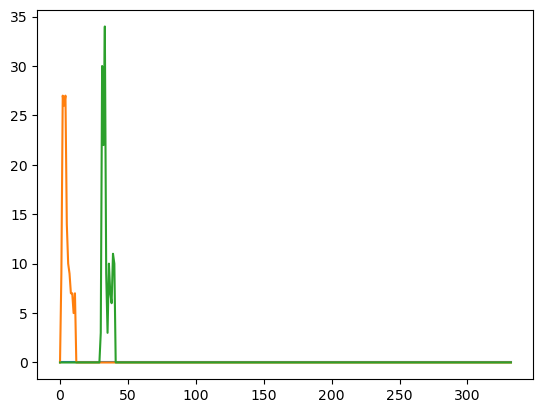

In [1188]:
for num in event_rate_chunk:
    print(num)
    for item in event_rate_chunk[num]:
        plt.plot(item)
    break

In [1170]:
len(event_rate_chunk[num])

1

In [1160]:
num

7

In [1127]:
binned_seq_r_events = []
for spikes_ in seq_spikes:
    # Use the numpy.histogram function to bin the data
    hist, bins = np.histogram(spikes_, bins=np.arange(interval_start, interval_end_points[index_], bin_size))
    binned_seq_r_events += [list(hist)]

NameError: name 'seq_spikes' is not defined

In [1135]:
start_offset = ([0]+list(np.cumsum(np.diff(time_spans))))[chunk_number-1]

In [1140]:
current_sleep_start

7050.0

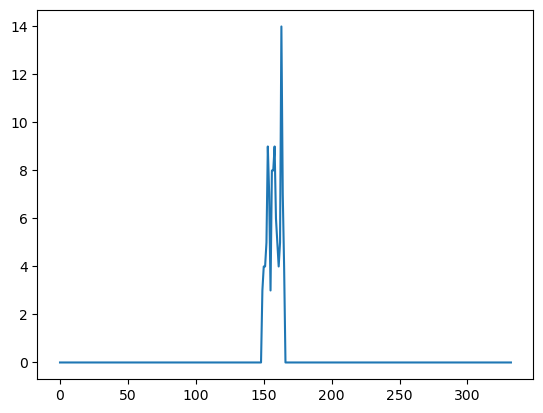

In [1147]:
bin_size = 60

plt.plot(hist)

In [1150]:
hist

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [1155]:
event_rate_chunk

{1: [array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  3,  4,  4,  5,
          9,  7,  3,  8,  8,  9,  6,  5,  4,  5, 14,  7,  4,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 

In [1143]:
real_times_adjusted

array([9639.7223, 8956.6143, 8963.5836, 9101.8148, 9118.4764, 9174.5388,
       9209.8962, 9211.9393, 9216.4919, 9220.132 , 9227.607 , 9233.4325,
       9235.8688, 9239.1251, 9280.2671, 9383.7995, 9483.0948, 9535.7143,
       9588.8365, 9698.3424, 9702.5028, 9705.0969, 9718.1555, 9732.6834,
       9734.2262, 9767.6608, 9769.1216, 9781.722 , 9783.3068, 9790.7596,
       9801.1243, 9801.1243, 9803.8953, 9803.8953, 9805.4306, 9810.7901,
       9810.7901, 9828.8248, 9829.562 , 9832.505 , 9839.7042, 9878.5925,
       9925.1859, 9943.0204, 8950.1653, 9041.0648, 9045.7489, 9054.7436,
       9078.1573, 9176.3917, 9342.713 , 9373.1572, 9380.1447, 9411.0901,
       9469.8024, 9499.2409, 9522.6687, 9551.1889, 9640.4532, 9651.813 ,
       9778.1343, 9873.9276, 9888.0984, 9898.146 , 9912.2522, 9916.1982,
       9333.162 , 9598.9763, 9895.6119, 9007.937 , 9079.4603, 9217.4366,
       9267.0594, 9318.4595, 9383.04  , 9454.6455, 9479.5215, 9493.8986,
       9533.0976, 9552.1776, 9598.9763, 9609.0069, 

In [510]:
replay_clusters_df

,cluster_seq_type,num_spikes,num_neurons,first_spike_time,event_length,last_spike_time,cluster_spike_times,cluster_neurons,spike_plotting_order,coactive_cluster_group
0,1,29,1703.5443,1703.0816,0.4627,1703.5443,"[1703.5093, 1703.0816, 1703.2741, 1703.29, 170...","[40.0, 43.0, 43.0, 43.0, 43.0, 43.0, 43.0, 43....",[19. 37. 37. 37. 37. 37. 37. 37. 33. 33. 18. 2...,0.0
1,1,8,1809.2175,1809.1715,0.0460,1809.2175,"[1809.2047, 1809.172, 1809.1804, 1809.1856, 18...","[55.0, 63.0, 64.0, 64.0, 64.0, 65.0, 70.0, 71.0]",[29. 75. 76. 76. 76. 32. 56. 74.],1.0
2,1,23,1817.6711,1817.3487,0.3224,1817.6711,"[1817.6066, 1817.3487, 1817.3799, 1817.3917, 1...","[38.0, 43.0, 43.0, 43.0, 43.0, 43.0, 43.0, 43....",[23. 37. 37. 37. 37. 37. 37. 37. 21. 17. 44. 7...,2.0
3,1,17,1870.5634,1870.1359,0.4275,1870.5634,"[1870.3538, 1870.371, 1870.1359, 1870.1592, 18...","[3.0, 3.0, 43.0, 43.0, 43.0, 43.0, 43.0, 44.0,...",[38. 38. 37. 37. 37. 37. 37. 33. 33. 33. 33. 2...,3.0
4,1,11,1886.5707,1886.2983,0.2724,1886.5707,"[1886.2983, 1886.3514, 1886.3709, 1886.3759, 1...","[55.0, 55.0, 55.0, 55.0, 64.0, 64.0, 64.0, 64....",[29. 29. 29. 29. 76. 76. 76. 76. 76. 76. 56.],4.0
...,...,...,...,...,...,...,...,...,...,...
81,6,29,1954.1339,1953.4362,0.6977,1954.1339,"[1953.6087, 1953.4362, 1953.455, 1953.4781, 19...","[10.0, 19.0, 19.0, 19.0, 19.0, 19.0, 22.0, 22....",[46. 62. 62. 62. 62. 62. 63. 63. 63. 63. 63. 6...,71.0
82,6,33,1959.6685,1959.5283,0.1402,1959.6685,"[1959.5815, 1959.5919, 1959.5968, 1959.6364, 1...","[19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19....",[62. 62. 62. 62. 62. 62. 62. 62. 63. 63. 75. 7...,43.0
83,6,11,2020.4748,2020.4136,0.0612,2020.4748,"[2020.4136, 2020.4379, 2020.4138, 2020.4381, 2...","[19.0, 19.0, 22.0, 22.0, 63.0, 64.0, 64.0, 64....",[62. 62. 63. 63. 75. 76. 76. 76. 76. 32. 68.],72.0
84,6,14,2058.7986,2058.6826,0.1160,2058.7986,"[2058.7502, 2058.6826, 2058.7303, 2058.7527, 2...","[5.0, 19.0, 19.0, 19.0, 22.0, 22.0, 22.0, 26.0...",[72. 62. 62. 62. 63. 63. 63. 70. 23. 23. 75. 7...,11.0


In [511]:
filtered_r_clusters_df

NameError: name 'filtered_r_clusters_df' is not defined

In [ ]:
#plot frequency of coactive events
# coatve event type freq against time 


In [541]:
all_group_event_times[item]

[2177.8894, 1932.6061]

270_1_6
270_1_6


Text(0.5, 1.0, ' frequency of motfs ')

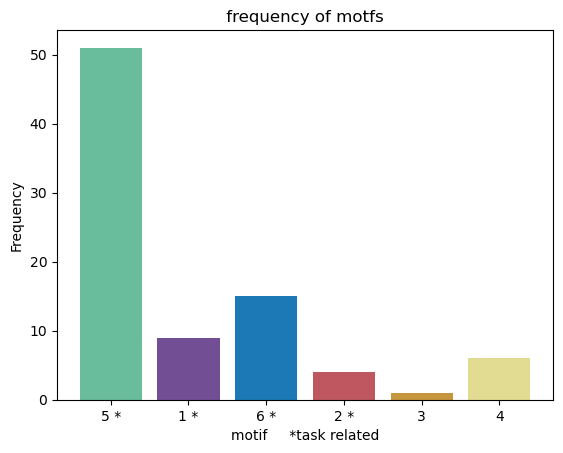

In [560]:
#####################################################################################################################################################################################################

mir = mirs[-1]
colors = ['---',
 '#724F94',
 '#BE575F',
 '#C6963E',
 '#E2DC92',
 '#69BD9D',
 '#1C79B5',
 '#264999',
 'pink',
 'lightblue',
 'k']

awake_PP_path = r"Z:\projects\sequence_squad\organised_data\ppseq_data\finalised_output\striatum\awake\\"

for index_,M_I_R in enumerate(os.listdir(awake_PP_path)):
    if not M_I_R == 'not_suitable':
        mouse = '_'.join(M_I_R.split('_')[0:3])
        if mouse == mir:
            print(mouse)
            c_path = awake_PP_path + M_I_R + r"\analysis_output\reordered_recolored\\" 

sequence_order_df = pd.read_csv(awake_PP_path+"sequence_order.csv")

import ast
seq_order= ast.literal_eval(sequence_order_df[sequence_order_df.mir == mir].seq_order.values[0])
extended_list = seq_order.copy()  # Create a copy of the original list
for num in range(6):
    if num not in extended_list:
        extended_list += [num]
extended_list = np.array(extended_list)


# Counting occurrences of each number
counts = {}
bar_colors = []
for num in replay_clusters_df.cluster_seq_type:
    bar_colors += [colors[num]]
    if num in counts:
        counts[num] += 1
    else:
        counts[num] = 1

# Extracting numbers and their frequencies as separate lists
x = list(counts.keys())
y = list(counts.values())

for index_,M_I_R in enumerate(os.listdir(awake_PP_path)):
    if not M_I_R == 'not_suitable':
        mouse = '_'.join(M_I_R.split('_')[0:3])
        if mouse == mir:
            print(mouse)
            c_path = awake_PP_path + M_I_R + r"\analysis_output\reordered_recolored\\" 

sequence_order_df = pd.read_csv(awake_PP_path+"sequence_order.csv")

import ast
seq_order= ast.literal_eval(sequence_order_df[sequence_order_df.mir == mir].seq_order.values[0])
extended_list = seq_order.copy()  # Create a copy of the original list
for num in range(6):
    if num not in extended_list:
        extended_list += [num]
extended_list = np.array(extended_list)

task_order_inds = []
task_order = []
for item in (extended_list+1):
    for index,cluster_num in enumerate(replay_clusters_df.cluster_seq_type.unique()):
        if cluster_num == item:
            task_order_inds +=[index]
            task_order +=[cluster_num]
            break

# Counting occurrences of each number
counts = {}
bar_colors = []
for num in replay_clusters_df.cluster_seq_type:
    bar_colors += [colors[num]]
    if num in counts:
        counts[num] += 1
    else:
        counts[num] = 1

# Extracting numbers and their frequencies as separate lists
x = list(counts.keys())
y = list(counts.values())

# Creating the bar chart
# plt.bar(np.array(x)[extended_list], np.array(y)[extended_list], color = np.array(colors)[filtered_r_clusters_df.cluster_seq_type.unique()][extended_list])
# plt.bar(x, np.array(y)[e, color = np.array(colors)[filtered_r_clusters_df.cluster_seq_type.unique()])
plt.bar(x, np.array(y)[task_order_inds], color = np.array(colors)[replay_clusters_df.cluster_seq_type.unique()][task_order_inds])


# Customizing x-axis labels
custom_labels = np.array(task_order).astype(str)
for index,item in enumerate(seq_order):
    for i,label in enumerate(custom_labels):
        if str(item+1) == label: 
            custom_labels[i] = custom_labels[i] + ' *'
            break
plt.xticks(x, custom_labels)

# Adding labels and title
plt.xlabel('motif     *task related')
plt.ylabel('Frequency')
plt.title(' frequency of motfs ')

<BarContainer object of 2 artists>

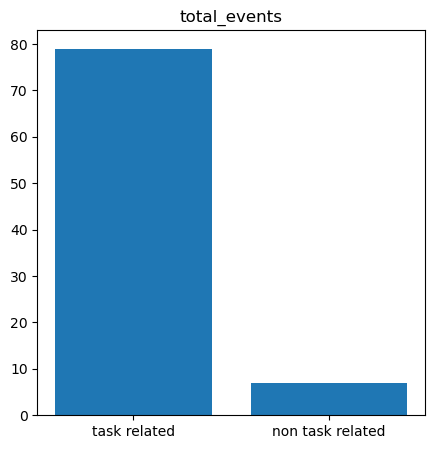

In [576]:
### also save out task related over time against non task related! 

7

In [568]:
y[]

[9, 4, 1, 6, 51, 15]

0
1
2
3
4
5


In [574]:
seq_order

[4, 0, 5, 1]

In [575]:
non_seqs

[2, 3]

{1: 9, 2: 4, 3: 1, 4: 6, 5: 51, 6: 15}

In [ ]:
## save out tasks related vs non related
# save out all this data somehow for future plotting wihtout refiltering 


C:\Users\Emmett\AppData\Local\Temp\ipykernel_15548\2122369112.py:50: RuntimeWarning: invalid value encountered in divide
  normalized_matrix = matrix / col_sums


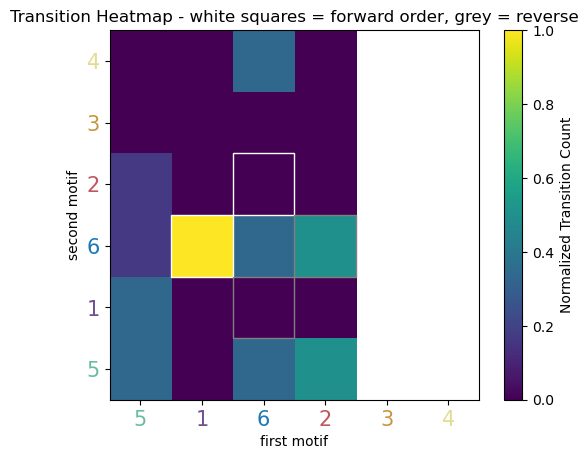

In [523]:
#####################################################################################################################################################################################################

seq_orders = []
for coactive_group in replay_clusters_df.coactive_cluster_group.unique():
    coactive_group_mask = replay_clusters_df.coactive_cluster_group == coactive_group
    if len(replay_clusters_df[coactive_group_mask]) > 1:
        # reorder base don first spike time order:
        re_ordering = np.argsort(replay_clusters_df[coactive_group_mask].first_spike_time.values)
        seq_orders += [list(replay_clusters_df[coactive_group_mask].cluster_seq_type.values[re_ordering])]

fragments =seq_orders

transitions = {}

# Iterate over each fragment
for fragment in fragments:
    # Iterate over each pair of adjacent elements in the fragment
    for i in range(len(fragment) - 1):
        current = fragment[i]
        next_element = fragment[i + 1]

        # Check if the current element is already a key in the transitions dictionary
        if current not in transitions:
            transitions[current] = {}

        # Check if the next element is already a key in the nested dictionary for the current element
        if next_element not in transitions[current]:
            transitions[current][next_element] = 1
        else:
            transitions[current][next_element] += 1

# Define the desired order of elements
element_order = list(extended_list+1)

element_order_reversed = list(reversed(element_order))

# Create an empty matrix with dimensions equal to the number of elements
matrix = np.zeros((len(element_order), len(element_order)))

# Fill the matrix with the transition counts

for i, current in enumerate(element_order):
    for j, next_element in enumerate(element_order):
        if current in transitions and next_element in transitions[current]:
            matrix[i][j] = transitions[current][next_element]

# Normalize the matrix by column
matrix = matrix[::-1]
col_sums = matrix.sum(axis=0)
normalized_matrix = matrix / col_sums

fig, ax = plt.subplots()
im = ax.imshow(normalized_matrix, cmap='viridis', interpolation='nearest')

# Add colored squares to represent the true sequence
logical_order = ast.literal_eval(sequence_order_df[sequence_order_df.mir == mir].seq_order.values[0])
for i, current in enumerate(element_order[0:len(logical_order)]):
    for j, next_element in enumerate(element_order_reversed[0:len(logical_order)]):
        if current == next_element:
            j = j-1
            rect = plt.Rectangle((j-0.5, i-0.5), 1, 1, fill=False, edgecolor='white')
            ax.add_patch(rect)

logical_order = ast.literal_eval(sequence_order_df[sequence_order_df.mir == mir].seq_order.values[0])
for i, current in enumerate(element_order_reversed[0:len(logical_order)]):
    for j, next_element in enumerate(element_order[0:len(logical_order)]):
        if current == next_element:          
            i = i+1
            rect = plt.Rectangle((j-0.5, i-0.5), 1, 1, fill=False, edgecolor='grey')
            ax.add_patch(rect)

# Plot the heatmap

plt.colorbar(im,label='Normalized Transition Count')
plt.xticks(range(len(element_order)), element_order)
plt.yticks(range(len(element_order)), element_order_reversed)
plt.xlabel('first motif')
plt.ylabel('second motif')
plt.title('Transition Heatmap - white squares = forward order, grey = reverse')

# color labels by motif/seq colour
for i, tick_label in enumerate(ax.axes.get_yticklabels()):
    tick_label.set_color(colors[element_order[::-1][i]])
    tick_label.set_fontsize("15")
for i, tick_label in enumerate(ax.axes.get_xticklabels()):
    tick_label.set_color(colors[element_order[i]])
    tick_label.set_fontsize("15")

# # plt.show()
# SaveFig('coaive_motif_transitions_normalised___chunk'+ str(index_+1) + '.png',chunk_path)

In [ ]:
binned_seq_r_events = []
for spikes_ in seq_spikes:
    # Use the numpy.histogram function to bin the data
    hist, bins = np.histogram(spikes_, bins=np.arange(interval_start, interval_end_points[index_], bin_size))
    binned_seq_r_events += [list(hist)]

AttributeError: Line2D.set() got an unexpected keyword argument 'width'

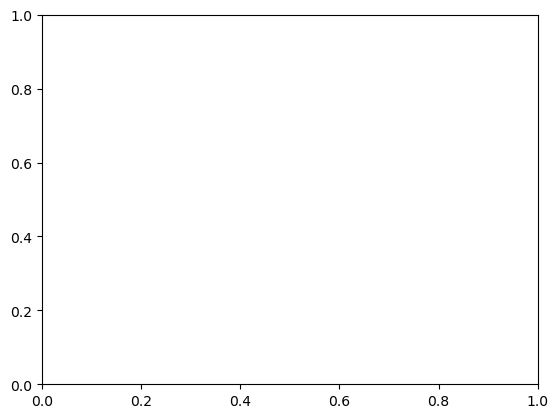

In [350]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have a list of event timestamps
timestamps = R_times_after_sleep[0]

# Define the time bin size in seconds
time_bin_size = 120




In [335]:
+= [list(actual_fs_times[actual_fs_times > current_sleep_start])]

[12612.0115,
 12613.5253,
 12615.5257,
 12615.9668,
 12621.274,
 12633.9053,
 12634.7306,
 12675.0772,
 12706.1995,
 12737.833200000001,
 12742.0255,
 12760.7084,
 12766.467,
 12807.1306,
 12817.7639,
 12830.4303,
 12831.1403,
 12887.0805,
 12923.8646,
 12953.1747,
 12961.191200000001,
 12962.9407,
 12988.8305,
 12999.2862,
 13009.7039,
 13012.940999999999,
 13013.7188,
 13015.7459,
 13016.7346,
 13028.6809,
 13033.2256,
 13036.305400000001,
 13074.3951,
 13091.2789,
 13091.9315,
 13092.8842,
 13100.3668,
 13101.825,
 13103.3281,
 13108.269400000001,
 13122.4354,
 13132.8657,
 13150.7736,
 13222.6697,
 13268.1406,
 13269.4311,
 13270.2864,
 13272.8894,
 13288.9467,
 13305.3394,
 13308.6727,
 13321.8812,
 13324.169,
 13339.8157,
 13340.7669,
 13341.2492,
 13380.4702,
 13405.6647,
 13406.087599999999,
 13409.7058,
 13415.551599999999,
 13417.7509,
 13419.8593,
 13420.5114,
 13421.6885,
 13423.114,
 13424.0405,
 13425.198199999999,
 13427.860700000001,
 13449.0357,
 13462.1134,
 13469.929

In [313]:
[0]+list(np.cumsum(np.diff(time_spans)))

[0, 1000, 2000, 3000]

In [317]:
chunk_number

2

In [320]:
replay_clusters_df

,cluster_seq_type,num_spikes,num_neurons,first_spike_time,event_length,last_spike_time,cluster_spike_times,cluster_neurons,spike_plotting_order,coactive_cluster_group
0,1,118,1011.7514,1010.8017,0.9497,1011.7514,"[1010.8889, 1010.889, 1010.9613, 1010.9615, 10...","[6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, ...",[138. 138. 138. 138. 138. 138. 138. 138. 138. ...,0.0
1,1,6,1055.2181,1055.0710,0.1471,1055.2181,"[1055.0711, 1055.2178, 1055.0713, 1055.2179, 1...","[40.0, 40.0, 42.0, 42.0, 45.0, 48.0]",[140. 140. 143. 143. 139. 142.],1.0
2,1,7,1060.9226,1060.7209,0.2017,1060.9226,"[1060.7211, 1060.7213, 1060.9184, 1060.9185, 1...","[6.0, 6.0, 6.0, 6.0, 7.0, 7.0, 206.0]",[138. 138. 138. 138. 137. 137. 145.],2.0
3,1,6,1070.7706,1070.7587,0.0119,1070.7706,"[1070.7703, 1070.7705, 1070.7706, 1070.7702, 1...","[6.0, 6.0, 6.0, 7.0, 21.0, 163.0]",[138. 138. 138. 137. 116. 72.],3.0
4,1,9,1076.0530,1075.8766,0.1764,1076.0530,"[1075.8767, 1075.8928, 1076.0529, 1075.8768, 1...","[40.0, 40.0, 40.0, 42.0, 42.0, 42.0, 48.0, 48....",[140. 140. 140. 143. 143. 143. 142. 142. 142.],4.0
...,...,...,...,...,...,...,...,...,...,...
1009,6,9,1966.6850,1966.6579,0.0271,1966.6850,"[1966.685, 1966.6579, 1966.664, 1966.6641, 196...","[17.0, 212.0, 212.0, 212.0, 212.0, 212.0, 212....",[113. 111. 111. 111. 111. 111. 111. 111. 233.],453.0
1010,6,12,1969.7896,1969.7673,0.0223,1969.7896,"[1969.7756, 1969.7896, 1969.7813, 1969.7814, 1...","[17.0, 17.0, 24.0, 24.0, 32.0, 82.0, 170.0, 20...",[113. 113. 95. 95. 104. 108. 97. 148. 110. ...,101.0
1011,6,18,1971.1732,1970.9278,0.2454,1971.1732,"[1971.1117, 1971.0033, 1971.0035, 1971.049, 19...","[21.0, 60.0, 61.0, 81.0, 87.0, 87.0, 88.0, 88....",[116. 105. 106. 115. 121. 121. 251. 251. 103. ...,101.0
1012,6,7,1989.8329,1989.7943,0.0386,1989.8329,"[1989.7943, 1989.8327, 1989.7944, 1989.8329, 1...","[86.0, 86.0, 90.0, 90.0, 213.0, 214.0, 214.0]",[185. 185. 183. 183. 240. 242. 242.],461.0


In [296]:
start_ofset

3000

In [297]:
replay_clusters_df

,cluster_seq_type,num_spikes,num_neurons,first_spike_time,event_length,last_spike_time,cluster_spike_times,cluster_neurons,spike_plotting_order,coactive_cluster_group
0,1,23,2012.0539,2012.0115,0.0424,2012.0539,"[2012.0116, 2012.0117, 2012.0119, 2012.0218, 2...","[6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, ...",[138. 138. 138. 138. 138. 138. 138. 138. 138. ...,0.0
1,1,41,2014.2318,2013.5253,0.7065,2014.2318,"[2013.5254, 2013.5256, 2013.5257, 2013.5393, 2...","[6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, ...",[138. 138. 138. 138. 138. 138. 138. 138. 138. ...,1.0
2,1,8,2015.5445,2015.5257,0.0188,2015.5445,"[2015.5259, 2015.5261, 2015.5262, 2015.5257, 2...","[6.0, 6.0, 6.0, 7.0, 7.0, 40.0, 42.0, 48.0]",[138. 138. 138. 137. 137. 140. 143. 142.],2.0
3,1,5,2015.9884,2015.9668,0.0216,2015.9884,"[2015.9669, 2015.9671, 2015.9672, 2015.9668, 2...","[6.0, 6.0, 6.0, 7.0, 37.0]",[138. 138. 138. 137. 79.],2.0
4,1,9,2021.3822,2021.2740,0.1082,2021.3822,"[2021.2742, 2021.2743, 2021.3633, 2021.3634, 2...","[6.0, 6.0, 6.0, 6.0, 7.0, 7.0, 7.0, 37.0, 99.0]",[138. 138. 138. 138. 137. 137. 137. 79. 130.],3.0
...,...,...,...,...,...,...,...,...,...,...
986,6,6,2975.8843,2975.8680,0.0163,2975.8843,"[2975.868, 2975.8734, 2975.8843, 2975.868, 297...","[68.0, 68.0, 68.0, 70.0, 70.0, 200.0]",[100. 100. 100. 99. 99. 101.],139.0
987,6,8,2977.3050,2977.2765,0.0285,2977.3050,"[2977.2765, 2977.2886, 2977.293, 2977.2979, 29...","[32.0, 101.0, 101.0, 101.0, 104.0, 104.0, 104....",[104. 117. 117. 117. 118. 118. 118. 118.],139.0
988,6,9,2978.3731,2978.2878,0.0853,2978.3731,"[2978.3556, 2978.3672, 2978.3731, 2978.3555, 2...","[68.0, 68.0, 68.0, 70.0, 70.0, 70.0, 200.0, 21...",[100. 100. 100. 99. 99. 99. 101. 242. 242.],68.0
989,6,5,2983.9748,2983.8666,0.1082,2983.9748,"[2983.9466, 2983.9594, 2983.9748, 2983.9595, 2...","[15.0, 15.0, 15.0, 170.0, 212.0]",[ 96. 96. 96. 97. 111.],467.0


In [287]:
chunk_time

array([12600, 13600])

In [278]:
replay_clusters_df.first_spike_time + 

0      2012.0115
1      2013.5253
2      2015.5257
3      2015.9668
4      2021.2740
         ...    
986    2975.8680
987    2977.2765
988    2978.2878
989    2983.8666
990    2993.3989
Name: first_spike_time, Length: 991, dtype: float64

In [253]:
time_spans[chunk_number]

[[8300, 9300], [9600, 10600], [12600, 13600]]

In [235]:
current_sleep_start = sleep_start[mouse]

In [260]:
for file in os.listdir(current_mouse_path):
    if 'chunk' in file:
        print(file)
        break

chunk1_8300to9300


In [266]:
chunk_time

array([12600, 13600])

In [234]:
replay_clusters_df.first_spike_time > 

0      2006.6951
1      2689.7223
2      2833.6734
3      2006.6143
4      2013.5836
         ...    
129    2907.0114
130    2955.4117
131    2970.2593
132    2988.8188
133    2991.3174
Name: first_spike_time, Length: 134, dtype: float64

In [179]:
replay_clusters_df

,cluster_seq_type,num_spikes,num_neurons,first_spike_time,event_length,last_spike_time,cluster_spike_times,cluster_neurons,spike_plotting_order,coactive_cluster_group
0,1,77,2006.8222,2006.6951,0.1271,2006.8222,"[2006.7727, 2006.7824, 2006.8222, 2006.7521, 2...","[8.0, 8.0, 36.0, 37.0, 37.0, 37.0, 37.0, 37.0,...",[52. 52. 20. 40. 40. 40. 40. 40. 41. 41. 41. 4...,0.0
1,1,12,2689.7597,2689.7223,0.0374,2689.7597,"[2689.7349, 2689.735, 2689.7455, 2689.7497, 26...","[27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 43.0, 50....",[55. 55. 55. 55. 55. 55. 46. 33. 33. 33. 33. 33.],1.0
2,1,71,2833.7975,2833.6734,0.1241,2833.7975,"[2833.7902, 2833.7511, 2833.7199, 2833.7349, 2...","[18.0, 36.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37....",[23. 20. 40. 40. 40. 40. 40. 40. 41. 41. 41. 4...,2.0
3,2,23,2006.6928,2006.6143,0.0785,2006.6928,"[2006.6896, 2006.6928, 2006.6265, 2006.6803, 2...","[37.0, 37.0, 38.0, 38.0, 38.0, 40.0, 40.0, 40....",[40. 40. 41. 41. 41. 42. 42. 42. 42. 47. 47. 4...,0.0
4,2,10,2013.6273,2013.5836,0.0437,2013.6273,"[2013.6219, 2013.6158, 2013.6273, 2013.5977, 2...","[31.0, 39.0, 39.0, 40.0, 41.0, 41.0, 41.0, 41....",[16. 39. 39. 42. 47. 47. 47. 47. 33. 33.],3.0
...,...,...,...,...,...,...,...,...,...,...
129,6,47,2908.8746,2907.0114,1.8632,2908.8746,"[2907.0114, 2907.3805, 2908.5798, 2907.3857, 2...","[14.0, 14.0, 14.0, 16.0, 16.0, 16.0, 16.0, 16....",[32. 32. 32. 35. 35. 35. 35. 35. 35. 35. 35. 3...,114.0
130,6,11,2955.5187,2955.4117,0.1070,2955.5187,"[2955.4325, 2955.4391, 2955.4563, 2955.4727, 2...","[16.0, 16.0, 16.0, 16.0, 22.0, 22.0, 22.0, 34....",[35. 35. 35. 35. 27. 27. 27. 34. 34. 34. 34.],115.0
131,6,16,2970.5620,2970.2593,0.3027,2970.5620,"[2970.3795, 2970.3952, 2970.4053, 2970.4572, 2...","[15.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16....",[22. 35. 35. 35. 35. 35. 35. 35. 35. 37. 27. 2...,116.0
132,6,32,2989.6255,2988.8188,0.8067,2989.6255,"[2988.8188, 2988.8593, 2988.8824, 2988.9287, 2...","[16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16....",[35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 3...,117.0


In [ ]:
rest_epoch_start_times = 

In [116]:
len(shuffle_reactivations_per_min)

29

In [117]:
len(reactivations_per_min)

30

In [ ]:
#stats
print('control stats:')
if scipy.stats.normaltest(list(plot_df.error_rate[cb_mask]) + list(plot_df.error_rate[cl_mask]))[-1] > 0.05:
    print('data is normally distributed')
else:
    print('data is not normally distributed')
print(scipy.stats.ttest_rel(plot_df.error_rate[cb_mask],plot_df.error_rate[cl_mask]))
print('---------')
#stats
print('lesion stats:')
if scipy.stats.normaltest(list(plot_df.error_rate[lb_mask]) + list(plot_df.error_rate[ll_mask]))[-1] > 0.05:
    print('data is normally distributed')
else:
    print('data is not normally distributed')
print(scipy.stats.ttest_rel(plot_df.error_rate[lb_mask],plot_df.error_rate[ll_mask]))

In [ ]:
## plt reactivation rate across time. 
## plot across mice warp vals 
## 